<a href="https://colab.research.google.com/github/Lakshana3/Sparse-CNN-Accelerator/blob/main/openlane/Sparse_CNN_Accelerator_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OpenLane Colab

This Google Colab notebook will:
* Install OpenLane and its dependencies
* Run a simple design, namely a serial-parallel multiplier, through the flow
  and targeting the [open source sky130 PDK](https://github.com/google/skywater-pdk/)
  by Google and Skywater.

In [ ]:
# @title Setup Nix {display-mode: "form"}
# @markdown <img src="https://raw.githubusercontent.com/NixOS/nixos-artwork/master/logo/nix-snowflake.svg" width="32"/>
# @markdown
# @markdown Nix is a package manager with an emphasis on reproducible builds,
# @markdown and it is the primary method for installing OpenLane 2.
# @markdown
# @markdown This step installs the Nix package manager and enables the
# @markdown experimental "flakes" feature.
# @markdown
# @markdown If you're not in a Colab, this just sets the environment variables.
# @markdown You will need to install Nix and enable flakes on your own following
# @markdown [this guide](https://openlane2.readthedocs.io/en/stable/getting_started/common/nix_installation/index.html).
import os
import sys
import shutil

os.environ["LOCALE_ARCHIVE"] = "/usr/lib/locale/locale-archive"

if "google.colab" in sys.modules:
    if shutil.which("nix-env") is None:
        !curl -L https://nixos.org/nix/install | bash -s -- --daemon --yes
        !echo "extra-experimental-features = nix-command flakes" >> /etc/nix/nix.conf
        !killall nix-daemon
else:
    if shutil.which("nix-env") is None:
        raise RuntimeError("Nix is not installed!")

os.environ["PATH"] = f"/nix/var/nix/profiles/default/bin/:{os.getenv('PATH')}"

In [ ]:
# @title Get OpenLane {display-mode: "form"}
# @markdown Click the ▷ button to download and install OpenLane.
# @markdown
# @markdown This will install OpenLane's tool dependencies using Nix,
# @markdown and OpenLane itself using PIP.
# @markdown
# @markdown Note that `python3-tk` may need to be installed using your OS's
# @markdown package manager.
import os
import subprocess
import IPython

openlane_version = "version-2.1"  # @param {key:"OpenLane Version", type:"string"}

if openlane_version == "latest":
    openlane_version = "main"

pdk_root = "~/.volare"  # @param {key:"PDK Root", type:"string"}

pdk_root = os.path.expanduser(pdk_root)

pdk = "sky130"  # @param {key:"PDK (without the variant)", type:"string"}

openlane_ipynb_path = os.path.join(os.getcwd(), "openlane_ipynb")

display(IPython.display.HTML("<h3>Downloading OpenLane…</a>"))


TESTING_LOCALLY = False
!rm -rf {openlane_ipynb_path}
!mkdir -p {openlane_ipynb_path}
if TESTING_LOCALLY:
    !ln -s {os.getcwd()} {openlane_ipynb_path}
else:
    !curl -L "https://github.com/efabless/openlane2/tarball/{openlane_version}" | tar -xzC {openlane_ipynb_path} --strip-components 1

try:
    import tkinter
except ImportError:
    if "google.colab" in sys.modules:
        !sudo apt-get install python-tk

try:
    import tkinter
except ImportError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to import the <code>tkinter</code> library for Python, which is required to load PDK configuration values. Make sure <code>python3-tk</code> or equivalent is installed on your system.</a>'
        )
    )
    raise e from None


display(IPython.display.HTML("<h3>Downloading OpenLane's dependencies…</a>"))
try:
    subprocess.check_call(
        ["nix", "profile", "install", ".#colab-env", "--accept-flake-config"],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install binary dependencies using Nix…</h3>'
        )
    )

display(IPython.display.HTML("<h3>Downloading Python dependencies using PIP…</a>"))
try:
    subprocess.check_call(
        ["pip3", "install", "."],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install Python dependencies using PIP…</h3>'
        )
    )
    raise e from None

display(IPython.display.HTML("<h3>Downloading PDK…</a>"))
import volare

volare.enable(
    volare.get_volare_home(pdk_root),
    pdk,
    open(
        os.path.join(openlane_ipynb_path, "openlane", "open_pdks_rev"),
        encoding="utf8",
    )
    .read()
    .strip(),
)

sys.path.insert(0, openlane_ipynb_path)
display(IPython.display.HTML("<h3>⭕️ Done.</a>"))

import logging

# Remove the stupid default colab logging handler
logging.getLogger().handlers.clear()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9491k    0 9491k    0     0  10.8M      0 --:--:-- --:--:-- --:--:-- 22.6M


Version bdc9412b3e468c102d01b7cf6337be06ec6e9c9a enabled for the sky130 PDK.

In [ ]:
import openlane

print(openlane.__version__)

2.1.11


### Creating the design

Now that OpenLane is set up, we can write a Verilog file as follows:

In [ ]:
%%writefile /content/sparse_cnn/src/sparse_cnn_accelerator_single.v
// ---------sparse_cnn_accelerator_single------//
module sparse_cnn_accelerator_single (
  input wire clk,
  input wire reset_async,
  input wire input_valid,
  input  wire [7:0]   shared_mask,
  input  wire [47:0]  shared_booth_enc,
  input wire [63:0] activations,
  output wire [17:0] result,
  output wire output_valid
);
  // Reset Synchronization
  reg rst_meta, rst_sync;
  always @(posedge clk or posedge reset_async) begin
    if (reset_async) {rst_meta,rst_sync} <= 2'b11;
    else             {rst_meta,rst_sync} <= {1'b0, rst_meta};
  end
  wire reset = rst_sync;

  // input Latching (on valid strobe)
  reg [63:0] act_reg;
  reg        stage1_valid;
  always @(posedge clk) begin
    if (reset) begin
      act_reg       <= 0;
      stage1_valid  <= 0;
    end else begin
      stage1_valid  <= input_valid;
      if (input_valid) begin
        act_reg       <= activations;
      end
    end
  end

  // MODIFIED: Uses shared mask instead of extracting from weight_mask
  wire [3:0] pop_count = shared_mask[0] + shared_mask[1] + shared_mask[2] + shared_mask[3] +
                        shared_mask[4] + shared_mask[5] + shared_mask[6] + shared_mask[7];
  wire sparsity_ge_50 = (pop_count <= 4);

  // Activation Selector (pipelined, robust: see below)
  wire [31:0] selected_activations;
  wire        selector_done;
  activation_selector act_sel (
    .clk(clk),
    .reset(reset),
    .mask(shared_mask), // MODIFIED: Uses shared mask
    .activations(act_reg),
    .selected_act(selected_activations),
    .done(selector_done)
  );

  // Valid Pipeline (for output valid alignment)
  // seven stage valid pipeline:
  reg [5:0] vpipe;
  always @(posedge clk) begin
    if (reset) vpipe <= 0;
    else       vpipe <= {vpipe[4:0], stage1_valid};
  end

  // MODIFIED: Block MAC with registered output
  wire [17:0] mac_result;
  wire        mac_valid;
  block_mac_unit blk_mac (
    .clk(clk),
    .reset(reset),
    .mask(shared_mask), // MODIFIED: Uses shared mask
    .booth_encoded(shared_booth_enc), // MODIFIED: Uses shared encoding
    .selected_activations(selected_activations),
    .selector_done(selector_done),
    .sparsity_ge_50(sparsity_ge_50),
    .result(mac_result),
    .valid(mac_valid)
  );

  // 8. Output Registering and Assignments
  reg [17:0] result_reg;
  always @(posedge clk) begin
    if (reset) begin
      result_reg      <= 0;
    end else if(vpipe[5]) begin
      // Register the MAC result
      result_reg      <= mac_result;
    end
  end
  assign result       = result_reg;
  assign output_valid = vpipe[5];

endmodule

// ========== Booth Encoder (pipelined output) ==========
module booth_pre_encoder (
  input  wire        clk,
  input  wire        reset,
  input  wire [31:0] weight,
  output reg  [47:0] booth_encoded
);
  function [2:0] booth_encode(input [2:0] bits);
    case (bits)
      3'b000: booth_encode = 3'b100; // 0
      3'b001: booth_encode = 3'b001; // +1
      3'b010: booth_encode = 3'b001; // +1
      3'b011: booth_encode = 3'b000; // +2
      3'b100: booth_encode = 3'b010; // -2
      3'b101: booth_encode = 3'b011; // -1
      3'b110: booth_encode = 3'b011; // -1
      3'b111: booth_encode = 3'b100; // 0
    endcase
  endfunction

  always @(posedge clk) begin
    if (reset) booth_encoded <= 48'd0;
    else begin
      booth_encoded[2:0]    <= booth_encode({weight[1:0], 1'b0});
      booth_encoded[5:3]    <= booth_encode(weight[3:1]);
      booth_encoded[8:6]    <= booth_encode(weight[5:3]);
      booth_encoded[11:9]   <= booth_encode(weight[7:5]);
      booth_encoded[14:12]  <= booth_encode({weight[9:8], 1'b0});
      booth_encoded[17:15]  <= booth_encode(weight[11:9]);
      booth_encoded[20:18]  <= booth_encode(weight[13:11]);
      booth_encoded[23:21]  <= booth_encode(weight[15:13]);
      booth_encoded[26:24]  <= booth_encode({weight[17:16], 1'b0});
      booth_encoded[29:27]  <= booth_encode(weight[19:17]);
      booth_encoded[32:30]  <= booth_encode(weight[21:19]);
      booth_encoded[35:33]  <= booth_encode(weight[23:21]);
      booth_encoded[38:36]  <= booth_encode({weight[25:24], 1'b0});
      booth_encoded[41:39]  <= booth_encode(weight[27:25]);
      booth_encoded[44:42]  <= booth_encode(weight[29:27]);
      booth_encoded[47:45]  <= booth_encode(weight[31:29]);
    end
  end
endmodule

// ========== MAC Unit with Partial Product Generator ==========
module generate_pprow (
  input  wire [2:0] ctrl,
  input  wire [7:0] x,
  output reg  [8:0] pp
);
  wire signed [8:0] sx = {x[7], x}; // Sign-extend

  always @(*) begin
    case (ctrl)
      3'b100: pp = 9'd0;         // 0
      3'b001: pp = sx;           // +1
      3'b000: pp = sx << 1;      // +2
      3'b010: pp = -(sx << 1);   // -2
      3'b011: pp = -sx;          // -1
      default: pp = 9'd0;
    endcase
  end
endmodule

module mac_unit (
    input  wire        clk,
    input  wire        reset,
    input  wire [11:0] enc,       // 4x Radix-4 Booth encodings (3 bits each)
    input  wire [7:0]  act,       // 8-bit activation
    output wire signed [16:0] result  // 17-bit output (for 18-bit accumulation)
);
    // ================================================
    // Clock Gating Logic (Booth-Zero Aware)
    // ================================================
    // MODIFIED: Correct Booth-zero detection
    function automatic is_booth_active(input [2:0] booth);
        return (booth != 3'b100);  // '100' = zero in Radix-4 Booth
    endfunction

    wire mac_clk_en = is_booth_active(enc[2:0])   ||  // Lane 0
                      is_booth_active(enc[5:3])   ||  // Lane 1
                      is_booth_active(enc[8:6])   ||  // Lane 2
                      is_booth_active(enc[11:9]);     // Lane 3

    (* gclk_enable = "mac_clk_en" *)
    wire gated_clk;
    assign gated_clk = clk & mac_clk_en;

    // MODIFIED: Partial Product Generation with gated clock
    wire [8:0] pp0, pp1, pp2, pp3;
    generate_pprow pp0_gen(.ctrl(enc[2:0]), .x(act), .pp(pp0));
    generate_pprow pp1_gen(.ctrl(enc[5:3]), .x(act), .pp(pp1));
    generate_pprow pp2_gen(.ctrl(enc[8:6]), .x(act), .pp(pp2));
    generate_pprow pp3_gen(.ctrl(enc[11:9]), .x(act), .pp(pp3));

    // MODIFIED: Wallace Tree Addition with registered output
    wire signed [16:0] sp0 = $signed(pp0);
    wire signed [16:0] sp1 = $signed(pp1) <<< 2;
    wire signed [16:0] sp2 = $signed(pp2) <<< 4;
    wire signed [16:0] sp3 = $signed(pp3) <<< 6;

    // Stage 1: CSA
    wire [16:0] s1 = sp0 ^ sp1 ^ sp2;
    wire [16:0] c1 = ((sp0 & sp1) | (sp0 & sp2) | (sp1 & sp2)) << 1;

    // Stage 2: CSA + Final CPA
    wire [16:0] s2 = s1 ^ c1 ^ sp3;
    wire [16:0] c2 = ((s1 & c1) | (s1 & sp3) | (c1 & sp3)) << 1;

    // MODIFIED: Register outpck
    reg signed [16:0] result_reg;
  always @(posedge gated_clk) begin // MAC result registers (clock-gated domain) sync reset
        if (reset) begin
            result_reg <= 0;
        end else begin
            result_reg <= s2 + c2;  // Final CPA
        end
    end

    assign result = result_reg;
endmodule

// ========== Activation Selector ==========
module activation_selector (
  input  wire        clk,
  input  wire        reset,
  input  wire [7:0]  mask,
  input  wire [63:0] activations,
  output reg  [31:0] selected_act,
  output reg         done
);
  //reg [7:0] mask_reg;
  reg [63:0] act_reg;
  always @(posedge clk) begin
    if (reset) begin
      //mask_reg <= 0;
      act_reg  <= 0;
    end else begin
      //mask_reg <= mask;
      act_reg  <= activations;
    end
  end

  function [2:0] pe(input [7:0] m); // priority encoder
    casez (m)
      8'b???????1: pe = 3'd0;
      8'b??????10: pe = 3'd1;
      8'b?????100: pe = 3'd2;
      8'b????1000: pe = 3'd3;
      8'b???10000: pe = 3'd4;
      8'b??100000: pe = 3'd5;
      8'b?1000000: pe = 3'd6;
      8'b10000000: pe = 3'd7;
      default: pe = 3'd0;
    endcase
  endfunction

  reg        cycle;
  reg [7:0]  rem_mask;

  //wire [3:0] popcount = mask_reg[0]+mask_reg[1]+mask_reg[2]+mask_reg[3]+mask_reg[4]+mask_reg[5]+mask_reg[6]+mask_reg[7];
  wire [3:0] popcount = mask[0]+mask[1]+mask[2]+mask[3]+mask[4]+mask[5]+mask[6]+mask[7];
  wire       sparse   = (popcount <= 4);

  //wire [7:0] sel_mask = (sparse || !cycle) ? mask_reg : rem_mask;.
  wire [7:0] sel_mask = (sparse || !cycle) ? mask : rem_mask;

  wire [2:0] i0 = pe(sel_mask);
  wire [7:0] m1 = sel_mask & ~(8'd1 << i0);
  wire [2:0] i1 = pe(m1);
  wire [7:0] m2 = m1      & ~(8'd1 << i1);
  wire [2:0] i2 = pe(m2);
  wire [7:0] m3 = m2      & ~(8'd1 << i2);
  wire [2:0] i3 = pe(m3);

  wire [7:0] a0 = act_reg[i0*8 +:8];
  wire [7:0] a1 = act_reg[i1*8 +:8];
  wire [7:0] a2 = act_reg[i2*8 +:8];
  wire [7:0] a3 = act_reg[i3*8 +:8];

  always @(posedge clk) begin
    if (reset) begin
      selected_act <= 0;
      done         <= 0;
      cycle        <= 0;
      rem_mask     <= 0;
    end else if (sparse) begin
      // Single cycle operation: output selection
      selected_act <= {a3,a2,a1,a0};
      done         <= 1;
      cycle        <= 0;
    end else if (!cycle) begin // first half dense
      selected_act <= {a3,a2,a1,a0};
      rem_mask     <= m3 & ~(8'd1 << i3);
      done         <= 1;
      cycle        <= 1;
    end else begin // second half dense
      selected_act <= {a3,a2,a1,a0};
      done         <= 1;
      cycle        <= 0;
    end
  end
endmodule

// ========== Block MAC Unit ==========
// Always update inputs on selector_done; only asserts valid after the second cycle if low sparsity
module block_mac_unit (
  input  wire        clk,
  input  wire        reset,
  input  wire [7:0]  mask,
  input  wire [47:0] booth_encoded,
  input  wire [31:0] selected_activations,
  input  wire        selector_done,
  input  wire        sparsity_ge_50,
  output reg  [17:0] result,
  output reg         valid
);
  // Input pipelining (latch on selector_done)
  reg [47:0] booth_encoded_r;
  reg [31:0] selected_activations_r;
  reg        selector_done_r;

  always @(posedge clk) begin
    if (reset) begin
      booth_encoded_r        <= 48'd0;
      selected_activations_r <= 32'd0;
      selector_done_r        <= 1'b0;
    end else begin
      selector_done_r <= selector_done;
      if (selector_done) begin
        booth_encoded_r        <= booth_encoded;
        selected_activations_r <= selected_activations;
      end
    end
  end

  // MACs for 4 lanes
  wire signed [16:0] mac0_result, mac1_result, mac2_result, mac3_result;
  mac_unit mac0 (.clk(clk), .reset(reset), .enc(booth_encoded[11:0]), .act(selected_activations[7:0]), .result(mac0_result));
  mac_unit mac1 (.clk(clk), .reset(reset), .enc(booth_encoded[23:12]), .act(selected_activations[15:8]), .result(mac1_result));
  mac_unit mac2 (.clk(clk), .reset(reset), .enc(booth_encoded[35:24]), .act(selected_activations[23:16]), .result(mac2_result));
  mac_unit mac3 (.clk(clk), .reset(reset), .enc(booth_encoded[47:36]), .act(selected_activations[31:24]), .result(mac3_result));

  wire signed [17:0] mac_sum =
  {mac0_result[16], mac0_result} +
  {mac1_result[16], mac1_result} +
  {mac2_result[16], mac2_result} +
  {mac3_result[16], mac3_result};

  // Dense-mode accumulator
  reg [17:0] partial_sum;
  reg accumulation_cycle;

  always @(posedge clk) begin
    if (reset) begin
      result <= 0;
      valid <= 0;
      partial_sum <= 0;
      accumulation_cycle <= 0;
    end else begin
      valid <= 0;         // Default: valid low
      if (selector_done_r) begin
        if (sparsity_ge_50) begin
          result <= mac_sum;
          valid <= 1;
        end else begin
          if (!accumulation_cycle) begin
            // First cycle of accumulation
            partial_sum <= mac_sum;
            accumulation_cycle <= 1;
          end else begin
            result <= partial_sum + mac_sum;
            valid <= 1;
            accumulation_cycle <= 0;
          end
        end
      end
    end
  end
endmodule
/*
module spm(clk, rst, x, y, p);
    parameter size = 32;
    input clk, rst;
    input y;
    input[size-1:0] x;
    output p;

    wire[size-1:1] pp;
    wire[size-1:0] xy;

    genvar i;

    CSADD csa0 (.clk(clk), .rst(rst), .x(x[0]&y), .y(pp[1]), .sum(p));
    generate for(i=1; i<size-1; i=i+1) begin
        CSADD csa (.clk(clk), .rst(rst), .x(x[i]&y), .y(pp[i+1]), .sum(pp[i]));
    end endgenerate
    TCMP tcmp (.clk(clk), .rst(rst), .a(x[size-1]&y), .s(pp[size-1]));

endmodule

module TCMP(clk, rst, a, s);
    input clk, rst;
    input a;
    output reg s;

    reg z;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            //Reset logic goes here.
            s <= 1'b0;
            z <= 1'b0;
        end
        else begin
            //Sequential logic goes here.
            z <= a | z;
            s <= a ^ z;
        end
    end
endmodule

module CSADD(clk, rst, x, y, sum);
    input clk, rst;
    input x, y;
    output reg sum;

    reg sc;

    // Half Adders logic
    wire hsum1, hco1;
    assign hsum1 = y ^ sc;
    assign hco1 = y & sc;

    wire hsum2, hco2;
    assign hsum2 = x ^ hsum1;
    assign hco2 = x & hsum1;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            //Reset logic goes here.
            sum <= 1'b0;
            sc <= 1'b0;
        end
        else begin
            //Sequential logic goes here.
            sum <= hsum2;
            sc <= hco1 ^ hco2;
        end
    end
endmodule*/
/*
from openlane.config import Config

Config.interactive(
    "spm",
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=10,
    PRIMARY_GDSII_STREAMOUT_TOOL="klayout",
)
*/

Overwriting /content/sparse_cnn/src/sparse_cnn_accelerator_single.v


In [ ]:
%%writefile /content/sparse_cnn/config.json
{
  "DESIGN_NAME": "sparse_cnn_accelerator_single",
  "VERILOG_FILES": [
    "/content/sparse_cnn/src/sparse_cnn_accelerator_single.v"
  ],
  "CLOCK_PERIOD": 30,
  "PL_RESIZER_ENABLE": 1,
  "PL_RESIZER_TIMING_OPTIMIZATIONS": 1,
  "PL_RESIZER_BUFFER_INPUT_PORTS": 1,
  "PL_RESIZER_BUFFER_OUTPUT_PORTS": 1,
  "PL_RESIZER_MAX_ITERATIONS": 5,
  "ROUTING_STRATEGY": 0,
  "GRT_ALLOW_CONGESTION": 1,
  "POSTROUTE_OPTIMIZE_HOLD": 1,
  "DIODE_INSERTION_STRATEGY": 3,
  "GRT_REPAIR_ANTENNAS": 1,
  "STA_RECALC": 1
}


Writing /content/sparse_cnn/config.json


### Setting up the configuration

OpenLane requries you to configure any Flow before using it. This is done using
the `config` module.

For colaboratories, REPLs and other interactive environments where there is no
concrete Flow object, the Configuration may be initialized using `Config.interactive`,
which will automatically propagate the configuration to any future steps.

You can find the documentation for `Config.interactive` [here](https://openlane2.readthedocs.io/en/latest/reference/api/config/index.html#openlane.config.Config.interactive).



In [ ]:
from openlane.config import Config

Config.interactive(
    "sparse_cnn_accelerator_single",                           # <-- Your top-level module name
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=15,                        # <-- ns
    #SDC="src/design.sdc",                   # <-- Path to your SDC, if available
    PRIMARY_GDSII_STREAMOUT_TOOL="klayout",

    # Remove step-specific options from here
    # PL_RESIZER_ENABLE=True,
    # PL_RESIZER_TIMING_OPTIMIZATIONS=True,
    # PL_RESIZER_BUFFER_INPUT_PORTS=True,
    # PL_RESIZER_BUFFER_OUTPUT_PORTS=True,
    # PL_RESIZER_MAX_ITERATIONS=5,
    # PL_RESIZER_HOLD_SLACK_MARGIN=0.05,

    # Routing Options
    # ROUTING_STRATEGY=0,
    # GRT_ALLOW_CONGESTION=True,

    # Hold optimization and diode insertion
    # POSTROUTE_OPTIMIZE_HOLD=True,
    # DIODE_INSERTION_STRATEGY=3,

    # Antenna repair
    # GRT_REPAIR_ANTENNAS=True,

    # Timing recalculation
    # STA_RECALC=True,

    # Optional: you can still add VERILOG_FILES in the respective step config if needed
    # VERILOG_FILES=["/path/to/sparse_cnn_accelerator_single.v"],

    # Optionally, set area hint (first run: let tool decide, later you can add DIE_AREA/CORE_AREA based on reports)
    # DIE_AREA=[0, 0, 500, 500],            # <-- Uncomment and adjust after first successful run, if you like
    # CORE_AREA=[50, 50, 450, 450],         # <-- As above
    # Any extra config options: e.g., timing signoff corners, lib/lef paths, etc.
)


### Interactive Configuration
#### Initial Values

<br />

```yaml
CELL_BB_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox_pp.v
CELL_GDS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds
CELL_LEFS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef
CELL_PAD_EXCLUDE:
- sky130_fd_sc_hd__tap*
- sky130_fd_sc_hd__decap*
- sky130_ef_sc_hd__decap*
- sky130_fd_sc_hd__fill*
CELL_SPICE_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice
CELL_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/primitives.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd.v
CLOCK_NET: clk
CLOCK_PERIOD: 15
CLOCK_PORT: clk
CLOCK_TRANSITION_CONSTRAINT: 0.15
CLOCK_UNCERTAINTY_CONSTRAINT: 0.25
CLOCK_WIRE_RC_LAYERS: null
DECAP_CELL:
- sky130_ef_sc_hd__decap_12
- sky130_fd_sc_hd__decap_8
- sky130_fd_sc_hd__decap_6
- sky130_fd_sc_hd__decap_4
- sky130_fd_sc_hd__decap_3
DEFAULT_CORNER: nom_tt_025C_1v80
DEFAULT_MAX_TRAN: null
DESIGN_DIR: .
DESIGN_NAME: sparse_cnn_accelerator_single
DIE_AREA: null
DIODE_CELL: sky130_fd_sc_hd__diode_2/DIODE
ENDCAP_CELL: sky130_fd_sc_hd__decap_3
EXTRA_EXCLUDED_CELLS: null
EXTRA_GDS_FILES: null
EXTRA_LEFS: null
EXTRA_LIBS: null
EXTRA_SPICE_MODELS: null
EXTRA_VERILOG_MODELS: null
FALLBACK_SDC_FILE: /content/openlane_ipynb/openlane/scripts/base.sdc
FILL_CELL:
- sky130_fd_sc_hd__fill*
FP_IO_HLAYER: met3
FP_IO_VLAYER: met2
FP_TAPCELL_DIST: 13
FP_TRACKS_INFO: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tracks.info
GND_NETS: null
GND_PIN: VGND
GPIO_PADS_LEF:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_fd_io.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_ef_io.lef
GPIO_PADS_LEF_CORE_SIDE:
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_fd_io_core.lef
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_ef_io_core.lef
GPIO_PADS_VERILOG:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/verilog/sky130_ef_io.v
GPIO_PAD_CELLS:
- sky130_fd_io*
- sky130_ef_io*
IO_DELAY_CONSTRAINT: 20
LIB:
  '*_ff_n40C_1v95':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib
  '*_ss_100C_1v60':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib
  '*_tt_025C_1v80':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib
MACROS: null
MAX_CAPACITANCE_CONSTRAINT: 0.2
MAX_FANOUT_CONSTRAINT: 10
MAX_TRANSITION_CONSTRAINT: 0.75
OUTPUT_CAP_LOAD: 33.442
PDK: sky130A
PDK_ROOT: /root/.volare
PLACE_SITE: unithd
PNR_EXCLUDED_CELL_FILE: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/drc_exclude.cells
PRIMARY_GDSII_STREAMOUT_TOOL: klayout
RT_MAX_LAYER: met5
RT_MIN_LAYER: met1
SCL_GROUND_PINS:
- VGND
- VNB
SCL_POWER_PINS:
- VPWR
- VPB
SIGNAL_WIRE_RC_LAYERS: null
STA_CORNERS:
- nom_tt_025C_1v80
- nom_ss_100C_1v60
- nom_ff_n40C_1v95
- min_tt_025C_1v80
- min_ss_100C_1v60
- min_ff_n40C_1v95
- max_tt_025C_1v80
- max_ss_100C_1v60
- max_ff_n40C_1v95
STD_CELL_LIBRARY: sky130_fd_sc_hd
SYNTH_BUFFER_CELL: sky130_fd_sc_hd__buf_2/A/X
SYNTH_CLK_DRIVING_CELL: null
SYNTH_DRIVING_CELL: sky130_fd_sc_hd__inv_2/Y
SYNTH_EXCLUDED_CELL_FILE: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/no_synth.cells
SYNTH_TIEHI_CELL: sky130_fd_sc_hd__conb_1/HI
SYNTH_TIELO_CELL: sky130_fd_sc_hd__conb_1/LO
TECH_LEFS:
  max_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__max.tlef
  min_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__min.tlef
  nom_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef
TIME_DERATING_CONSTRAINT: 5
TRISTATE_CELLS:
- sky130_fd_sc_hd__ebuf*
VDD_NETS: null
VDD_PIN: VPWR
VDD_PIN_VOLTAGE: 1.8
WELLTAP_CELL: sky130_fd_sc_hd__tapvpwrvgnd_1
WIRE_LENGTH_THRESHOLD: null
meta:
  flow: null
  openlane_version: 2.1.11
  step: null
  substituting_steps: null
  version: 1

```


### Running implementation steps

There are two ways to obtain OpenLane's built-in implementation steps:

* via directly importing from the `steps` module using its category:
    * `from openlane.steps import Yosys` then `Synthesis = Yosys.Synthesis`
* by using the step's id from the registry:
    * `from openlane.steps import Step` then `Synthesis = Step.factory.get("Yosys.Synthesis")`

You can find a full list of included steps here: https://openlane2.readthedocs.io/en/latest/reference/step_config_vars.html

In [ ]:
from openlane.steps import Step

* First, get the step (and display its help)...

In [ ]:
Synthesis = Step.factory.get("Yosys.Synthesis")

Synthesis.display_help()


(step-yosys-synthesis)=
### Synthesis

```{eval-rst}

Performs synthesis and technology mapping on Verilog RTL files
using Yosys and ABC, emitting a netlist.

Some metrics will also be extracted and updated, namely:

* ``design__instance__count``
* ``design__instance_unmapped__count``
* ``design__instance__area``

```

#### Importing
```python
from openlane.steps.yosys import Synthesis

# or

from openlane.steps import Step

Synthesis = Step.factory.get("Yosys.Synthesis")
```


#### Inputs and Outputs

| Inputs | Outputs |
| - | - |
|  | Verilog Netlist (.nl.v) |

(yosys.synthesis-configuration-variables)=
#### Configuration Variables

| Variable Name | Type | Description | Default | Units |
| - | - | - | - | - |
| `SYNTH_LATCH_MAP`{#var-yosys-synthesis-synth_latch_map}<sup>PDK</sup> | Path? | A path to a file containing the latch mapping for Yosys. | `None` |  |
| `SYNTH_TRISTATE_MAP`{#var-yosys-synthesis-synth_tristate_map}<sup>PDK</sup> | Path? | A path to a file containing the tri-state buffer mapping for Yosys. | `None` |  |
| `SYNTH_CSA_MAP`{#var-yosys-synthesis-synth_csa_map}<sup>PDK</sup> | Path? | A path to a file containing the carry-select adder mapping for Yosys. | `None` |  |
| `SYNTH_RCA_MAP`{#var-yosys-synthesis-synth_rca_map}<sup>PDK</sup> | Path? | A path to a file containing the ripple-carry adder mapping for Yosys. | `None` |  |
| `SYNTH_FA_MAP`{#var-yosys-synthesis-synth_fa_map}<sup>PDK</sup> | Path? | A path to a file containing the full adder mapping for Yosys. | `None` |  |
| `SYNTH_MUX_MAP`{#var-yosys-synthesis-synth_mux_map}<sup>PDK</sup> | Path? | A path to a file containing the mux mapping for Yosys. | `None` |  |
| `SYNTH_MUX4_MAP`{#var-yosys-synthesis-synth_mux4_map}<sup>PDK</sup> | Path? | A path to a file containing the mux4 mapping for Yosys. | `None` |  |
| `USE_LIGHTER`{#var-yosys-synthesis-use_lighter} | bool | Activates Lighter, an experimental plugin that attempts to optimize clock-gated flip-flops. | `False` |  |
| `LIGHTER_DFF_MAP`{#var-yosys-synthesis-lighter_dff_map} | Path? | An override to the custom DFF map file provided for the given SCL by Lighter. | `None` |  |
| `YOSYS_LOG_LEVEL`{#var-yosys-synthesis-yosys_log_level} | 'ALL'｜<br />'WARNING'｜<br />'ERROR' | Which log level for Yosys. At WARNING or higher, the initialization splash is also disabled. | `ALL` |  |
| `SYNTH_CHECKS_ALLOW_TRISTATE`{#var-yosys-synthesis-synth_checks_allow_tristate} | bool | Ignore multiple-driver warnings if they are connected to tri-state buffers on a best-effort basis. | `True` |  |
| `SYNTH_AUTONAME`{#var-yosys-synthesis-synth_autoname} | bool | Generates names for netlist instances. This results in instance names that can be extremely long, but are more human-readable. | `False` |  |
| `SYNTH_STRATEGY`{#var-yosys-synthesis-synth_strategy} | 'AREA 0'｜<br />'AREA 1'｜<br />'AREA 2'｜<br />'AREA 3'｜<br />'DELAY 0'｜<br />'DELAY 1'｜<br />'DELAY 2'｜<br />'DELAY 3'｜<br />'DELAY 4' | Strategies for abc logic synthesis and technology mapping. AREA strategies usually result in a more compact design, while DELAY strategies usually result in a design that runs at a higher frequency. Please note that there is no way to know which strategy is the best before trying them. | `AREA 0` |  |
| `SYNTH_ABC_BUFFERING`{#var-yosys-synthesis-synth_abc_buffering} | bool | Enables `abc` cell buffering. | `False` |  |
| `SYNTH_ABC_LEGACY_REFACTOR`{#var-yosys-synthesis-synth_abc_legacy_refactor} | bool | Replaces the ABC command `drf -l` with `refactor` which matches older versions of OpenLane but is more unstable. | `False` |  |
| `SYNTH_ABC_LEGACY_REWRITE`{#var-yosys-synthesis-synth_abc_legacy_rewrite} | bool | Replaces the ABC command `drw -l` with `rewrite` which matches older versions of OpenLane but is more unstable. | `False` |  |
| `SYNTH_DIRECT_WIRE_BUFFERING`{#var-yosys-synthesis-synth_direct_wire_buffering} | bool | Enables inserting buffer cells for directly connected wires. | `True` |  |
| `SYNTH_SPLITNETS`{#var-yosys-synthesis-synth_splitnets} | bool | Splits multi-bit nets into single-bit nets. Easier to trace but may not be supported by all tools. | `True` |  |
| `SYNTH_SIZING`{#var-yosys-synthesis-synth_sizing} | bool | Enables `abc` cell sizing (instead of buffering). | `False` |  |
| `SYNTH_NO_FLAT`{#var-yosys-synthesis-synth_no_flat} | bool | A flag that disables flattening the hierarchy during synthesis, only flattening it after synthesis, mapping and optimizations. | `False` |  |
| `SYNTH_SHARE_RESOURCES`{#var-yosys-synthesis-synth_share_resources} | bool | A flag that enables yosys to reduce the number of cells by determining shareable resources and merging them. | `True` |  |
| `SYNTH_ADDER_TYPE`{#var-yosys-synthesis-synth_adder_type} | 'YOSYS'｜<br />'FA'｜<br />'RCA'｜<br />'CSA' | Adder type to which the $add and $sub operators are mapped to.  Possible values are `YOSYS/FA/RCA/CSA`; where `YOSYS` refers to using Yosys internal adder definition, `FA` refers to full-adder structure, `RCA` refers to ripple carry adder structure, and `CSA` refers to carry select adder. | `YOSYS` |  |
| `SYNTH_EXTRA_MAPPING_FILE`{#var-yosys-synthesis-synth_extra_mapping_file} | Path? | Points to an extra techmap file for yosys that runs right after yosys `synth` before generic techmap. | `None` |  |
| `SYNTH_PARAMETERS`{#var-yosys-synthesis-synth_parameters} | List[str]? | Key-value pairs to be `chparam`ed in Yosys, in the format `key1=value1`. | `None` |  |
| `SYNTH_ELABORATE_ONLY`{#var-yosys-synthesis-synth_elaborate_only} | bool | "Elaborate" the design only without attempting any logic mapping. Useful when dealing with structural Verilog netlists. | `False` |  |
| `SYNTH_ELABORATE_FLATTEN`{#var-yosys-synthesis-synth_elaborate_flatten} | bool | If `SYNTH_ELABORATE_ONLY` is specified, this variable controls whether or not the top level should be flattened. | `True` |  |
| `VERILOG_FILES`{#var-yosys-synthesis-verilog_files} | List[Path] | The paths of the design's Verilog files. | `None` |  |
| `VERILOG_DEFINES`{#var-yosys-synthesis-verilog_defines} | List[str]? | Preprocessor defines for input Verilog files. | `None` |  |
| `VERILOG_POWER_DEFINE`{#var-yosys-synthesis-verilog_power_define} | str | Specifies the name of the define used to guard power and ground connections in the input RTL. | `USE_POWER_PINS` |  |
| `VERILOG_INCLUDE_DIRS`{#var-yosys-synthesis-verilog_include_dirs} | List[str]? | Specifies the Verilog `include` directories. | `None` |  |
| `USE_SYNLIG`{#var-yosys-synthesis-use_synlig} | bool | Use the Synlig plugin to process files, which has better SystemVerilog parsing capabilities but may not be compatible with all Yosys commands and attributes. | `False` |  |
| `SYNLIG_DEFER`{#var-yosys-synthesis-synlig_defer} | bool | Uses -defer flag when reading files the Synlig plugin, which may improve performance by reading each file separately, but is experimental. | `False` |  |



* Then run it. Note you can pass step-specific configs using Python keyword
  arguments.

### Synthesis

We need to start by converting our high-level Verilog to one that just shows
the connections between small silicon patterns called "standard cells" in process
called Synthesis. We can do this by passing the Verilog files as a configuration
variable to `Yosys.Synthesis` as follows, then running it.

As this is the first step, we need to create an empty state and pass it to it.

In [ ]:
from openlane.state import State

synthesis = Synthesis(
    VERILOG_FILES=["./sparse_cnn/src/sparse_cnn_accelerator_single.v"],
    state_in=State(),
    USE_SYNLIG=True, # Use the SystemVerilog frontend for Yosys
    SYNTH_STRATEGY="DELAY 1",
    SYNTH_SIZING=True,
    SYNTH_BUFFERING=True,
)
synthesis.start()

[14:26:37] INFO     Loading the incremental configuration has generated the following warnings:       ]8;id=477224;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=971516;file:///content/openlane_ipynb/openlane/config/config.py#292\292]8;;\

[14:26:37] WARNING  The configuration variable 'SYNTH_BUFFERING' is deprecated. Please check the docs ]8;id=666863;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=889246;file:///content/openlane_ipynb/openlane/config/config.py#296\296]8;;\
                    for the usage on the replacement variable 'SYNTH_ABC_BUFFERING'.                               

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

[14:26:37] VERBOSE  Running 'Yosys.Synthesis'…                                                         ]8;id=11308;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=337618;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:26:38] VERBOSE  Logging subprocess to ]8;id=580974;file:///content/openlane_run/1-yosys-synthesis/yosys-synthesis.log\openlane_run/]8;;\]8;id=918335;file:///content/openlane_run/1-yosys-synthesis/yosys-synthesis.log\1]8;;\]8;id=580974;file:///content/openlane_run/1-yosys-synthesis/yosys-synthesis.log\-yosys-synthesis/yosys-synthesis.log]8;;\…          ]8;id=685852;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=49847;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

/----------------------------------------------------------------------------\

|                                                                            |

|  yosys -- Yosys Open SYnthesis Suite                                       |

|                                                                            |

|  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |

|                                                                            |

|  Permission to use, copy, modify, and/or distribute this software for any  |

|  purpose with or without fee is hereby granted, provided that the above    |

|  copyright notice and this permission notice appear in all copies.         |

|                                                                            |

|  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |

|  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |

|  MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR   |

|  ANY SPECIAL, DIRECT, INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES    |

|  WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN     |

|  ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF   |

|  OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.            |

|                                                                            |

\----------------------------------------------------------------------------/

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Loaded SDC plugin

[TCL: yosys -import] Command name collision: found pre-existing command `cd' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `eval' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `exec' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `read' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `trace' -> skip.

1. Executing Liberty frontend: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib

Imported 428 cell types from liberty file.

2. Executing Verilog with UHDM frontend.

[INF:CM0023] Creating log file "/content/slpp_all/surelog.log".

[INF:CP0300] Compilation...

[INF:CP0303] /content/sparse_cnn/src/sparse_cnn_accelerator_single.v:212:1: Compile module                         
"work@activation_selector".

[INF:CP0303] /content/sparse_cnn/src/sparse_cnn_accelerator_single.v:295:1: Compile module "work@block_mac_unit".

[INF:CP0303] /content/sparse_cnn/src/sparse_cnn_accelerator_single.v:91:1: Compile module "work@booth_pre_encoder".

[INF:CP0303] /content/sparse_cnn/src/sparse_cnn_accelerator_single.v:134:1: Compile module "work@generate_pprow".

[INF:CP0303] /content/sparse_cnn/src/sparse_cnn_accelerator_single.v:153:1: Compile module "work@mac_unit".

[INF:CP0303] /content/sparse_cnn/src/sparse_cnn_accelerator_single.v:2:1: Compile module                           
"work@sparse_cnn_accelerator_single".

[INF:CP0302] Compile class "work@mailbox".

[INF:CP0302] Compile class "work@process".

[INF:CP0302] Compile class "work@semaphore".

[INF:EL0526] Design Elaboration...

[NTE:EL0503] /content/sparse_cnn/src/sparse_cnn_accelerator_single.v:2:1: Top level module                         
"work@sparse_cnn_accelerator_single".

[NTE:EL0508] Nb Top level modules: 1.

[NTE:EL0509] Max instance depth: 4.

[NTE:EL0510] Nb instances: 23.

[NTE:EL0511] Nb leaf instances: 0.

[INF:UH0706] Creating UHDM Model...

[INF:UH0707] Elaborating UHDM...

[  FATAL] : 0

[ SYNTAX] : 0

[  ERROR] : 0

[WARNING] : 0

[   NOTE] : 5

Warning: Removing unelaborated module: \booth_pre_encoder from the design.

Generating RTLIL representation for module `\generate_pprow'.

Generating RTLIL representation for module `\mac_unit'.

Generating RTLIL representation for module `\sparse_cnn_accelerator_single'.

Generating RTLIL representation for module `\block_mac_unit'.

Generating RTLIL representation for module `\activation_selector'.

3. Executing HIERARCHY pass (managing design hierarchy).

3.1. Analyzing design hierarchy..

Top module:  \sparse_cnn_accelerator_single

Used module:     \block_mac_unit

Used module:         \mac_unit

Used module:             \generate_pprow

Used module:     \activation_selector

3.2. Analyzing design hierarchy..

Top module:  \sparse_cnn_accelerator_single

Used module:     \block_mac_unit

Used module:         \mac_unit

Used module:             \generate_pprow

Used module:     \activation_selector

Removed 0 unused modules.

Renaming module sparse_cnn_accelerator_single to sparse_cnn_accelerator_single.

4. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/1-yosys-synthesis/hierarchy.dot'.

Dumping module sparse_cnn_accelerator_single to page 1.

5. Executing TRIBUF pass.

6. Executing HIERARCHY pass (managing design hierarchy).

6.1. Analyzing design hierarchy..

Top module:  \sparse_cnn_accelerator_single

Used module:     \block_mac_unit

Used module:         \mac_unit

Used module:             \generate_pprow

Used module:     \activation_selector

6.2. Analyzing design hierarchy..

Top module:  \sparse_cnn_accelerator_single

Used module:     \block_mac_unit

Used module:         \mac_unit

Used module:             \generate_pprow

Used module:     \activation_selector

Removed 0 unused modules.

7. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Cleaned up 0 empty switches.

8. Executing PROC_RMDEAD pass (remove dead branches from decision trees).

Marked 1 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:77$70  
in module sparse_cnn_accelerator_single.

Marked 1 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:55$69  
in module sparse_cnn_accelerator_single.

Marked 1 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:23$68  
in module sparse_cnn_accelerator_single.

Marked 1 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:14$67  
in module sparse_cnn_accelerator_single.

Marked 3 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:342$72 
in module block_mac_unit.

Marked 1 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:311$71 
in module block_mac_unit.

Marked 1 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$139  
in module activation_selector.

Marked 1 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$134  
in module activation_selector.

Marked 1 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$129  
in module activation_selector.

Marked 1 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$124  
in module activation_selector.

Marked 3 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:269$87 
in module activation_selector.

Marked 1 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:222$86 
in module activation_selector.

Marked 1 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:200$14 
in module mac_unit.

Marked 1 switch rules as full_case in process $proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:141$1  
in module generate_pprow.

Removed a total of 0 dead cases.

9. Executing PROC_PRUNE pass (remove redundant assignments in processes).

Removed 11 redundant assignments.

Promoted 25 assignments to connections.

10. Executing PROC_INIT pass (extract init attributes).

11. Executing PROC_ARST pass (detect async resets in processes).

Found async reset \reset_async in                                                                                  
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:14$67'.

12. Executing PROC_ROM pass (convert switches to ROMs).

Converted 0 switches.

<suppressed ~21 debug messages>

13. Executing PROC_MUX pass (convert decision trees to multiplexers).

Creating decoders for process                                                                                      
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:77$70'.

1/1: $0\result_reg[17:0]

Creating decoders for process                                                                                      
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:55$69'.

1/1: $0\vpipe[5:0]

Creating decoders for process                                                                                      
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:23$68'.

1/2: $0\stage1_valid[0:0]

2/2: $0\act_reg[63:0]

Creating decoders for process                                                                                      
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:14$67'.

1/1: { $0\rst_meta[0:0] $0\rst_sync[0:0] }

Creating decoders for process                                                                                      
`\block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:342$72'.

1/4: $0\valid[0:0]

2/4: $0\accumulation_cycle[0:0]

3/4: $0\partial_sum[17:0]

4/4: $0\result[17:0]

Creating decoders for process                                                                                      
`\block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:311$71'.

1/3: $0\selector_done_r[0:0]

2/3: $0\selected_activations_r[31:0]

3/3: $0\booth_encoded_r[47:0]

Creating decoders for process                                                                                      
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$139'.

1/1: $1\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:262$85.$result[2:0]$143

Creating decoders for process                                                                                      
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$134'.

1/1: $1\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:260$84.$result[2:0]$138

Creating decoders for process                                                                                      
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$129'.

1/1: $1\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:258$83.$result[2:0]$133

Creating decoders for process                                                                                      
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$124'.

1/1: $1\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:256$82.$result[2:0]$128

Creating decoders for process                                                                                      
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:269$87'.

1/4: $0\cycle[0:0]

2/4: $0\done[0:0]

3/4: $0\selected_act[31:0]

4/4: $0\rem_mask[7:0]

Creating decoders for process                                                                                      
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:222$86'.

1/1: $0\act_reg[63:0]

Creating decoders for process `\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$54'.

Creating decoders for process `\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$49'.

Creating decoders for process `\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$44'.

Creating decoders for process `\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$39'.

Creating decoders for process `\mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:200$14'.

1/1: $0\result_reg[16:0]

Creating decoders for process                                                                                      
`\generate_pprow.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:141$1'.

1/1: $1\pp[8:0]

14. Executing PROC_DLATCH pass (convert process syncs to latches).

No latch inferred for signal                                                                                       
`\activation_selector.\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:262$81.$result' from process
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$139'.

No latch inferred for signal                                                                                       
`\activation_selector.\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:262$85.$result' from process
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$139'.

No latch inferred for signal                                                                                       
`\activation_selector.\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:262$85.m' from process      
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$139'.

No latch inferred for signal                                                                                       
`\activation_selector.\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:260$80.$result' from process
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$134'.

No latch inferred for signal                                                                                       
`\activation_selector.\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:260$84.$result' from process
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$134'.

No latch inferred for signal                                                                                       
`\activation_selector.\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:260$84.m' from process      
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$134'.

No latch inferred for signal                                                                                       
`\activation_selector.\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:258$79.$result' from process
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$129'.

No latch inferred for signal                                                                                       
`\activation_selector.\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:258$83.$result' from process
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$129'.

No latch inferred for signal                                                                                       
`\activation_selector.\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:258$83.m' from process      
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$129'.

No latch inferred for signal                                                                                       
`\activation_selector.\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:256$78.$result' from process
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$124'.

No latch inferred for signal                                                                                       
`\activation_selector.\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:256$82.$result' from process
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$124'.

No latch inferred for signal                                                                                       
`\activation_selector.\pe$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:256$82.m' from process      
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$124'.

No latch inferred for signal                                                                                       
`\mac_unit.\is_booth_active$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:171$9.$result' from       
process `\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$54'.

No latch inferred for signal                                                                                       
`\mac_unit.\is_booth_active$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:171$13.$result' from      
process `\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$54'.

No latch inferred for signal                                                                                       
`\mac_unit.\is_booth_active$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:171$13.booth' from process
`\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$54'.

No latch inferred for signal                                                                                       
`\mac_unit.\is_booth_active$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:170$8.$result' from       
process `\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$49'.

No latch inferred for signal                                                                                       
`\mac_unit.\is_booth_active$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:170$12.$result' from      
process `\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$49'.

No latch inferred for signal                                                                                       
`\mac_unit.\is_booth_active$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:170$12.booth' from process
`\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$49'.

No latch inferred for signal                                                                                       
`\mac_unit.\is_booth_active$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:169$7.$result' from       
process `\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$44'.

No latch inferred for signal                                                                                       
`\mac_unit.\is_booth_active$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:169$11.$result' from      
process `\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$44'.

No latch inferred for signal                                                                                       
`\mac_unit.\is_booth_active$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:169$11.booth' from process
`\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$44'.

No latch inferred for signal                                                                                       
`\mac_unit.\is_booth_active$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:168$6.$result' from       
process `\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$39'.

No latch inferred for signal                                                                                       
`\mac_unit.\is_booth_active$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:168$10.$result' from      
process `\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$39'.

No latch inferred for signal                                                                                       
`\mac_unit.\is_booth_active$func$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:168$10.booth' from process
`\mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$39'.

No latch inferred for signal `\generate_pprow.\pp' from process                                                    
`\generate_pprow.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:141$1'.

15. Executing PROC_DFF pass (convert process syncs to FFs).

Creating register for signal `\sparse_cnn_accelerator_single.\result_reg' using process                            
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:77$70'.

created $dff cell `$procdff$297' with positive edge clock.

Creating register for signal `\sparse_cnn_accelerator_single.\vpipe' using process                                 
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:55$69'.

created $dff cell `$procdff$298' with positive edge clock.

Creating register for signal `\sparse_cnn_accelerator_single.\act_reg' using process                               
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:23$68'.

created $dff cell `$procdff$299' with positive edge clock.

Creating register for signal `\sparse_cnn_accelerator_single.\stage1_valid' using process                          
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:23$68'.

created $dff cell `$procdff$300' with positive edge clock.

Creating register for signal `\sparse_cnn_accelerator_single.\rst_meta' using process                              
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:14$67'.

created $adff cell `$procdff$301' with positive edge clock and positive level reset.

Creating register for signal `\sparse_cnn_accelerator_single.\rst_sync' using process                              
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:14$67'.

created $adff cell `$procdff$302' with positive edge clock and positive level reset.

Creating register for signal `\block_mac_unit.\result' using process                                               
`\block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:342$72'.

created $dff cell `$procdff$303' with positive edge clock.

Creating register for signal `\block_mac_unit.\valid' using process                                                
`\block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:342$72'.

created $dff cell `$procdff$304' with positive edge clock.

Creating register for signal `\block_mac_unit.\partial_sum' using process                                          
`\block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:342$72'.

created $dff cell `$procdff$305' with positive edge clock.

Creating register for signal `\block_mac_unit.\accumulation_cycle' using process                                   
`\block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:342$72'.

created $dff cell `$procdff$306' with positive edge clock.

Creating register for signal `\block_mac_unit.\booth_encoded_r' using process                                      
`\block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:311$71'.

created $dff cell `$procdff$307' with positive edge clock.

Creating register for signal `\block_mac_unit.\selected_activations_r' using process                               
`\block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:311$71'.

created $dff cell `$procdff$308' with positive edge clock.

Creating register for signal `\block_mac_unit.\selector_done_r' using process                                      
`\block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:311$71'.

created $dff cell `$procdff$309' with positive edge clock.

Creating register for signal `\activation_selector.\selected_act' using process                                    
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:269$87'.

created $dff cell `$procdff$310' with positive edge clock.

Creating register for signal `\activation_selector.\done' using process                                            
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:269$87'.

created $dff cell `$procdff$311' with positive edge clock.

Creating register for signal `\activation_selector.\cycle' using process                                           
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:269$87'.

created $dff cell `$procdff$312' with positive edge clock.

Creating register for signal `\activation_selector.\rem_mask' using process                                        
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:269$87'.

created $dff cell `$procdff$313' with positive edge clock.

Creating register for signal `\activation_selector.\act_reg' using process                                         
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:222$86'.

created $dff cell `$procdff$314' with positive edge clock.

Creating register for signal `\mac_unit.\result_reg' using process                                                 
`\mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:200$14'.

created $dff cell `$procdff$315' with positive edge clock.

16. Executing PROC_MEMWR pass (convert process memory writes to cells).

17. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Found and cleaned up 2 empty switches in                                                                           
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:77$70'.

Removing empty process                                                                                             
`sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:77$70'.

Found and cleaned up 1 empty switch in                                                                             
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:55$69'.

Removing empty process                                                                                             
`sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:55$69'.

Found and cleaned up 2 empty switches in                                                                           
`\sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:23$68'.

Removing empty process                                                                                             
`sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:23$68'.

Removing empty process                                                                                             
`sparse_cnn_accelerator_single.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:14$67'.

Found and cleaned up 4 empty switches in                                                                           
`\block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:342$72'.

Removing empty process `block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:342$72'.

Found and cleaned up 2 empty switches in                                                                           
`\block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:311$71'.

Removing empty process `block_mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:311$71'.

Found and cleaned up 1 empty switch in                                                                             
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$139'.

Removing empty process `activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$139'.

Found and cleaned up 1 empty switch in                                                                             
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$134'.

Removing empty process `activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$134'.

Found and cleaned up 1 empty switch in                                                                             
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$129'.

Removing empty process `activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$129'.

Found and cleaned up 1 empty switch in                                                                             
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$124'.

Removing empty process `activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$124'.

Found and cleaned up 3 empty switches in                                                                           
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:269$87'.

Removing empty process `activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:269$87'.

Found and cleaned up 1 empty switch in                                                                             
`\activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:222$86'.

Removing empty process `activation_selector.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:222$86'.

Removing empty process `mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$54'.

Removing empty process `mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$49'.

Removing empty process `mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$44'.

Removing empty process `mac_unit.$proc$./sparse_cnn/src/sparse_cnn_accelerator_single.v:0$39'.

Found and cleaned up 1 empty switch in                                                                             
`\mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:200$14'.

Removing empty process `mac_unit.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:200$14'.

Found and cleaned up 1 empty switch in                                                                             
`\generate_pprow.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:141$1'.

Removing empty process `generate_pprow.$proc$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:141$1'.

Cleaned up 21 empty switches.

18. Executing CHECK pass (checking for obvious problems).

Checking module sparse_cnn_accelerator_single...

Checking module block_mac_unit...

Checking module activation_selector...

Checking module mac_unit...

Checking module generate_pprow...

Found and reported 0 problems.

19. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

Optimizing module block_mac_unit.

<suppressed ~4 debug messages>

Optimizing module activation_selector.

<suppressed ~14 debug messages>

Optimizing module mac_unit.

<suppressed ~5 debug messages>

Optimizing module generate_pprow.

<suppressed ~3 debug messages>

20. Executing FLATTEN pass (flatten design).

Deleting now unused module block_mac_unit.

Deleting now unused module activation_selector.

Deleting now unused module mac_unit.

Deleting now unused module generate_pprow.

<suppressed ~10 debug messages>

21. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

22. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

Removed 13 unused cells and 321 unused wires.

<suppressed ~22 debug messages>

23. Executing OPT pass (performing simple optimizations).

23.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

23.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

<suppressed ~96 debug messages>

Removed a total of 32 cells.

23.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \sparse_cnn_accelerator_single..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~38 debug messages>

23.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \sparse_cnn_accelerator_single.

Performed a total of 0 changes.

23.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

23.6. Executing OPT_DFF pass (perform DFF optimizations).

23.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

Removed 0 unused cells and 30 unused wires.

<suppressed ~1 debug messages>

23.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

23.9. Rerunning OPT passes. (Maybe there is more to do..)

23.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \sparse_cnn_accelerator_single..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~38 debug messages>

23.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \sparse_cnn_accelerator_single.

Performed a total of 0 changes.

23.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

23.13. Executing OPT_DFF pass (perform DFF optimizations).

23.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

23.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

23.16. Finished OPT passes. (There is nothing left to do.)

24. Executing FSM pass (extract and optimize FSM).

24.1. Executing FSM_DETECT pass (finding FSMs in design).

24.2. Executing FSM_EXTRACT pass (extracting FSM from design).

24.3. Executing FSM_OPT pass (simple optimizations of FSMs).

24.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

24.5. Executing FSM_OPT pass (simple optimizations of FSMs).

24.6. Executing FSM_RECODE pass (re-assigning FSM state encoding).

24.7. Executing FSM_INFO pass (dumping all available information on FSM cells).

24.8. Executing FSM_MAP pass (mapping FSMs to basic logic).

25. Executing OPT pass (performing simple optimizations).

25.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

25.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

25.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \sparse_cnn_accelerator_single..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~38 debug messages>

25.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \sparse_cnn_accelerator_single.

Performed a total of 0 changes.

25.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

25.6. Executing OPT_DFF pass (perform DFF optimizations).

Adding SRST signal on $procdff$300 ($dff) from module sparse_cnn_accelerator_single (D = \input_valid, Q =         
\stage1_valid, rval = 1'0).

Adding SRST signal on $procdff$299 ($dff) from module sparse_cnn_accelerator_single (D = $procmux$155_Y, Q =       
\act_reg, rval = 64'0000000000000000000000000000000000000000000000000000000000000000).

Adding EN signal on $auto$ff.cc:266:slice$317 ($sdff) from module sparse_cnn_accelerator_single (D = \activations, 
Q = \act_reg).

Adding SRST signal on $procdff$298 ($dff) from module sparse_cnn_accelerator_single (D = { \vpipe [4:0]            
\stage1_valid }, Q = \vpipe, rval = 6'000000).

Adding SRST signal on $procdff$297 ($dff) from module sparse_cnn_accelerator_single (D = $procmux$144_Y, Q =       
\result_reg, rval = 18'000000000000000000).

Adding EN signal on $auto$ff.cc:266:slice$320 ($sdff) from module sparse_cnn_accelerator_single (D =               
\blk_mac.result, Q = \result_reg).

Adding SRST signal on $flatten\blk_mac.\mac3.$procdff$315 ($dff) from module sparse_cnn_accelerator_single (D =    
$flatten\blk_mac.\mac3.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15_Y, Q =                  
\blk_mac.mac3.result_reg, rval = 17'00000000000000000).

Adding SRST signal on $flatten\blk_mac.\mac2.$procdff$315 ($dff) from module sparse_cnn_accelerator_single (D =    
$flatten\blk_mac.\mac2.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15_Y, Q =                  
\blk_mac.mac2.result_reg, rval = 17'00000000000000000).

Adding SRST signal on $flatten\blk_mac.\mac1.$procdff$315 ($dff) from module sparse_cnn_accelerator_single (D =    
$flatten\blk_mac.\mac1.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15_Y, Q =                  
\blk_mac.mac1.result_reg, rval = 17'00000000000000000).

Adding SRST signal on $flatten\blk_mac.\mac0.$procdff$315 ($dff) from module sparse_cnn_accelerator_single (D =    
$flatten\blk_mac.\mac0.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15_Y, Q =                  
\blk_mac.mac0.result_reg, rval = 17'00000000000000000).

Adding SRST signal on $flatten\blk_mac.$procdff$309 ($dff) from module sparse_cnn_accelerator_single (D =          
\act_sel.done, Q = \blk_mac.selector_done_r, rval = 1'0).

Adding SRST signal on $flatten\blk_mac.$procdff$306 ($dff) from module sparse_cnn_accelerator_single (D =          
$flatten\blk_mac.$procmux$177_Y, Q = \blk_mac.accumulation_cycle, rval = 1'0).

Adding EN signal on $auto$ff.cc:266:slice$327 ($sdff) from module sparse_cnn_accelerator_single (D =               
$flatten\blk_mac.$procmux$172_Y, Q = \blk_mac.accumulation_cycle).

Adding SRST signal on $flatten\blk_mac.$procdff$305 ($dff) from module sparse_cnn_accelerator_single (D =          
$flatten\blk_mac.$procmux$188_Y, Q = \blk_mac.partial_sum, rval = 18'000000000000000000).

Adding EN signal on $auto$ff.cc:266:slice$333 ($sdff) from module sparse_cnn_accelerator_single (D =               
\blk_mac.mac_sum, Q = \blk_mac.partial_sum).

Adding SRST signal on $flatten\blk_mac.$procdff$303 ($dff) from module sparse_cnn_accelerator_single (D =          
$flatten\blk_mac.$procmux$199_Y, Q = \blk_mac.result, rval = 18'000000000000000000).

Adding EN signal on $auto$ff.cc:266:slice$341 ($sdff) from module sparse_cnn_accelerator_single (D =               
$flatten\blk_mac.$procmux$197_Y, Q = \blk_mac.result).

Adding SRST signal on $flatten\act_sel.$procdff$314 ($dff) from module sparse_cnn_accelerator_single (D = \act_reg,
Q = \act_sel.act_reg, rval = 64'0000000000000000000000000000000000000000000000000000000000000000).

Adding SRST signal on $flatten\act_sel.$procdff$313 ($dff) from module sparse_cnn_accelerator_single (D =          
$flatten\act_sel.$procmux$280_Y, Q = \act_sel.rem_mask, rval = 8'00000000).

Adding EN signal on $auto$ff.cc:266:slice$348 ($sdff) from module sparse_cnn_accelerator_single (D =               
$flatten\act_sel.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:282$91_Y, Q = \act_sel.rem_mask).

Adding SRST signal on $flatten\act_sel.$procdff$312 ($dff) from module sparse_cnn_accelerator_single (D =          
$flatten\act_sel.$procmux$254_Y, Q = \act_sel.cycle, rval = 1'0).

Adding SRST signal on $flatten\act_sel.$procdff$310 ($dff) from module sparse_cnn_accelerator_single (D = {        
\act_sel.a3 \act_sel.a2 \act_sel.a1 \act_sel.a0 }, Q = \act_sel.selected_act, rval = 0).

25.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

Removed 27 unused cells and 27 unused wires.

<suppressed ~28 debug messages>

25.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

<suppressed ~1 debug messages>

25.9. Rerunning OPT passes. (Maybe there is more to do..)

25.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \sparse_cnn_accelerator_single..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~25 debug messages>

25.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \sparse_cnn_accelerator_single.

Performed a total of 0 changes.

25.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

<suppressed ~6 debug messages>

Removed a total of 2 cells.

25.13. Executing OPT_DFF pass (perform DFF optimizations).

25.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

Removed 0 unused cells and 2 unused wires.

<suppressed ~1 debug messages>

25.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

25.16. Rerunning OPT passes. (Maybe there is more to do..)

25.17. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \sparse_cnn_accelerator_single..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~25 debug messages>

25.18. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \sparse_cnn_accelerator_single.

Performed a total of 0 changes.

25.19. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

25.20. Executing OPT_DFF pass (perform DFF optimizations).

25.21. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

25.22. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

25.23. Finished OPT passes. (There is nothing left to do.)

26. Executing WREDUCE pass (reducing word size of cells).

Removed top 2 bits (of 4) from port Y of cell                                                                      
sparse_cnn_accelerator_single.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$59 ($add).

Removed top 2 bits (of 4) from port A of cell                                                                      
sparse_cnn_accelerator_single.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$60 ($add).

Removed top 1 bits (of 4) from port Y of cell                                                                      
sparse_cnn_accelerator_single.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$60 ($add).

Removed top 1 bits (of 4) from port A of cell                                                                      
sparse_cnn_accelerator_single.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$61 ($add).

Removed top 25 bits (of 32) from port B of cell                                                                    
sparse_cnn_accelerator_single.$flatten\act_sel.$shiftx$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$12
3 ($shiftx).

Removed top 25 bits (of 32) from port B of cell                                                                    
sparse_cnn_accelerator_single.$flatten\act_sel.$shiftx$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$12
0 ($shiftx).

Removed top 25 bits (of 32) from port B of cell                                                                    
sparse_cnn_accelerator_single.$flatten\act_sel.$shiftx$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$11
7 ($shiftx).

Removed top 25 bits (of 32) from port B of cell                                                                    
sparse_cnn_accelerator_single.$flatten\act_sel.$shiftx$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:0$11
4 ($shiftx).

Removed top 7 bits (of 8) from port A of cell                                                                      
sparse_cnn_accelerator_single.$flatten\act_sel.$shl$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:261$109
($shl).

Removed top 7 bits (of 8) from port A of cell                                                                      
sparse_cnn_accelerator_single.$flatten\act_sel.$shl$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:259$106
($shl).

Removed top 7 bits (of 8) from port A of cell                                                                      
sparse_cnn_accelerator_single.$flatten\act_sel.$shl$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:257$103
($shl).

Removed top 29 bits (of 32) from port B of cell                                                                    
sparse_cnn_accelerator_single.$flatten\act_sel.$le$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:251$99  
($le).

Removed top 7 bits (of 8) from port A of cell                                                                      
sparse_cnn_accelerator_single.$flatten\act_sel.$shl$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:282$89 
($shl).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp0_gen.$procmux$296_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp1_gen.$procmux$296_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp2_gen.$procmux$296_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp3_gen.$procmux$296_CMP0 ($eq).

Removed top 8 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$22 ($xor).

Removed top 6 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$22 ($xor).

Removed top 6 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$22 ($xor).

Removed top 6 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$23 ($xor).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$23 ($xor).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$23 ($xor).

Removed top 8 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$24 ($and).

Removed top 6 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$24 ($and).

Removed top 6 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$24 ($and).

Removed top 8 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$25 ($and).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$25 ($and).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$25 ($and).

Removed top 6 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$26 ($or).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$26 ($or).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$26 ($or).

Removed top 6 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$27 ($and).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$27 ($and).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$27 ($and).

Removed top 4 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28 ($or).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28 ($or).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28 ($or).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36 ($or).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36 ($or).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36 ($or).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp0_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp0_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 9) from port A of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_s
ingle.v:147$5 ($neg).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp1_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp1_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp2_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp2_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp3_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.\pp3_gen.$procmux$293_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp0_gen.$procmux$296_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp1_gen.$procmux$296_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp2_gen.$procmux$296_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp3_gen.$procmux$296_CMP0 ($eq).

Removed top 8 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$22 ($xor).

Removed top 6 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$22 ($xor).

Removed top 6 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$22 ($xor).

Removed top 6 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$23 ($xor).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$23 ($xor).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$23 ($xor).

Removed top 8 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$24 ($and).

Removed top 6 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$24 ($and).

Removed top 6 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$24 ($and).

Removed top 8 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$25 ($and).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$25 ($and).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$25 ($and).

Removed top 6 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$26 ($or).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$26 ($or).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$26 ($or).

Removed top 6 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$27 ($and).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$27 ($and).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$27 ($and).

Removed top 4 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28 ($or).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28 ($or).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28 ($or).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36 ($or).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36 ($or).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36 ($or).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp0_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp0_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 9) from port A of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_s
ingle.v:147$5 ($neg).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp1_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp1_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp2_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp2_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp3_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.\pp3_gen.$procmux$293_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp0_gen.$procmux$296_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp1_gen.$procmux$296_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp2_gen.$procmux$296_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp3_gen.$procmux$296_CMP0 ($eq).

Removed top 8 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$22 ($xor).

Removed top 6 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$22 ($xor).

Removed top 6 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$22 ($xor).

Removed top 6 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$23 ($xor).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$23 ($xor).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$23 ($xor).

Removed top 8 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$24 ($and).

Removed top 6 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$24 ($and).

Removed top 6 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$24 ($and).

Removed top 8 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$25 ($and).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$25 ($and).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$25 ($and).

Removed top 6 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$26 ($or).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$26 ($or).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$26 ($or).

Removed top 6 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$27 ($and).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$27 ($and).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$27 ($and).

Removed top 4 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28 ($or).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28 ($or).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28 ($or).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36 ($or).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36 ($or).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36 ($or).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp0_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp0_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 9) from port A of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_s
ingle.v:147$5 ($neg).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp1_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp1_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp2_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp2_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp3_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.\pp3_gen.$procmux$293_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp0_gen.$procmux$296_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp1_gen.$procmux$296_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp2_gen.$procmux$296_CMP0 ($eq).

Removed top 2 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp3_gen.$procmux$296_CMP0 ($eq).

Removed top 8 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$22 ($xor).

Removed top 6 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$22 ($xor).

Removed top 6 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$22 ($xor).

Removed top 6 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$23 ($xor).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$23 ($xor).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$xor$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
91$23 ($xor).

Removed top 8 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$24 ($and).

Removed top 6 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$24 ($and).

Removed top 6 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$24 ($and).

Removed top 8 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$25 ($and).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$25 ($and).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$25 ($and).

Removed top 6 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$26 ($or).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$26 ($or).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$26 ($or).

Removed top 6 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$27 ($and).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$27 ($and).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
92$27 ($and).

Removed top 4 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28 ($or).

Removed top 4 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28 ($or).

Removed top 4 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28 ($or).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36 ($or).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36 ($or).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36 ($or).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp0_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp0_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 9) from port A of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_s
ingle.v:147$5 ($neg).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp1_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp1_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp2_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp2_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp3_gen.$procmux$294_CMP0 ($eq).

Removed top 1 bits (of 3) from port B of cell                                                                      
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.\pp3_gen.$procmux$293_CMP0 ($eq).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$34 ($or).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$34 ($or).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$34 ($or).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35 ($and).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35 ($and).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35 ($and).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$34 ($or).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$34 ($or).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$34 ($or).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35 ($and).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35 ($and).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35 ($and).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$34 ($or).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$34 ($or).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$34 ($or).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35 ($and).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35 ($and).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35 ($and).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$34 ($or).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$34 ($or).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$34 ($or).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35 ($and).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35 ($and).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35 ($and).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32 ($and).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32 ($and).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32 ($and).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33 ($and).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33 ($and).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33 ($and).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32 ($and).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32 ($and).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32 ($and).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33 ($and).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33 ($and).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33 ($and).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32 ($and).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32 ($and).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32 ($and).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33 ($and).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33 ($and).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33 ($and).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32 ($and).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32 ($and).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32 ($and).

Removed top 1 bits (of 17) from port Y of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33 ($and).

Removed top 1 bits (of 17) from port A of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33 ($and).

Removed top 1 bits (of 17) from port B of cell                                                                     
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33 ($and).

Removed top 2 bits (of 4) from wire                                                                                
sparse_cnn_accelerator_single.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$59_Y.

Removed top 1 bits (of 4) from wire                                                                                
sparse_cnn_accelerator_single.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$60_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac0.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac1.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$35_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac2.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$32_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$and$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:1
96$33_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
2$28_Y.

Removed top 1 bits (of 17) from wire                                                                               
sparse_cnn_accelerator_single.$flatten\blk_mac.\mac3.$or$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:19
6$36_Y.

27. Executing PEEPOPT pass (run peephole optimizers).

28. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

Removed 0 unused cells and 29 unused wires.

<suppressed ~1 debug messages>

29. Executing ALUMACC pass (create $alu and $macc cells).

Extracting $alu and $macc cells in module sparse_cnn_accelerator_single:

creating $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$59 ($add).

creating $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$60 ($add).

creating $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$61 ($add).

creating $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$62 ($add).

creating $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$63 ($add).

creating $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$64 ($add).

creating $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$65 ($add).

creating $macc model for $flatten\blk_mac.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:333$75      
($add).

creating $macc model for $flatten\blk_mac.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:333$76      
($add).

creating $macc model for $flatten\blk_mac.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:333$77      
($add).

creating $macc model for $flatten\blk_mac.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:360$74      
($add).

creating $macc model for $flatten\blk_mac.\mac0.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15
($add).

creating $macc model for                                                                                           
$flatten\blk_mac.\mac0.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:146$4 ($neg).

creating $macc model for                                                                                           
$flatten\blk_mac.\mac0.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:147$5 ($neg).

creating $macc model for $flatten\blk_mac.\mac1.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15
($add).

creating $macc model for                                                                                           
$flatten\blk_mac.\mac1.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:146$4 ($neg).

creating $macc model for                                                                                           
$flatten\blk_mac.\mac1.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:147$5 ($neg).

creating $macc model for $flatten\blk_mac.\mac2.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15
($add).

creating $macc model for                                                                                           
$flatten\blk_mac.\mac2.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:146$4 ($neg).

creating $macc model for                                                                                           
$flatten\blk_mac.\mac2.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:147$5 ($neg).

creating $macc model for $flatten\blk_mac.\mac3.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15
($add).

creating $macc model for                                                                                           
$flatten\blk_mac.\mac3.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:146$4 ($neg).

creating $macc model for                                                                                           
$flatten\blk_mac.\mac3.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:147$5 ($neg).

merging $macc model for $flatten\blk_mac.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:333$76 into  
$flatten\blk_mac.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:333$77.

merging $macc model for $flatten\blk_mac.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:333$75 into  
$flatten\blk_mac.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:333$77.

merging $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$64 into                    
$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$65.

merging $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$63 into                    
$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$65.

merging $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$62 into                    
$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$65.

merging $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$61 into                    
$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$65.

merging $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$60 into                    
$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$65.

merging $macc model for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$59 into                    
$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$65.

creating $alu model for $macc                                                                                      
$flatten\blk_mac.\mac1.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15.

creating $alu model for $macc                                                                                      
$flatten\blk_mac.\mac0.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:146$4.

creating $alu model for $macc                                                                                      
$flatten\blk_mac.\mac0.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15.

creating $alu model for $macc $flatten\blk_mac.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:360$74.

creating $alu model for $macc                                                                                      
$flatten\blk_mac.\mac1.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:146$4.

creating $alu model for $macc                                                                                      
$flatten\blk_mac.\mac2.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15.

creating $alu model for $macc                                                                                      
$flatten\blk_mac.\mac2.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:146$4.

creating $alu model for $macc                                                                                      
$flatten\blk_mac.\mac3.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15.

creating $alu model for $macc                                                                                      
$flatten\blk_mac.\mac3.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:146$4.

creating $macc cell for $flatten\blk_mac.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:333$77:      
$auto$alumacc.cc:365:replace_macc$381

creating $macc cell for                                                                                            
$flatten\blk_mac.\mac1.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:147$5:                
$auto$alumacc.cc:365:replace_macc$382

creating $macc cell for                                                                                            
$flatten\blk_mac.\mac2.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:147$5:                
$auto$alumacc.cc:365:replace_macc$383

creating $macc cell for                                                                                            
$flatten\blk_mac.\mac0.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:147$5:                
$auto$alumacc.cc:365:replace_macc$384

creating $macc cell for $add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:36$65:                        
$auto$alumacc.cc:365:replace_macc$385

creating $macc cell for                                                                                            
$flatten\blk_mac.\mac3.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:147$5:                
$auto$alumacc.cc:365:replace_macc$386

creating $alu model for $flatten\act_sel.$le$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:251$99 ($le): 
new $alu

creating $alu cell for $flatten\act_sel.$le$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:251$99:        
$auto$alumacc.cc:485:replace_alu$388

creating $alu cell for                                                                                             
$flatten\blk_mac.\mac3.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:146$4:                
$auto$alumacc.cc:485:replace_alu$401

creating $alu cell for $flatten\blk_mac.\mac3.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15: 
$auto$alumacc.cc:485:replace_alu$404

creating $alu cell for                                                                                             
$flatten\blk_mac.\mac2.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:146$4:                
$auto$alumacc.cc:485:replace_alu$407

creating $alu cell for $flatten\blk_mac.\mac2.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15: 
$auto$alumacc.cc:485:replace_alu$410

creating $alu cell for                                                                                             
$flatten\blk_mac.\mac1.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:146$4:                
$auto$alumacc.cc:485:replace_alu$413

creating $alu cell for $flatten\blk_mac.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:360$74:       
$auto$alumacc.cc:485:replace_alu$416

creating $alu cell for $flatten\blk_mac.\mac0.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15: 
$auto$alumacc.cc:485:replace_alu$419

creating $alu cell for                                                                                             
$flatten\blk_mac.\mac0.\pp0_gen.$neg$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:146$4:                
$auto$alumacc.cc:485:replace_alu$422

creating $alu cell for $flatten\blk_mac.\mac1.$add$/content/sparse_cnn/src/sparse_cnn_accelerator_single.v:204$15: 
$auto$alumacc.cc:485:replace_alu$425

created 10 $alu and 6 $macc cells.

30. Executing SHARE pass (SAT-based resource sharing).

31. Executing OPT pass (performing simple optimizations).

31.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

31.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

31.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \sparse_cnn_accelerator_single..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~25 debug messages>

31.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \sparse_cnn_accelerator_single.

New input vector for $reduce_or cell $auto$opt_dff.cc:254:combine_resets$358: { $auto$rtlil.cc:2476:Not$398        
$auto$rtlil.cc:2479:ReduceAnd$394 \rst_sync }

Optimizing cells in module \sparse_cnn_accelerator_single.

Performed a total of 1 changes.

31.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

31.6. Executing OPT_DFF pass (perform DFF optimizations).

31.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

Removed 8 unused cells and 9 unused wires.

<suppressed ~9 debug messages>

31.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

31.9. Rerunning OPT passes. (Maybe there is more to do..)

31.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \sparse_cnn_accelerator_single..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~25 debug messages>

31.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \sparse_cnn_accelerator_single.

Performed a total of 0 changes.

31.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

31.13. Executing OPT_DFF pass (perform DFF optimizations).

31.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

31.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

31.16. Finished OPT passes. (There is nothing left to do.)

32. Executing MEMORY pass.

32.1. Executing OPT_MEM pass (optimize memories).

Performed a total of 0 transformations.

32.2. Executing OPT_MEM_PRIORITY pass (removing unnecessary memory write priority relations).

Performed a total of 0 transformations.

32.3. Executing OPT_MEM_FEEDBACK pass (finding memory read-to-write feedback paths).

32.4. Executing MEMORY_BMUX2ROM pass (converting muxes to ROMs).

32.5. Executing MEMORY_DFF pass (merging $dff cells to $memrd).

32.6. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

32.7. Executing MEMORY_SHARE pass (consolidating $memrd/$memwr cells).

32.8. Executing OPT_MEM_WIDEN pass (optimize memories where all ports are wide).

Performed a total of 0 transformations.

32.9. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

32.10. Executing MEMORY_COLLECT pass (generating $mem cells).

33. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

34. Executing OPT pass (performing simple optimizations).

34.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

<suppressed ~484 debug messages>

34.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

<suppressed ~6 debug messages>

Removed a total of 2 cells.

34.3. Executing OPT_DFF pass (perform DFF optimizations).

34.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

Removed 0 unused cells and 147 unused wires.

<suppressed ~1 debug messages>

34.5. Finished fast OPT passes.

35. Executing MEMORY_MAP pass (converting memories to logic and flip-flops).

36. Executing OPT pass (performing simple optimizations).

36.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

36.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

36.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \sparse_cnn_accelerator_single..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~22 debug messages>

36.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \sparse_cnn_accelerator_single.

Performed a total of 0 changes.

36.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

36.6. Executing OPT_SHARE pass.

36.7. Executing OPT_DFF pass (perform DFF optimizations).

36.8. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

36.9. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

36.10. Finished OPT passes. (There is nothing left to do.)

37. Executing TECHMAP pass (map to technology primitives).

37.1. Executing Verilog-2005 frontend:                                                                             
/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v

Parsing Verilog input from `/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v' to AST 
representation.

Generating RTLIL representation for module `\_90_simplemap_bool_ops'.

Generating RTLIL representation for module `\_90_simplemap_reduce_ops'.

Generating RTLIL representation for module `\_90_simplemap_logic_ops'.

Generating RTLIL representation for module `\_90_simplemap_compare_ops'.

Generating RTLIL representation for module `\_90_simplemap_various'.

Generating RTLIL representation for module `\_90_simplemap_registers'.

Generating RTLIL representation for module `\_90_shift_ops_shr_shl_sshl_sshr'.

Generating RTLIL representation for module `\_90_shift_shiftx'.

Generating RTLIL representation for module `\_90_fa'.

Generating RTLIL representation for module `\_90_lcu'.

Generating RTLIL representation for module `\_90_alu'.

Generating RTLIL representation for module `\_90_macc'.

Generating RTLIL representation for module `\_90_alumacc'.

Generating RTLIL representation for module `\$__div_mod_u'.

Generating RTLIL representation for module `\$__div_mod_trunc'.

Generating RTLIL representation for module `\_90_div'.

Generating RTLIL representation for module `\_90_mod'.

Generating RTLIL representation for module `\$__div_mod_floor'.

Generating RTLIL representation for module `\_90_divfloor'.

Generating RTLIL representation for module `\_90_modfloor'.

Generating RTLIL representation for module `\_90_pow'.

Generating RTLIL representation for module `\_90_pmux'.

Generating RTLIL representation for module `\_90_demux'.

Generating RTLIL representation for module `\_90_lut'.

Successfully finished Verilog frontend.

37.2. Continuing TECHMAP pass.

Using extmapper simplemap for cells of type $xor.

Using extmapper simplemap for cells of type $and.

Using extmapper maccmap for cells of type $macc.

sub \act_sel.selected_act [31:24] (8 bits, signed)

Using extmapper simplemap for cells of type $or.

Using extmapper simplemap for cells of type $sdffe.

Using extmapper simplemap for cells of type $sdff.

Using extmapper simplemap for cells of type $adff.

Using extmapper simplemap for cells of type $reduce_and.

Using extmapper simplemap for cells of type $not.

Using extmapper simplemap for cells of type $eq.

Using template $paramod$a285b5a57fe61eabc57c91b8c412748ee1151a85\_90_pmux for cells of type $pmux.

Using template                                                                                                     
$paramod$constmap:e06a0a1adb0f8985cfbbf8ba025518fcec6d3b16$paramod$3bc42dccc683f8adaddd1d2d9861164873fa59f0\_90_shi
ft_shiftx for cells of type $shiftx.

Using extmapper simplemap for cells of type $dff.

Using template                                                                                                     
$paramod$constmap:1b6115d36d46c0296d0024e3e3623593810ba834$paramod$3b3a66a7766bf28794ddcd35314b025da1fe57c8\_90_shi
ft_ops_shr_shl_sshl_sshr for cells of type $shl.

Using extmapper simplemap for cells of type $logic_or.

Using extmapper simplemap for cells of type $logic_not.

Using template $paramod$8045f2881226ae434b154710c783ad25023f386c\_90_alu for cells of type $alu.

add { \blk_mac.mac0.result_reg [16] \blk_mac.mac0.result_reg } (18 bits, unsigned)

add { \blk_mac.mac3.result_reg [16] \blk_mac.mac3.result_reg } (18 bits, unsigned)

add { \blk_mac.mac2.result_reg [16] \blk_mac.mac2.result_reg } (18 bits, unsigned)

add { \blk_mac.mac1.result_reg [16] \blk_mac.mac1.result_reg } (18 bits, unsigned)

Using extmapper simplemap for cells of type $reduce_or.

Using extmapper simplemap for cells of type $reduce_bool.

Using template $paramod$1a3a0c35c4a4896fbfd612699525c057298e72d2\_90_alu for cells of type $alu.

Using extmapper simplemap for cells of type $ne.

Using template $paramod$1e99ce38f701dd11f85f107c1bfc7d0aa5d10769\_90_pmux for cells of type $pmux.

Using template $paramod$2780480d52179e2db572a6e5133edf36e733d32e\_90_alu for cells of type $alu.

sub \act_sel.selected_act [7:0] (8 bits, signed)

sub \act_sel.selected_act [23:16] (8 bits, signed)

Using template $paramod$12350b8c8422a70d10b7db4eaae1202a7148b784\_90_alu for cells of type $alu.

add bits { \shared_mask [1] \shared_mask [2] \shared_mask [3] \shared_mask [4] \shared_mask [5] \shared_mask [6]   
\shared_mask [7] \shared_mask [0] } (8 bits)

packed 3 (3) bits / 3 words into adder tree

sub \act_sel.selected_act [15:8] (8 bits, signed)

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000010010 for cells of type $fa.

Using extmapper simplemap for cells of type $pos.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000001001 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000000100 for cells of type $lcu.

Using template $paramod$d2fa05d38998afabc6d4f34471305d0af4b8b2df\_90_alu for cells of type $alu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000001101 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000010010 for cells of type $lcu.

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000000001 for cells of type $fa.

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000000010 for cells of type $fa.

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000000011 for cells of type $fa.

Using template $paramod$740b056ede97228d3eae64ea2fdc81f0a33e0fe7\_90_alu for cells of type $alu.

No more expansions possible.

<suppressed ~2372 debug messages>

38. Executing OPT pass (performing simple optimizations).

38.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

<suppressed ~1890 debug messages>

38.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

<suppressed ~603 debug messages>

Removed a total of 201 cells.

38.3. Executing OPT_DFF pass (perform DFF optimizations).

38.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

Removed 666 unused cells and 1716 unused wires.

<suppressed ~667 debug messages>

38.5. Finished fast OPT passes.

39. Executing ABC pass (technology mapping using ABC).

39.1. Extracting gate netlist of module `\sparse_cnn_accelerator_single' to `<abc-temp-dir>/input.blif'..

Extracted 3380 gates and 3632 wires to a netlist network with 251 inputs and 156 outputs.

39.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
<abc-temp-dir>/abc.script 2>&1

ABC: ABC command line: "source <abc-temp-dir>/abc.script".

ABC:

ABC: + read_blif <abc-temp-dir>/input.blif

ABC: + read_library <abc-temp-dir>/stdcells.genlib

ABC: Entered genlib library with 13 gates from file "<abc-temp-dir>/stdcells.genlib".

ABC: + strash

ABC: + dretime

ABC: + map

ABC: + write_blif <abc-temp-dir>/output.blif

39.1.2. Re-integrating ABC results.

ABC RESULTS:               MUX cells:      253

ABC RESULTS:              NAND cells:       77

ABC RESULTS:               NOT cells:      104

ABC RESULTS:             ORNOT cells:       81

ABC RESULTS:               AND cells:       70

ABC RESULTS:                OR cells:      555

ABC RESULTS:               NOR cells:      305

ABC RESULTS:            ANDNOT cells:     1344

ABC RESULTS:               XOR cells:      299

ABC RESULTS:              XNOR cells:      149

ABC RESULTS:        internal signals:     3225

ABC RESULTS:           input signals:      251

ABC RESULTS:          output signals:      156

Removing temp directory.

40. Executing OPT pass (performing simple optimizations).

40.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

40.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

40.3. Executing OPT_DFF pass (perform DFF optimizations).

40.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

Removed 0 unused cells and 1350 unused wires.

<suppressed ~42 debug messages>

40.5. Finished fast OPT passes.

41. Executing HIERARCHY pass (managing design hierarchy).

41.1. Analyzing design hierarchy..

Top module:  \sparse_cnn_accelerator_single

41.2. Analyzing design hierarchy..

Top module:  \sparse_cnn_accelerator_single

Removed 0 unused modules.

42. Printing statistics.

=== sparse_cnn_accelerator_single ===

Number of wires:               3305

Number of wire bits:           5175

Number of public wires:         182

Number of public wire bits:    1956

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:               3540

$_ANDNOT_                    1344

$_AND_                         70

$_DFF_PP1_                      2

$_DFF_P_                        1

$_MUX_                        253

$_NAND_                        77

$_NOR_                        305

$_NOT_                        104

$_ORNOT_                       81

$_OR_                         555

$_SDFFE_PP0P_                 127

$_SDFF_PP0_                   173

$_XNOR_                       149

$_XOR_                        299

43. Executing CHECK pass (checking for obvious problems).

Checking module sparse_cnn_accelerator_single...

Found and reported 0 problems.

44. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/1-yosys-synthesis/primitive_techmap.dot'.

Dumping module sparse_cnn_accelerator_single to page 1.

45. Executing OPT pass (performing simple optimizations).

45.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

45.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

45.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \sparse_cnn_accelerator_single..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

45.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \sparse_cnn_accelerator_single.

Performed a total of 0 changes.

45.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\sparse_cnn_accelerator_single'.

Removed a total of 0 cells.

45.6. Executing OPT_DFF pass (perform DFF optimizations).

45.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

45.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module sparse_cnn_accelerator_single.

45.9. Finished OPT passes. (There is nothing left to do.)

46. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

Removed 0 unused cells and 135 unused wires.

<suppressed ~135 debug messages>

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/20ddc12ca3904ebf8be892d129012e71.lib ",

"modules": {

"\\sparse_cnn_accelerator_single": {

"num_wires":         3170,

"num_wire_bits":     3872,

"num_pub_wires":     47,

"num_pub_wire_bits": 653,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         3540,

"num_cells_by_type": {

"$_ANDNOT_": 1344,

"$_AND_": 70,

"$_DFF_PP1_": 2,

"$_DFF_P_": 1,

"$_MUX_": 253,

"$_NAND_": 77,

"$_NOR_": 305,

"$_NOT_": 104,

"$_ORNOT_": 81,

"$_OR_": 555,

"$_SDFFE_PP0P_": 127,

"$_SDFF_PP0_": 173,

"$_XNOR_": 149,

"$_XOR_": 299

}

}

},

"design": {

"num_wires":         3170,

"num_wire_bits":     3872,

"num_pub_wires":     47,

"num_pub_wire_bits": 653,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         3540,

"num_cells_by_type": {

"$_ANDNOT_": 1344,

"$_AND_": 70,

"$_DFF_PP1_": 2,

"$_DFF_P_": 1,

"$_MUX_": 253,

"$_NAND_": 77,

"$_NOR_": 305,

"$_NOT_": 104,

"$_ORNOT_": 81,

"$_OR_": 555,

"$_SDFFE_PP0P_": 127,

"$_SDFF_PP0_": 173,

"$_XNOR_": 149,

"$_XOR_": 299

}

}

}

47. Printing statistics.

=== sparse_cnn_accelerator_single ===

Number of wires:               3170

Number of wire bits:           3872

Number of public wires:          47

Number of public wire bits:     653

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:               3540

$_ANDNOT_                    1344

$_AND_                         70

$_DFF_PP1_                      2

$_DFF_P_                        1

$_MUX_                        253

$_NAND_                        77

$_NOR_                        305

$_NOT_                        104

$_ORNOT_                       81

$_OR_                         555

$_SDFFE_PP0P_                 127

$_SDFF_PP0_                   173

$_XNOR_                       149

$_XOR_                        299

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

Area for cell type $_MUX_ is unknown!

Area for cell type $_DFF_P_ is unknown!

Area for cell type $_DFF_PP1_ is unknown!

Area for cell type $_SDFF_PP0_ is unknown!

Area for cell type $_SDFFE_PP0P_ is unknown!

mapping tbuf

[INFO] Applying tri-state buffer mapping from                                                                      
'/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v'...

48. Executing TECHMAP pass (map to technology primitives).

48.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v' to AST         
representation.

Generating RTLIL representation for module `\$_TBUF_'.

Successfully finished Verilog frontend.

48.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~3 debug messages>

49. Executing SIMPLEMAP pass (map simple cells to gate primitives).

[INFO] Applying latch mapping from '/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v'...

50. Executing TECHMAP pass (map to technology primitives).

50.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v' to AST           
representation.

Generating RTLIL representation for module `\$_DLATCH_P_'.

Generating RTLIL representation for module `\$_DLATCH_N_'.

Successfully finished Verilog frontend.

50.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~4 debug messages>

51. Executing SIMPLEMAP pass (map simple cells to gate primitives).

52. Executing DFFLIBMAP pass (mapping DFF cells to sequential cells from liberty file).

cell sky130_fd_sc_hd__dfxtp_2 (noninv, pins=3, area=21.27) is a direct match for cell type $_DFF_P_.

cell sky130_fd_sc_hd__dfrtp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN0_.

cell sky130_fd_sc_hd__dfstp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN1_.

cell sky130_fd_sc_hd__dfbbn_2 (noninv, pins=6, area=35.03) is a direct match for cell type $_DFFSR_NNN_.

final dff cell mappings:

unmapped dff cell: $_DFF_N_

\sky130_fd_sc_hd__dfxtp_2 _DFF_P_ (.CLK( C), .D( D), .Q( Q));

unmapped dff cell: $_DFF_NN0_

unmapped dff cell: $_DFF_NN1_

unmapped dff cell: $_DFF_NP0_

unmapped dff cell: $_DFF_NP1_

\sky130_fd_sc_hd__dfrtp_2 _DFF_PN0_ (.CLK( C), .D( D), .Q( Q), .RESET_B( R));

\sky130_fd_sc_hd__dfstp_2 _DFF_PN1_ (.CLK( C), .D( D), .Q( Q), .SET_B( R));

unmapped dff cell: $_DFF_PP0_

unmapped dff cell: $_DFF_PP1_

\sky130_fd_sc_hd__dfbbn_2 _DFFSR_NNN_ (.CLK_N( C), .D( D), .Q( Q), .Q_N(~Q), .RESET_B( R), .SET_B( S));

unmapped dff cell: $_DFFSR_NNP_

unmapped dff cell: $_DFFSR_NPN_

unmapped dff cell: $_DFFSR_NPP_

unmapped dff cell: $_DFFSR_PNN_

unmapped dff cell: $_DFFSR_PNP_

unmapped dff cell: $_DFFSR_PPN_

unmapped dff cell: $_DFFSR_PPP_

52.1. Executing DFFLEGALIZE pass (convert FFs to types supported by the target).

Mapping DFF cells in module `\sparse_cnn_accelerator_single':

mapped 2 $_DFF_PN1_ cells to \sky130_fd_sc_hd__dfstp_2 cells.

mapped 301 $_DFF_P_ cells to \sky130_fd_sc_hd__dfxtp_2 cells.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/20ddc12ca3904ebf8be892d129012e71.lib ",

"modules": {

"\\sparse_cnn_accelerator_single": {

"num_wires":         3599,

"num_wire_bits":     4301,

"num_pub_wires":     47,

"num_pub_wire_bits": 653,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         3969,

"area":              6454.940800,

"num_cells_by_type": {

"$_ANDNOT_": 1344,

"$_AND_": 70,

"$_MUX_": 680,

"$_NAND_": 77,

"$_NOR_": 305,

"$_NOT_": 106,

"$_ORNOT_": 81,

"$_OR_": 555,

"$_XNOR_": 149,

"$_XOR_": 299,

"sky130_fd_sc_hd__dfstp_2": 2,

"sky130_fd_sc_hd__dfxtp_2": 301

}

}

},

"design": {

"num_wires":         3599,

"num_wire_bits":     4301,

"num_pub_wires":     47,

"num_pub_wire_bits": 653,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         3969,

"area":              6454.940800,

"num_cells_by_type": {

"$_ANDNOT_": 1344,

"$_AND_": 70,

"$_MUX_": 680,

"$_NAND_": 77,

"$_NOR_": 305,

"$_NOT_": 106,

"$_ORNOT_": 81,

"$_OR_": 555,

"$_XNOR_": 149,

"$_XOR_": 299,

"sky130_fd_sc_hd__dfstp_2": 2,

"sky130_fd_sc_hd__dfxtp_2": 301

}

}

}

53. Printing statistics.

=== sparse_cnn_accelerator_single ===

Number of wires:               3599

Number of wire bits:           4301

Number of public wires:          47

Number of public wire bits:     653

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:               3969

$_ANDNOT_                    1344

$_AND_                         70

$_MUX_                        680

$_NAND_                        77

$_NOR_                        305

$_NOT_                        106

$_ORNOT_                       81

$_OR_                         555

$_XNOR_                       149

$_XOR_                        299

sky130_fd_sc_hd__dfstp_2        2

sky130_fd_sc_hd__dfxtp_2      301

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

Area for cell type $_MUX_ is unknown!

Chip area for module '\sparse_cnn_accelerator_single': 6454.940800

[INFO] Using strategy "DELAY 1"...

54. Executing ABC pass (technology mapping using ABC).

54.1. Extracting gate netlist of module `\sparse_cnn_accelerator_single' to `/tmp/yosys-abc-WrBKhs/input.blif'..

Extracted 3666 gates and 4092 wires to a netlist network with 425 inputs and 307 outputs.

54.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
/tmp/yosys-abc-WrBKhs/abc.script 2>&1

ABC: ABC command line: "source /tmp/yosys-abc-WrBKhs/abc.script".

ABC:

ABC: + read_blif /tmp/yosys-abc-WrBKhs/input.blif

ABC: + read_lib -w /content/openlane_run/tmp/20ddc12ca3904ebf8be892d129012e71.lib

ABC: Parsing finished successfully.  Parsing time =     0.21 sec

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfbbn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfsbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtp_1".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_2".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_4".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_8".

ABC: Library "sky130_fd_sc_hd__tt_025C_1v80" from "/content/openlane_run/tmp/20ddc12ca3904ebf8be892d129012e71.lib" 
has 175 cells (17 skipped: 14 seq; 3 tri-state; 0 no func; 0 dont_use).  Time =     0.35 sec

ABC: Memory =    9.54 MB. Time =     0.35 sec

ABC: Warning: Detected 2 multi-output gates (for example, "sky130_fd_sc_hd__fa_1").

ABC: + read_constr -v /content/openlane_run/1-yosys-synthesis/synthesis.sdc

ABC: Setting driving cell to be "sky130_fd_sc_hd__inv_2/Y".

ABC: Setting output load to be 33.442001.

ABC: + read_constr /content/openlane_run/1-yosys-synthesis/synthesis.sdc

ABC: + fx

ABC: + mfs

ABC: + strash

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + retime -D -D 15000 -M 6

ABC: + scleanup

ABC: Error: The network is combinational.

ABC: + fraig_store

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + fraig_restore

ABC: + map -p -B 0.2 -A 0.9 -M 0

ABC: The cell areas are multiplied by the factor: <num_fanins> ^ (0.90).

ABC: The cell delays are multiplied by the factor: <num_fanins> ^ (0.20).

ABC: + fraig_store

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + fraig_restore

ABC: + map

ABC: +

ABC: + retime -D -D 15000

ABC: + &get -n

ABC: + &st

ABC: + &dch

ABC: + &nf

ABC: + &put

ABC: + buffer -N 10 -S 750.0

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: + upsize -D 15000

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: Current delay (4848.32 ps) does not exceed the target delay (15000.00 ps). Upsizing is not performed.

ABC: + dnsize -D 15000

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: + stime -p

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: WireLoad = "none"  Gates =   2542 (  9.5 %)   Cap = 11.4 ff (  2.1 %)   Area =    22993.30 ( 90.4 %)   Delay =
5355.70 ps  (  3.0 %)

ABC: Path  0 --     255 : 0    8 pi                        A =   0.00  Df =   0.0   -0.0 ps  S =   0.0 ps  Cin =   
0.0 ff  Cout =  30.1 ff  Cmax =   0.0 ff  G =    0

ABC: Path  1 --     758 : 2    5 sky130_fd_sc_hd__and2_2   A =   7.51  Df = 206.5  -29.2 ps  S = 113.3 ps  Cin =   
1.5 ff  Cout =  19.1 ff  Cmax = 303.0 ff  G = 1241

ABC: Path  2 --     759 : 3    5 sky130_fd_sc_hd__o21bai_2 A =  11.26  Df = 459.0 -154.9 ps  S = 252.4 ps  Cin =   
3.4 ff  Cout =  18.9 ff  Cmax = 140.1 ff  G =  543

ABC: Path  3 --     760 : 3    5 sky130_fd_sc_hd__a21oi_2  A =   8.76  Df = 605.3   -9.6 ps  S = 283.8 ps  Cin =   
4.6 ff  Cout =  21.7 ff  Cmax = 128.2 ff  G =  448

ABC: Path  4 --     795 : 5    3 sky130_fd_sc_hd__o2111a_2 A =  12.51  Df = 883.5  -45.3 ps  S =  69.6 ps  Cin =   
2.4 ff  Cout =   7.9 ff  Cmax = 299.4 ff  G =  310

ABC: Path  5 --     796 : 5    8 sky130_fd_sc_hd__a41oi_2  A =  16.27  Df =1217.9  -85.3 ps  S = 383.7 ps  Cin =   
4.3 ff  Cout =  25.7 ff  Cmax = 124.5 ff  G =  570

ABC: Path  6 --     797 : 3    3 sky130_fd_sc_hd__nand3_2  A =  10.01  Df =1379.8  -72.9 ps  S = 122.3 ps  Cin =   
4.4 ff  Cout =  11.4 ff  Cmax = 260.0 ff  G =  244

ABC: Path  7 --     798 : 1   10 sky130_fd_sc_hd__buf_1    A =   3.75  Df =1716.5  -66.6 ps  S = 497.4 ps  Cin =   
2.1 ff  Cout =  42.1 ff  Cmax = 130.0 ff  G = 1894

ABC: Path  8 --     808 : 4    6 sky130_fd_sc_hd__a22oi_2  A =  12.51  Df =1971.6  -66.6 ps  S = 321.2 ps  Cin =   
4.3 ff  Cout =  21.1 ff  Cmax = 170.3 ff  G =  473

ABC: Path  9 --     838 : 4    4 sky130_fd_sc_hd__nand4_2  A =  12.51  Df =2160.0  -71.4 ps  S = 154.0 ps  Cin =   
4.4 ff  Cout =  14.2 ff  Cmax = 200.5 ff  G =  306

ABC: Path 10 --     839 : 4    5 sky130_fd_sc_hd__o22ai_2  A =  12.51  Df =2367.0  -96.6 ps  S = 229.3 ps  Cin =   
4.3 ff  Cout =  14.3 ff  Cmax = 137.3 ff  G =  319

ABC: Path 11 --     921 : 3   10 sky130_fd_sc_hd__a21oi_2  A =   8.76  Df =2654.7 -120.1 ps  S = 410.6 ps  Cin =   
4.6 ff  Cout =  32.8 ff  Cmax = 128.2 ff  G =  681

ABC: Path 12 --     942 : 4    6 sky130_fd_sc_hd__a211o_2  A =  10.01  Df =2881.6   -5.8 ps  S = 101.2 ps  Cin =   
2.4 ff  Cout =  18.5 ff  Cmax = 325.0 ff  G =  737

ABC: Path 13 --     954 : 4   10 sky130_fd_sc_hd__a31oi_2  A =  12.51  Df =3205.0 -244.0 ps  S = 359.8 ps  Cin =   
4.4 ff  Cout =  23.4 ff  Cmax = 118.1 ff  G =  501

ABC: Path 14 --    1007 : 4    5 sky130_fd_sc_hd__a31o_2   A =   8.76  Df =3471.5 -164.4 ps  S = 112.9 ps  Cin =   
2.4 ff  Cout =  16.8 ff  Cmax = 271.9 ff  G =  681

ABC: Path 15 --    1030 : 2    3 sky130_fd_sc_hd__nand2_2  A =   6.26  Df =3544.3 -155.5 ps  S =  69.9 ps  Cin =   
4.4 ff  Cout =   9.6 ff  Cmax = 295.7 ff  G =  205

ABC: Path 16 --    1083 : 4    5 sky130_fd_sc_hd__o31a_2   A =  10.01  Df =3852.6 -313.9 ps  S =  74.4 ps  Cin =   
2.3 ff  Cout =  10.3 ff  Cmax = 285.7 ff  G =  419

ABC: Path 17 --    1088 : 5    1 sky130_fd_sc_hd__a311o_2  A =  11.26  Df =4175.7 -214.5 ps  S =  58.9 ps  Cin =   
2.3 ff  Cout =   4.7 ff  Cmax = 298.5 ff  G =  192

ABC: Path 18 --    1089 : 3    7 sky130_fd_sc_hd__a21oi_2  A =   8.76  Df =4384.7 -371.0 ps  S = 232.7 ps  Cin =   
4.6 ff  Cout =  17.1 ff  Cmax = 128.2 ff  G =  354

ABC: Path 19 --    1100 : 1   10 sky130_fd_sc_hd__buf_1    A =   3.75  Df =4678.0 -469.2 ps  S = 298.1 ps  Cin =   
2.1 ff  Cout =  24.9 ff  Cmax = 130.0 ff  G = 1115

ABC: Path 20 --    1103 : 5    1 sky130_fd_sc_hd__a221o_2  A =  11.26  Df =4875.1 -197.1 ps  S =  47.9 ps  Cin =   
2.3 ff  Cout =   1.6 ff  Cmax = 299.4 ff  G =   65

ABC: Path 21 --    1104 : 3    1 sky130_fd_sc_hd__and3_2   A =   7.51  Df =5033.9 -157.5 ps  S =  40.8 ps  Cin =   
1.5 ff  Cout =   2.2 ff  Cmax = 309.5 ff  G =  141

ABC: Path 22 --    1105 : 1    1 sky130_fd_sc_hd__buf_1    A =   3.75  Df =5355.7 -264.8 ps  S = 396.6 ps  Cin =   
2.1 ff  Cout =  33.4 ff  Cmax = 130.0 ff  G = 1590

ABC: Start-point = pi254 (\shared_mask [0]).  End-point = po29 ($auto$rtlil.cc:2684:MuxGate$12026).

ABC: + print_stats -m

ABC: netlist                       : i/o =  425/  307  lat =    0  nd =  2542  edge =   7690  area =8828.89  delay 
=3410.29  lev = 29

ABC: + write_blif /tmp/yosys-abc-WrBKhs/output.blif

54.1.2. Re-integrating ABC results.

ABC RESULTS:   sky130_fd_sc_hd__nand4b_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__o31ai_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__a41oi_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__nor2b_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__nand2b_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__nor4_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__a2bb2oi_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__o2111ai_2 cells:        8

ABC RESULTS:   sky130_fd_sc_hd__a2111oi_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__mux2_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__o221ai_2 cells:        5

ABC RESULTS:   sky130_fd_sc_hd__or4bb_2 cells:        7

ABC RESULTS:   sky130_fd_sc_hd__o311ai_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__a31oi_2 cells:       12

ABC RESULTS:   sky130_fd_sc_hd__o2bb2ai_2 cells:        9

ABC RESULTS:   sky130_fd_sc_hd__a2bb2o_2 cells:        7

ABC RESULTS:   sky130_fd_sc_hd__and4bb_2 cells:        8

ABC RESULTS:   sky130_fd_sc_hd__nor4b_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__or4_2 cells:        7

ABC RESULTS:   sky130_fd_sc_hd__a32oi_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__o311a_2 cells:        8

ABC RESULTS:   sky130_fd_sc_hd__nand4_2 cells:       28

ABC RESULTS:   sky130_fd_sc_hd__a41o_2 cells:        8

ABC RESULTS:   sky130_fd_sc_hd__and4b_2 cells:       18

ABC RESULTS:   sky130_fd_sc_hd__a32o_2 cells:       29

ABC RESULTS:   sky130_fd_sc_hd__o2111a_2 cells:        7

ABC RESULTS:   sky130_fd_sc_hd__a211oi_2 cells:       12

ABC RESULTS:   sky130_fd_sc_hd__a311o_2 cells:        6

ABC RESULTS:   sky130_fd_sc_hd__a21boi_2 cells:       21

ABC RESULTS:   sky130_fd_sc_hd__nand3b_2 cells:       35

ABC RESULTS:   sky130_fd_sc_hd__and3b_2 cells:       26

ABC RESULTS:   sky130_fd_sc_hd__a221oi_2 cells:       18

ABC RESULTS:   sky130_fd_sc_hd__o32ai_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__o22ai_2 cells:       11

ABC RESULTS:   sky130_fd_sc_hd__nand3_2 cells:       70

ABC RESULTS:   sky130_fd_sc_hd__a31o_2 cells:       41

ABC RESULTS:   sky130_fd_sc_hd__a21bo_2 cells:       21

ABC RESULTS:   sky130_fd_sc_hd__or2b_2 cells:       25

ABC RESULTS:   sky130_fd_sc_hd__o31a_2 cells:       19

ABC RESULTS:   sky130_fd_sc_hd__a2111o_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__xnor2_2 cells:       24

ABC RESULTS:   sky130_fd_sc_hd__or3b_2 cells:       37

ABC RESULTS:   sky130_fd_sc_hd__o21bai_2 cells:       39

ABC RESULTS:   sky130_fd_sc_hd__nor3b_2 cells:       42

ABC RESULTS:   sky130_fd_sc_hd__o221a_2 cells:       15

ABC RESULTS:   sky130_fd_sc_hd__or2_2 cells:       50

ABC RESULTS:   sky130_fd_sc_hd__and4_2 cells:       10

ABC RESULTS:   sky130_fd_sc_hd__o211ai_2 cells:       33

ABC RESULTS:   sky130_fd_sc_hd__a22o_2 cells:       81

ABC RESULTS:   sky130_fd_sc_hd__o21ba_2 cells:       16

ABC RESULTS:   sky130_fd_sc_hd__a22oi_2 cells:       68

ABC RESULTS:   sky130_fd_sc_hd__or4b_2 cells:       38

ABC RESULTS:   sky130_fd_sc_hd__o211a_2 cells:      102

ABC RESULTS:   sky130_fd_sc_hd__a221o_2 cells:       76

ABC RESULTS:   sky130_fd_sc_hd__and2b_2 cells:       15

ABC RESULTS:   sky130_fd_sc_hd__o21a_2 cells:       69

ABC RESULTS:   sky130_fd_sc_hd__o2bb2a_2 cells:       17

ABC RESULTS:   sky130_fd_sc_hd__o32a_2 cells:        8

ABC RESULTS:   sky130_fd_sc_hd__xor2_2 cells:       23

ABC RESULTS:   sky130_fd_sc_hd__or3_2 cells:       41

ABC RESULTS:   sky130_fd_sc_hd__o21ai_2 cells:      115

ABC RESULTS:   sky130_fd_sc_hd__a211o_2 cells:       41

ABC RESULTS:   sky130_fd_sc_hd__a21o_2 cells:      107

ABC RESULTS:   sky130_fd_sc_hd__nand2_2 cells:      148

ABC RESULTS:   sky130_fd_sc_hd__and3_2 cells:       88

ABC RESULTS:   sky130_fd_sc_hd__nor3_2 cells:       43

ABC RESULTS:   sky130_fd_sc_hd__a21oi_2 cells:      145

ABC RESULTS:   sky130_fd_sc_hd__a311oi_2 cells:        5

ABC RESULTS:   sky130_fd_sc_hd__nor2_2 cells:      119

ABC RESULTS:   sky130_fd_sc_hd__o22a_2 cells:       75

ABC RESULTS:   sky130_fd_sc_hd__and2_2 cells:      115

ABC RESULTS:   sky130_fd_sc_hd__buf_1 cells:      175

ABC RESULTS:   sky130_fd_sc_hd__inv_2 cells:       67

ABC RESULTS:        internal signals:     3360

ABC RESULTS:           input signals:      425

ABC RESULTS:          output signals:      307

Removing temp directory.

55. Executing SETUNDEF pass (replace undef values with defined constants).

56. Executing HILOMAP pass (mapping to constant drivers).

57. Executing SPLITNETS pass (splitting up multi-bit signals).

58. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \sparse_cnn_accelerator_single..

Removed 0 unused cells and 4300 unused wires.

<suppressed ~224 debug messages>

59. Executing INSBUF pass (insert buffer cells for connected wires).

60. Executing CHECK pass (checking for obvious problems).

Checking module sparse_cnn_accelerator_single...

Found and reported 0 problems.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/20ddc12ca3904ebf8be892d129012e71.lib ",

"modules": {

"\\sparse_cnn_accelerator_single": {

"num_wires":         2835,

"num_wire_bits":     2969,

"num_pub_wires":     296,

"num_pub_wire_bits": 430,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         2846,

"area":              29451.996800,

"num_cells_by_type": {

"sky130_fd_sc_hd__a2111o_2": 3,

"sky130_fd_sc_hd__a2111oi_2": 4,

"sky130_fd_sc_hd__a211o_2": 41,

"sky130_fd_sc_hd__a211oi_2": 12,

"sky130_fd_sc_hd__a21bo_2": 21,

"sky130_fd_sc_hd__a21boi_2": 21,

"sky130_fd_sc_hd__a21o_2": 107,

"sky130_fd_sc_hd__a21oi_2": 145,

"sky130_fd_sc_hd__a221o_2": 76,

"sky130_fd_sc_hd__a221oi_2": 18,

"sky130_fd_sc_hd__a22o_2": 81,

"sky130_fd_sc_hd__a22oi_2": 68,

"sky130_fd_sc_hd__a2bb2o_2": 7,

"sky130_fd_sc_hd__a2bb2oi_2": 4,

"sky130_fd_sc_hd__a311o_2": 6,

"sky130_fd_sc_hd__a311oi_2": 5,

"sky130_fd_sc_hd__a31o_2": 41,

"sky130_fd_sc_hd__a31oi_2": 12,

"sky130_fd_sc_hd__a32o_2": 29,

"sky130_fd_sc_hd__a32oi_2": 1,

"sky130_fd_sc_hd__a41o_2": 8,

"sky130_fd_sc_hd__a41oi_2": 2,

"sky130_fd_sc_hd__and2_2": 115,

"sky130_fd_sc_hd__and2b_2": 15,

"sky130_fd_sc_hd__and3_2": 88,

"sky130_fd_sc_hd__and3b_2": 26,

"sky130_fd_sc_hd__and4_2": 10,

"sky130_fd_sc_hd__and4b_2": 18,

"sky130_fd_sc_hd__and4bb_2": 8,

"sky130_fd_sc_hd__buf_1": 175,

"sky130_fd_sc_hd__conb_1": 1,

"sky130_fd_sc_hd__dfstp_2": 2,

"sky130_fd_sc_hd__dfxtp_2": 301,

"sky130_fd_sc_hd__inv_2": 67,

"sky130_fd_sc_hd__mux2_2": 1,

"sky130_fd_sc_hd__nand2_2": 148,

"sky130_fd_sc_hd__nand2b_2": 1,

"sky130_fd_sc_hd__nand3_2": 70,

"sky130_fd_sc_hd__nand3b_2": 35,

"sky130_fd_sc_hd__nand4_2": 28,

"sky130_fd_sc_hd__nand4b_2": 3,

"sky130_fd_sc_hd__nor2_2": 119,

"sky130_fd_sc_hd__nor2b_2": 1,

"sky130_fd_sc_hd__nor3_2": 43,

"sky130_fd_sc_hd__nor3b_2": 42,

"sky130_fd_sc_hd__nor4_2": 3,

"sky130_fd_sc_hd__nor4b_2": 1,

"sky130_fd_sc_hd__o2111a_2": 7,

"sky130_fd_sc_hd__o2111ai_2": 8,

"sky130_fd_sc_hd__o211a_2": 102,

"sky130_fd_sc_hd__o211ai_2": 33,

"sky130_fd_sc_hd__o21a_2": 69,

"sky130_fd_sc_hd__o21ai_2": 115,

"sky130_fd_sc_hd__o21ba_2": 16,

"sky130_fd_sc_hd__o21bai_2": 39,

"sky130_fd_sc_hd__o221a_2": 15,

"sky130_fd_sc_hd__o221ai_2": 5,

"sky130_fd_sc_hd__o22a_2": 75,

"sky130_fd_sc_hd__o22ai_2": 11,

"sky130_fd_sc_hd__o2bb2a_2": 17,

"sky130_fd_sc_hd__o2bb2ai_2": 9,

"sky130_fd_sc_hd__o311a_2": 8,

"sky130_fd_sc_hd__o311ai_2": 1,

"sky130_fd_sc_hd__o31a_2": 19,

"sky130_fd_sc_hd__o31ai_2": 2,

"sky130_fd_sc_hd__o32a_2": 8,

"sky130_fd_sc_hd__o32ai_2": 2,

"sky130_fd_sc_hd__or2_2": 50,

"sky130_fd_sc_hd__or2b_2": 25,

"sky130_fd_sc_hd__or3_2": 41,

"sky130_fd_sc_hd__or3b_2": 37,

"sky130_fd_sc_hd__or4_2": 7,

"sky130_fd_sc_hd__or4b_2": 38,

"sky130_fd_sc_hd__or4bb_2": 7,

"sky130_fd_sc_hd__xnor2_2": 24,

"sky130_fd_sc_hd__xor2_2": 23

}

}

},

"design": {

"num_wires":         2835,

"num_wire_bits":     2969,

"num_pub_wires":     296,

"num_pub_wire_bits": 430,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         2846,

"area":              29451.996800,

"num_cells_by_type": {

"sky130_fd_sc_hd__a2111o_2": 3,

"sky130_fd_sc_hd__a2111oi_2": 4,

"sky130_fd_sc_hd__a211o_2": 41,

"sky130_fd_sc_hd__a211oi_2": 12,

"sky130_fd_sc_hd__a21bo_2": 21,

"sky130_fd_sc_hd__a21boi_2": 21,

"sky130_fd_sc_hd__a21o_2": 107,

"sky130_fd_sc_hd__a21oi_2": 145,

"sky130_fd_sc_hd__a221o_2": 76,

"sky130_fd_sc_hd__a221oi_2": 18,

"sky130_fd_sc_hd__a22o_2": 81,

"sky130_fd_sc_hd__a22oi_2": 68,

"sky130_fd_sc_hd__a2bb2o_2": 7,

"sky130_fd_sc_hd__a2bb2oi_2": 4,

"sky130_fd_sc_hd__a311o_2": 6,

"sky130_fd_sc_hd__a311oi_2": 5,

"sky130_fd_sc_hd__a31o_2": 41,

"sky130_fd_sc_hd__a31oi_2": 12,

"sky130_fd_sc_hd__a32o_2": 29,

"sky130_fd_sc_hd__a32oi_2": 1,

"sky130_fd_sc_hd__a41o_2": 8,

"sky130_fd_sc_hd__a41oi_2": 2,

"sky130_fd_sc_hd__and2_2": 115,

"sky130_fd_sc_hd__and2b_2": 15,

"sky130_fd_sc_hd__and3_2": 88,

"sky130_fd_sc_hd__and3b_2": 26,

"sky130_fd_sc_hd__and4_2": 10,

"sky130_fd_sc_hd__and4b_2": 18,

"sky130_fd_sc_hd__and4bb_2": 8,

"sky130_fd_sc_hd__buf_1": 175,

"sky130_fd_sc_hd__conb_1": 1,

"sky130_fd_sc_hd__dfstp_2": 2,

"sky130_fd_sc_hd__dfxtp_2": 301,

"sky130_fd_sc_hd__inv_2": 67,

"sky130_fd_sc_hd__mux2_2": 1,

"sky130_fd_sc_hd__nand2_2": 148,

"sky130_fd_sc_hd__nand2b_2": 1,

"sky130_fd_sc_hd__nand3_2": 70,

"sky130_fd_sc_hd__nand3b_2": 35,

"sky130_fd_sc_hd__nand4_2": 28,

"sky130_fd_sc_hd__nand4b_2": 3,

"sky130_fd_sc_hd__nor2_2": 119,

"sky130_fd_sc_hd__nor2b_2": 1,

"sky130_fd_sc_hd__nor3_2": 43,

"sky130_fd_sc_hd__nor3b_2": 42,

"sky130_fd_sc_hd__nor4_2": 3,

"sky130_fd_sc_hd__nor4b_2": 1,

"sky130_fd_sc_hd__o2111a_2": 7,

"sky130_fd_sc_hd__o2111ai_2": 8,

"sky130_fd_sc_hd__o211a_2": 102,

"sky130_fd_sc_hd__o211ai_2": 33,

"sky130_fd_sc_hd__o21a_2": 69,

"sky130_fd_sc_hd__o21ai_2": 115,

"sky130_fd_sc_hd__o21ba_2": 16,

"sky130_fd_sc_hd__o21bai_2": 39,

"sky130_fd_sc_hd__o221a_2": 15,

"sky130_fd_sc_hd__o221ai_2": 5,

"sky130_fd_sc_hd__o22a_2": 75,

"sky130_fd_sc_hd__o22ai_2": 11,

"sky130_fd_sc_hd__o2bb2a_2": 17,

"sky130_fd_sc_hd__o2bb2ai_2": 9,

"sky130_fd_sc_hd__o311a_2": 8,

"sky130_fd_sc_hd__o311ai_2": 1,

"sky130_fd_sc_hd__o31a_2": 19,

"sky130_fd_sc_hd__o31ai_2": 2,

"sky130_fd_sc_hd__o32a_2": 8,

"sky130_fd_sc_hd__o32ai_2": 2,

"sky130_fd_sc_hd__or2_2": 50,

"sky130_fd_sc_hd__or2b_2": 25,

"sky130_fd_sc_hd__or3_2": 41,

"sky130_fd_sc_hd__or3b_2": 37,

"sky130_fd_sc_hd__or4_2": 7,

"sky130_fd_sc_hd__or4b_2": 38,

"sky130_fd_sc_hd__or4bb_2": 7,

"sky130_fd_sc_hd__xnor2_2": 24,

"sky130_fd_sc_hd__xor2_2": 23

}

}

}

61. Printing statistics.

=== sparse_cnn_accelerator_single ===

Number of wires:               2835

Number of wire bits:           2969

Number of public wires:         296

Number of public wire bits:     430

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:               2846

sky130_fd_sc_hd__a2111o_2       3

sky130_fd_sc_hd__a2111oi_2      4

sky130_fd_sc_hd__a211o_2       41

sky130_fd_sc_hd__a211oi_2      12

sky130_fd_sc_hd__a21bo_2       21

sky130_fd_sc_hd__a21boi_2      21

sky130_fd_sc_hd__a21o_2       107

sky130_fd_sc_hd__a21oi_2      145

sky130_fd_sc_hd__a221o_2       76

sky130_fd_sc_hd__a221oi_2      18

sky130_fd_sc_hd__a22o_2        81

sky130_fd_sc_hd__a22oi_2       68

sky130_fd_sc_hd__a2bb2o_2       7

sky130_fd_sc_hd__a2bb2oi_2      4

sky130_fd_sc_hd__a311o_2        6

sky130_fd_sc_hd__a311oi_2       5

sky130_fd_sc_hd__a31o_2        41

sky130_fd_sc_hd__a31oi_2       12

sky130_fd_sc_hd__a32o_2        29

sky130_fd_sc_hd__a32oi_2        1

sky130_fd_sc_hd__a41o_2         8

sky130_fd_sc_hd__a41oi_2        2

sky130_fd_sc_hd__and2_2       115

sky130_fd_sc_hd__and2b_2       15

sky130_fd_sc_hd__and3_2        88

sky130_fd_sc_hd__and3b_2       26

sky130_fd_sc_hd__and4_2        10

sky130_fd_sc_hd__and4b_2       18

sky130_fd_sc_hd__and4bb_2       8

sky130_fd_sc_hd__buf_1        175

sky130_fd_sc_hd__conb_1         1

sky130_fd_sc_hd__dfstp_2        2

sky130_fd_sc_hd__dfxtp_2      301

sky130_fd_sc_hd__inv_2         67

sky130_fd_sc_hd__mux2_2         1

sky130_fd_sc_hd__nand2_2      148

sky130_fd_sc_hd__nand2b_2       1

sky130_fd_sc_hd__nand3_2       70

sky130_fd_sc_hd__nand3b_2      35

sky130_fd_sc_hd__nand4_2       28

sky130_fd_sc_hd__nand4b_2       3

sky130_fd_sc_hd__nor2_2       119

sky130_fd_sc_hd__nor2b_2        1

sky130_fd_sc_hd__nor3_2        43

sky130_fd_sc_hd__nor3b_2       42

sky130_fd_sc_hd__nor4_2         3

sky130_fd_sc_hd__nor4b_2        1

sky130_fd_sc_hd__o2111a_2       7

sky130_fd_sc_hd__o2111ai_2      8

sky130_fd_sc_hd__o211a_2      102

sky130_fd_sc_hd__o211ai_2      33

sky130_fd_sc_hd__o21a_2        69

sky130_fd_sc_hd__o21ai_2      115

sky130_fd_sc_hd__o21ba_2       16

sky130_fd_sc_hd__o21bai_2      39

sky130_fd_sc_hd__o221a_2       15

sky130_fd_sc_hd__o221ai_2       5

sky130_fd_sc_hd__o22a_2        75

sky130_fd_sc_hd__o22ai_2       11

sky130_fd_sc_hd__o2bb2a_2      17

sky130_fd_sc_hd__o2bb2ai_2      9

sky130_fd_sc_hd__o311a_2        8

sky130_fd_sc_hd__o311ai_2       1

sky130_fd_sc_hd__o31a_2        19

sky130_fd_sc_hd__o31ai_2        2

sky130_fd_sc_hd__o32a_2         8

sky130_fd_sc_hd__o32ai_2        2

sky130_fd_sc_hd__or2_2         50

sky130_fd_sc_hd__or2b_2        25

sky130_fd_sc_hd__or3_2         41

sky130_fd_sc_hd__or3b_2        37

sky130_fd_sc_hd__or4_2          7

sky130_fd_sc_hd__or4b_2        38

sky130_fd_sc_hd__or4bb_2        7

sky130_fd_sc_hd__xnor2_2       24

sky130_fd_sc_hd__xor2_2        23

Chip area for module '\sparse_cnn_accelerator_single': 29451.996800

62. Executing Verilog backend.

Dumping module `\sparse_cnn_accelerator_single'.

63. Executing JSON backend.

Warnings: 1 unique messages, 1 total

End of script. Logfile hash: 0bad36ade4, CPU: user 9.84s system 0.24s, MEM: 247.29 MB peak

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Time spent: 56% 2x abc (12 sec), 12% 2x read_systemverilog (2 sec), ...

[14:27:21] VERBOSE  Parsing synthesis checks…                                                           ]8;id=493543;file:///content/openlane_ipynb/openlane/steps/yosys.py\yosys.py]8;;\:]8;id=683900;file:///content/openlane_ipynb/openlane/steps/yosys.py#58\58]8;;\

{'nl': Path('/content/openlane_run/1-yosys-synthesis/sparse_cnn_accelerator_single.nl.v'), 'pnl': None, 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': None, 'lef': None, 'openroad-lef': None, 'odb': None, 'sdc': None, 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 2846, 'design__instance__area': Decimal('29451.996800'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0}}

In [ ]:
display(synthesis)

#### Time Elapsed: 43.65s
#### Views updated:
* Verilog Netlist


### Floorplanning

Floorplanning does two things:

* Determines the dimensions of the final chip.
* Creates the "cell placement grid" which placed cells must be aligned to.
    * Each cell in the grid is called a "site." Cells can occupy multiple
      sites, with the overwhelming majority of cells occupying multiple sites
      by width, and some standard cell libraries supporting varying heights as well.

> Don't forget- you may call `display_help()` on any Step class to get a full
> list of configuration variables.


In [ ]:
Floorplan = Step.factory.get("OpenROAD.Floorplan")

floorplan = Floorplan(
    state_in=synthesis.state_out,
    FP_CORE_UTIL=0.6,  # e.g., reduce from 0.7/0.8 to 0.6/0.5
    )
floorplan.start()

──────────────────────────────────────────── Floorplan Initialization ─────────────────────────────────────────────

[14:27:21] VERBOSE  Running 'OpenROAD.Floorplan'…                                                      ]8;id=102192;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=238384;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:27:21] VERBOSE  Logging subprocess to ]8;id=337133;file:///content/openlane_run/2-openroad-floorplan/openroad-floorplan.log\openlane_run/]8;;\]8;id=699456;file:///content/openlane_run/2-openroad-floorplan/openroad-floorplan.log\2]8;;\]8;id=337133;file:///content/openlane_run/2-openroad-floorplan/openroad-floorplan.log\-openroad-floorplan/openroad-floorplan.log]8;;\…    ]8;id=988679;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=57757;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading technology LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef'…

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef, created
13 layers, 25 vias

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef, created 437      
library cells

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef, created 4 library
cells

Reading top-level netlist at '/content/openlane_run/1-yosys-synthesis/sparse_cnn_accelerator_single.nl.v'…

Linking design 'sparse_cnn_accelerator_single' from netlist…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 3

[INFO] Setting input delay to: 3

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Using site height: 2.72 and site width: 0.46…

[INFO] Using relative sizing for the floorplan.

[INFO IFP-0001] Added 814 rows of 4816 site unithd.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/LO.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/HI.

[INFO] Extracting DIE_AREA and CORE_AREA from the floorplan

[INFO] Floorplanned on a die area of 0.0 0.0 2226.59 2237.31 (µm).

[INFO] Floorplanned on a core area of 5.52 10.88 2220.88 2224.96 (µm).

Writing metric design__die__bbox: 0.0 0.0 2226.59 2237.31

Writing metric design__core__bbox: 5.52 10.88 2220.88 2224.96

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/2-openroad-floorplan/sparse_cnn_accelerator_single.odb'…

Writing netlist to '/content/openlane_run/2-openroad-floorplan/sparse_cnn_accelerator_single.nl.v'…

Writing powered netlist to '/content/openlane_run/2-openroad-floorplan/sparse_cnn_accelerator_single.pnl.v'…

Writing layout to '/content/openlane_run/2-openroad-floorplan/sparse_cnn_accelerator_single.def'…

Writing timing constraints to '/content/openlane_run/2-openroad-floorplan/sparse_cnn_accelerator_single.sdc'…

{'nl': Path('/content/openlane_run/2-openroad-floorplan/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/2-openroad-floorplan/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/2-openroad-floorplan/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/2-openroad-floorplan/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/2-openroad-floorplan/sparse_cnn_accelerator_single.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 2846, 'design__instance__area': Decimal('29451.996800'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 2, 'flow__errors__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[14:27:24] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=859110;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=139785;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:27:24] VERBOSE  Logging subprocess to ]8;id=462607;file:///tmp/openlane_klayout_tmp_bx4qyqma/klayout-render.log\..]8;;\]8;id=883186;file:///tmp/openlane_klayout_tmp_bx4qyqma/klayout-render.log\/tmp/openlane_klayout_tmp_bx4qyqma/]8;;\]8;id=576324;file:///tmp/openlane_klayout_tmp_bx4qyqma/klayout-render.log\klayout-render.log]8;;\…     ]8;id=898836;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=911943;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 3.54s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
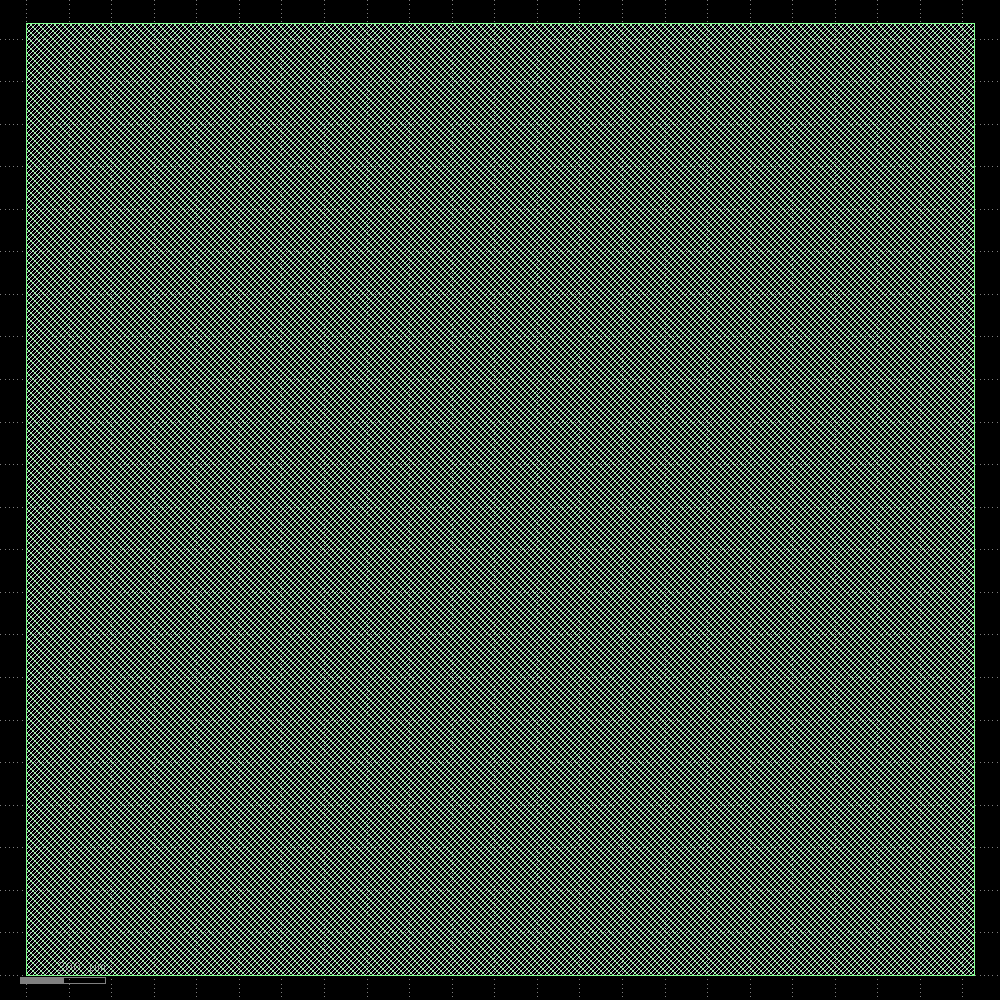

In [ ]:
display(floorplan)

### Tap/Endcap Cell Insertion

This places two kinds of cells on the floorplan:

* End cap/boundary cells: Added at the beginning and end of each row. True to
  their name, they "cap off" the core area of a design.
* Tap cells: Placed in a polka dot-ish fashion across the rows. Tap cells
  connect VDD to the nwell and the psubstrate to VSS, which the majority of cells
  do not do themselves to save area- but if you go long enough without one such
  connection you end up with the cell "latching-up"; i.e.; refusing to switch
  back to LO from HI.

  There is a maximum distance between tap cells enforced as part of every
  foundry process.

In [ ]:
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion(state_in=floorplan.state_out)
tdi.start()

─────────────────────────────────────────────── Tap/Decap Insertion ───────────────────────────────────────────────

[14:28:44] VERBOSE  Running 'OpenROAD.TapEndcapInsertion'…                                             ]8;id=228532;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=8122;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:28:44] VERBOSE  Logging subprocess to                                                              ]8;id=96183;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=204802;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=439864;file:///content/openlane_run/3-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\openlane_run/]8;;\]8;id=889095;file:///content/openlane_run/3-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\3]8;;\]8;id=439864;file:///content/openlane_run/3-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log]8;;\…                    

Reading OpenROAD database at '/content/openlane_run/2-openroad-floorplan/sparse_cnn_accelerator_single.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 3

[INFO] Setting input delay to: 3

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO TAP-0004] Inserted 1628 endcaps.

[INFO TAP-0005] Inserted 69768 tapcells.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to                                                                                       
'/content/openlane_run/3-openroad-tapendcapinsertion/sparse_cnn_accelerator_single.odb'…

Writing netlist to '/content/openlane_run/3-openroad-tapendcapinsertion/sparse_cnn_accelerator_single.nl.v'…

Writing powered netlist to                                                                                         
'/content/openlane_run/3-openroad-tapendcapinsertion/sparse_cnn_accelerator_single.pnl.v'…

Writing layout to '/content/openlane_run/3-openroad-tapendcapinsertion/sparse_cnn_accelerator_single.def'…

Writing timing constraints to                                                                                      
'/content/openlane_run/3-openroad-tapendcapinsertion/sparse_cnn_accelerator_single.sdc'…

{'nl': Path('/content/openlane_run/3-openroad-tapendcapinsertion/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/3-openroad-tapendcapinsertion/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/3-openroad-tapendcapinsertion/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/3-openroad-tapendcapinsertion/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/3-openroad-tapendcapinsertion/sparse_cnn_accelerator_single.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72614, 'design__instance__area': 116746, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 142, 'design__die__area': Decimal('4.98157E+6'), 'design__core__area': Decimal('4.90498E+6'), 'design__instance__count__stdcell': 72614, 'design__instance__area__stdcell': 116746, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.0238014'), 'design__instance__utilization__stdcell': Decimal('0.0238014')}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[14:28:50] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=496873;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=940726;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:28:50] VERBOSE  Logging subprocess to ]8;id=810039;file:///tmp/openlane_klayout_tmp_5y63wfb4/klayout-render.log\..]8;;\]8;id=415966;file:///tmp/openlane_klayout_tmp_5y63wfb4/klayout-render.log\/tmp/openlane_klayout_tmp_5y63wfb4/]8;;\]8;id=743185;file:///tmp/openlane_klayout_tmp_5y63wfb4/klayout-render.log\klayout-render.log]8;;\…     ]8;id=728680;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=871141;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 5.56s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
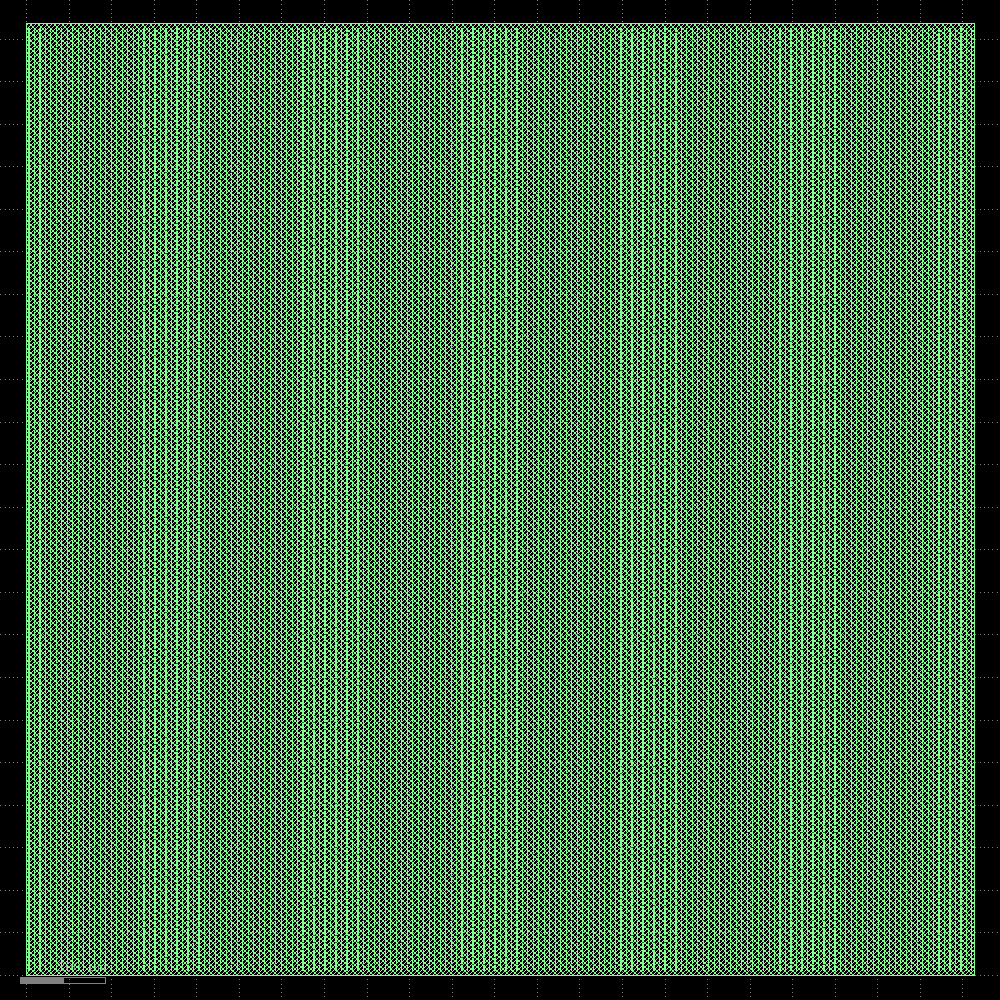

In [ ]:
display(tdi)

### I/O Placement

This places metal pins at the edges of the design corresponding to the top level
inputs and outputs for your design. These pins act as the interface with other
designs when you integrate it with other designs.

In [ ]:
IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement(state_in=tdi.state_out)
ioplace.start()

────────────────────────────────────────────────── I/O Placement ──────────────────────────────────────────────────

[14:28:53] VERBOSE  Running 'OpenROAD.IOPlacement'…                                                    ]8;id=864904;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=398982;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:28:53] VERBOSE  Logging subprocess to                                                              ]8;id=252078;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=578724;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=486601;file:///content/openlane_run/4-openroad-ioplacement/openroad-ioplacement.log\openlane_run/]8;;\]8;id=666329;file:///content/openlane_run/4-openroad-ioplacement/openroad-ioplacement.log\4]8;;\]8;id=486601;file:///content/openlane_run/4-openroad-ioplacement/openroad-ioplacement.log\-openroad-ioplacement/openroad-ioplacement.log]8;;\…                                  

Reading OpenROAD database at                                                                                       
'/content/openlane_run/3-openroad-tapendcapinsertion/sparse_cnn_accelerator_single.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 3

[INFO] Setting input delay to: 3

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] place_pins args: -min_distance 3

Found 0 macro blocks.

[INFO PPL-0010] Tentative 0 to set up sections.

[INFO PPL-0001] Number of slots           2700

[INFO PPL-0002] Number of I/O             142

[INFO PPL-0003] Number of I/O w/sink      142

[INFO PPL-0004] Number of I/O w/o sink    0

[INFO PPL-0005] Slots per section         200

[INFO PPL-0006] Slots increase factor     0.01

[INFO PPL-0008] Successfully assigned pins to sections.

[INFO PPL-0012] I/O nets HPWL: 175227.30 um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/4-openroad-ioplacement/sparse_cnn_accelerator_single.odb'…

Writing netlist to '/content/openlane_run/4-openroad-ioplacement/sparse_cnn_accelerator_single.nl.v'…

Writing powered netlist to '/content/openlane_run/4-openroad-ioplacement/sparse_cnn_accelerator_single.pnl.v'…

Writing layout to '/content/openlane_run/4-openroad-ioplacement/sparse_cnn_accelerator_single.def'…

Writing timing constraints to '/content/openlane_run/4-openroad-ioplacement/sparse_cnn_accelerator_single.sdc'…

{'nl': Path('/content/openlane_run/4-openroad-ioplacement/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/4-openroad-ioplacement/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/4-openroad-ioplacement/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/4-openroad-ioplacement/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/4-openroad-ioplacement/sparse_cnn_accelerator_single.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72614, 'design__instance__area': 116746, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 142, 'design__die__area': Decimal('4.98157E+6'), 'design__core__area': Decimal('4.90498E+6'), 'design__instance__count__stdcell': 72614, 'design__instance__area__stdcell': 116746, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.0238014'), 'design__instance__utilization__stdcell': Decimal('0.0238014'), 'floorplan__design__io': 142, 'design__io__hpwl': 175227290}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[14:28:57] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=680791;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=140637;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:28:57] VERBOSE  Logging subprocess to ]8;id=830254;file:///tmp/openlane_klayout_tmp_n5koaxqi/klayout-render.log\..]8;;\]8;id=554651;file:///tmp/openlane_klayout_tmp_n5koaxqi/klayout-render.log\/tmp/openlane_klayout_tmp_n5koaxqi/]8;;\]8;id=43671;file:///tmp/openlane_klayout_tmp_n5koaxqi/klayout-render.log\klayout-render.log]8;;\…     ]8;id=568751;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=440694;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 3.84s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
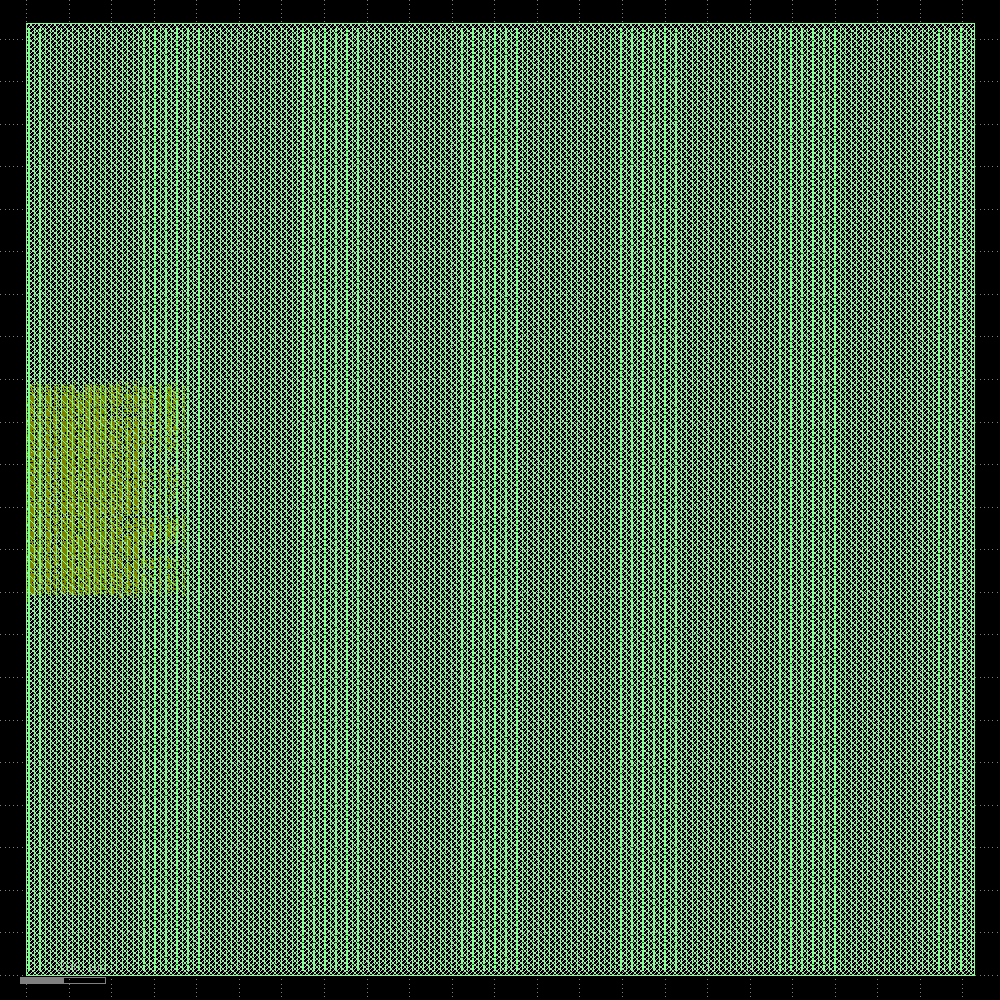

In [ ]:
display(ioplace)

### Generating the Power Distribution Network (PDN)

This creates the power distribution network for your design, which is essentially
a plaid pattern of horizontal and vertical "straps" across the design that is
then connected to the rails' VDD and VSS (via the tap cells.)

You can find an explanation of how the power distribution network works at this
link: https://openlane2.readthedocs.io/en/latest/usage/hardening_macros.html#pdn-generation

While we typically don't need to mess with the PDN too much, the SPM is a small
design, so we're going to need to make the plaid pattern formed by the PDN a bit
smaller.

In [ ]:
GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN(
    state_in=ioplace.state_out,
    FP_PDN_VWIDTH=2,
    FP_PDN_HWIDTH=2,
    FP_PDN_VPITCH=30,
    FP_PDN_HPITCH=30,
)
pdn.start()

────────────────────────────────────── Power Distribution Network Generation ──────────────────────────────────────

[14:29:00] VERBOSE  Running 'OpenROAD.GeneratePDN'…                                                    ]8;id=657079;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=894659;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:29:00] INFO     'FP_PDN_CFG' not explicitly set, setting it to                                 ]8;id=468232;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=278787;file:///content/openlane_ipynb/openlane/steps/openroad.py#1174\1174]8;;\
                    /content/openlane_ipynb/openlane/scripts/openroad/common/pdn_cfg.tcl…                          

[14:29:00] VERBOSE  Logging subprocess to                                                              ]8;id=773960;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=869931;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=574238;file:///content/openlane_run/5-openroad-generatepdn/openroad-generatepdn.log\openlane_run/]8;;\]8;id=722895;file:///content/openlane_run/5-openroad-generatepdn/openroad-generatepdn.log\5]8;;\]8;id=574238;file:///content/openlane_run/5-openroad-generatepdn/openroad-generatepdn.log\-openroad-generatepdn/openroad-generatepdn.log]8;;\…                                  

Reading OpenROAD database at '/content/openlane_run/4-openroad-ioplacement/sparse_cnn_accelerator_single.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 3

[INFO] Setting input delay to: 3

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting global connections...

[INFO PDN-0001] Inserting grid: stdcell_grid

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/5-openroad-generatepdn/sparse_cnn_accelerator_single.odb'…

Writing netlist to '/content/openlane_run/5-openroad-generatepdn/sparse_cnn_accelerator_single.nl.v'…

Writing powered netlist to '/content/openlane_run/5-openroad-generatepdn/sparse_cnn_accelerator_single.pnl.v'…

Writing layout to '/content/openlane_run/5-openroad-generatepdn/sparse_cnn_accelerator_single.def'…

Writing timing constraints to '/content/openlane_run/5-openroad-generatepdn/sparse_cnn_accelerator_single.sdc'…

[INFO PSM-0040] All shapes on net VPWR are connected.

[INFO PSM-0040] All shapes on net VGND are connected.

{'nl': Path('/content/openlane_run/5-openroad-generatepdn/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/5-openroad-generatepdn/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/5-openroad-generatepdn/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/5-openroad-generatepdn/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/5-openroad-generatepdn/sparse_cnn_accelerator_single.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72614, 'design__instance__area': 116746, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 144, 'design__die__area': Decimal('4.98157E+6'), 'design__core__area': Decimal('4.90498E+6'), 'design__instance__count__stdcell': 72614, 'design__instance__area__stdcell': 116746, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.0238014'), 'design__instance__utilization__stdcell': Decimal('0.0238014'), 'floorplan__design__io': 142, 'design__io__hpwl': 175227290, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[14:29:21] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=410989;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=236635;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:29:21] VERBOSE  Logging subprocess to ]8;id=369755;file:///tmp/openlane_klayout_tmp_e_yglonw/klayout-render.log\..]8;;\]8;id=790160;file:///tmp/openlane_klayout_tmp_e_yglonw/klayout-render.log\/tmp/openlane_klayout_tmp_e_yglonw/]8;;\]8;id=153190;file:///tmp/openlane_klayout_tmp_e_yglonw/klayout-render.log\klayout-render.log]8;;\…     ]8;id=511655;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=460099;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 20.69s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
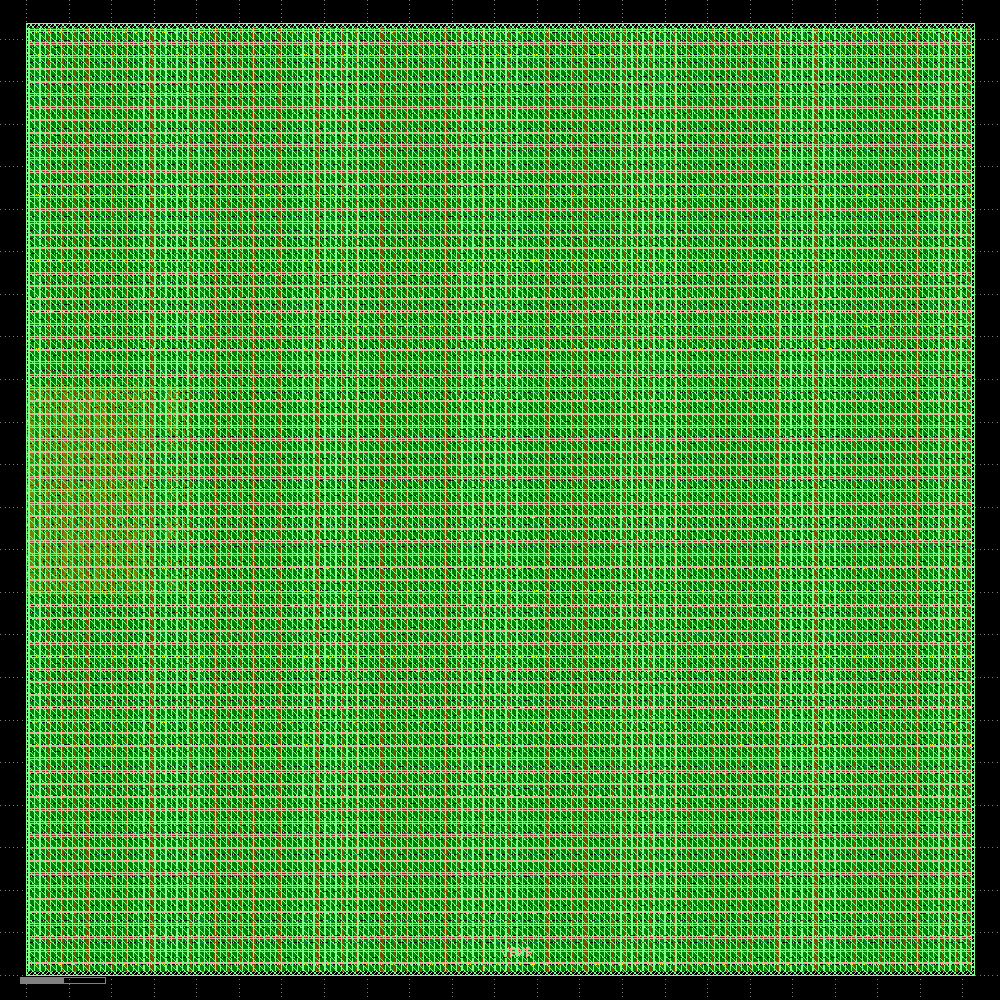

In [ ]:
display(pdn)

### Global Placement

Global Placement is deciding on a fuzzy, non-final location for each of the cells,
with the aim of minimizing the distance between cells that are connected
together (more specifically, the total length of the not-yet-created wires that
will connect them).

As you will see in the `.display()` in the second cell below, the placement is
considered "illegal", i.e., not properly aligned with the cell placement grid.
This is addressed by "Detailed Placement", also referred to as "placement
legalization", which is the next step.

In [ ]:
GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement(state_in=pdn.state_out)
gpl.start()

──────────────────────────────────────────────── Global Placement ─────────────────────────────────────────────────

[14:29:28] VERBOSE  Running 'OpenROAD.GlobalPlacement'…                                                ]8;id=592608;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=242565;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:29:28] INFO     'PL_TARGET_DENSITY_PCT' not explicitly set, using dynamically calculated       ]8;id=353990;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=960471;file:///content/openlane_ipynb/openlane/steps/openroad.py#1260\1260]8;;\
                    target density: 12.3801400…                                                                    

[14:29:28] VERBOSE  Logging subprocess to                                                              ]8;id=753961;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=346589;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=450828;file:///content/openlane_run/6-openroad-globalplacement/openroad-globalplacement.log\openlane_run/]8;;\]8;id=668941;file:///content/openlane_run/6-openroad-globalplacement/openroad-globalplacement.log\6]8;;\]8;id=450828;file:///content/openlane_run/6-openroad-globalplacement/openroad-globalplacement.log\-openroad-globalplacement/openroad-globalplacement.log]8;;\…                          

Reading OpenROAD database at '/content/openlane_run/5-openroad-generatepdn/sparse_cnn_accelerator_single.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 3

[INFO] Setting input delay to: 3

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

[INFO GPL-0002] DBU: 1000

[INFO GPL-0003] SiteSize: (  0.460  2.720 ) um

[INFO GPL-0004] CoreBBox: (  5.520 10.880 ) ( 2220.880 2224.960 ) um

[INFO GPL-0006] NumInstances:             74242

[INFO GPL-0007] NumPlaceInstances:         2846

[INFO GPL-0008] NumFixedInstances:        71396

[INFO GPL-0009] NumDummyInstances:            0

[INFO GPL-0010] NumNets:                   2969

[INFO GPL-0011] NumPins:                  11286

[INFO GPL-0012] DieBBox:  (  0.000  0.000 ) ( 2226.590 2237.310 ) um

[INFO GPL-0013] CoreBBox: (  5.520 10.880 ) ( 2220.880 2224.960 ) um

[INFO GPL-0016] CoreArea:            4904984.269 um^2

[INFO GPL-0017] NonPlaceInstsArea:    93404.582 um^2

[INFO GPL-0018] PlaceInstsArea:       29451.997 um^2

[INFO GPL-0019] Util:                     0.612 %

[INFO GPL-0020] StdInstsArea:         29451.997 um^2

[INFO GPL-0021] MacroInstsArea:           0.000 um^2

[InitialPlace]  Iter: 1 CG residual: 0.00004772 HPWL: 181124220

[InitialPlace]  Iter: 2 CG residual: 0.00000027 HPWL: 42782789

[InitialPlace]  Iter: 3 CG residual: 0.00000012 HPWL: 42168701

[InitialPlace]  Iter: 4 CG residual: 0.00000011 HPWL: 42216107

[InitialPlace]  Iter: 5 CG residual: 0.00000010 HPWL: 42074696

[INFO GPL-0031] FillerInit:NumGCells:     58911

[INFO GPL-0032] FillerInit:NumGNets:       2969

[INFO GPL-0033] FillerInit:NumGPins:      11286

[INFO GPL-0023] TargetDensity:            0.124

[INFO GPL-0024] AvrgPlaceInstArea:       10.349 um^2

[INFO GPL-0025] IdealBinArea:            83.590 um^2

[INFO GPL-0026] IdealBinCnt:              58679

[INFO GPL-0027] TotalBinArea:        4904984.269 um^2

[INFO GPL-0028] BinCnt:       128    128

[INFO GPL-0029] BinSize: ( 17.308 17.298 )

[INFO GPL-0030] NumBins: 16384

[NesterovSolve] Iter:    1 overflow: 0.989 HPWL: 28217430

[NesterovSolve] Iter:   10 overflow: 0.967 HPWL: 33679088

[NesterovSolve] Iter:   20 overflow: 0.967 HPWL: 34435908

[NesterovSolve] Iter:   30 overflow: 0.966 HPWL: 34537913

[NesterovSolve] Iter:   40 overflow: 0.966 HPWL: 34388726

[NesterovSolve] Iter:   50 overflow: 0.966 HPWL: 34387894

[NesterovSolve] Iter:   60 overflow: 0.966 HPWL: 34431301

[NesterovSolve] Iter:   70 overflow: 0.966 HPWL: 34431256

[NesterovSolve] Iter:   80 overflow: 0.966 HPWL: 34421694

[NesterovSolve] Iter:   90 overflow: 0.966 HPWL: 34449551

[NesterovSolve] Iter:  100 overflow: 0.966 HPWL: 34483356

[NesterovSolve] Iter:  110 overflow: 0.966 HPWL: 34500832

[NesterovSolve] Iter:  120 overflow: 0.966 HPWL: 34537273

[NesterovSolve] Iter:  130 overflow: 0.966 HPWL: 34643483

[NesterovSolve] Iter:  140 overflow: 0.966 HPWL: 34855632

[NesterovSolve] Iter:  150 overflow: 0.965 HPWL: 35242362

[NesterovSolve] Iter:  160 overflow: 0.963 HPWL: 35913035

[NesterovSolve] Iter:  170 overflow: 0.960 HPWL: 37124822

[NesterovSolve] Iter:  180 overflow: 0.953 HPWL: 39319252

[NesterovSolve] Iter:  190 overflow: 0.946 HPWL: 42858458

[NesterovSolve] Iter:  200 overflow: 0.936 HPWL: 47795862

[NesterovSolve] Iter:  210 overflow: 0.921 HPWL: 53548275

[NesterovSolve] Iter:  220 overflow: 0.901 HPWL: 59400880

[NesterovSolve] Iter:  230 overflow: 0.878 HPWL: 64687662

[NesterovSolve] Iter:  240 overflow: 0.848 HPWL: 70061681

[NesterovSolve] Iter:  250 overflow: 0.813 HPWL: 78485912

[INFO GPL-0100] worst slack 8.63e-09

[INFO GPL-0103] Weighted 294 nets.

[NesterovSolve] Iter:  260 overflow: 0.783 HPWL: 85313236

[NesterovSolve] Iter:  270 overflow: 0.749 HPWL: 90273482

[NesterovSolve] Iter:  280 overflow: 0.713 HPWL: 99126434

[NesterovSolve] Iter:  290 overflow: 0.667 HPWL: 106925813

[INFO GPL-0100] worst slack 8.6e-09

[INFO GPL-0103] Weighted 282 nets.

[NesterovSolve] Iter:  300 overflow: 0.624 HPWL: 114084918

[NesterovSolve] Snapshot saved at iter = 307

[NesterovSolve] Iter:  310 overflow: 0.587 HPWL: 120746264

[NesterovSolve] Iter:  320 overflow: 0.541 HPWL: 128402579

[NesterovSolve] Iter:  330 overflow: 0.500 HPWL: 134423388

[INFO GPL-0100] worst slack 8.45e-09

[INFO GPL-0103] Weighted 293 nets.

[NesterovSolve] Iter:  340 overflow: 0.452 HPWL: 139437499

[NesterovSolve] Iter:  350 overflow: 0.410 HPWL: 142386740

[NesterovSolve] Iter:  360 overflow: 0.364 HPWL: 144245028

[NesterovSolve] Iter:  370 overflow: 0.321 HPWL: 146578810

[NesterovSolve] Iter:  380 overflow: 0.292 HPWL: 148330090

[INFO GPL-0100] worst slack 8.14e-09

[INFO GPL-0103] Weighted 295 nets.

[NesterovSolve] Iter:  390 overflow: 0.253 HPWL: 151237940

[NesterovSolve] Iter:  400 overflow: 0.218 HPWL: 154936411

[INFO GPL-0100] worst slack 7.89e-09

[INFO GPL-0103] Weighted 294 nets.

[INFO GPL-0075] Routability numCall: 1 inflationIterCnt: 1 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:     322  324

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 104328

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 1.9000000953674316

[INFO GPL-0065] OverflowTileCnt2: 11

[INFO GPL-0066] 0.5%RC: 0.7958

[INFO GPL-0067] 1.0%RC: 0.7221

[INFO GPL-0068] 2.0%RC: 0.6944

[INFO GPL-0069] 5.0%RC: 0.6778

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 0.7590

[INFO GPL-0077] FinalRC lower than targetRC(1), routability not needed.

[NesterovSolve] Iter:  410 overflow: 0.188 HPWL: 157341669

[NesterovSolve] Iter:  420 overflow: 0.161 HPWL: 159264341

[INFO GPL-0100] worst slack 8.37e-09

[INFO GPL-0103] Weighted 295 nets.

[NesterovSolve] Iter:  430 overflow: 0.133 HPWL: 160637386

[NesterovSolve] Iter:  440 overflow: 0.113 HPWL: 161990252

[NesterovSolve] Finished with Overflow: 0.098703

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/6-openroad-globalplacement/sparse_cnn_accelerator_single.odb'…

Writing netlist to '/content/openlane_run/6-openroad-globalplacement/sparse_cnn_accelerator_single.nl.v'…

Writing powered netlist to '/content/openlane_run/6-openroad-globalplacement/sparse_cnn_accelerator_single.pnl.v'…

Writing layout to '/content/openlane_run/6-openroad-globalplacement/sparse_cnn_accelerator_single.def'…

Writing timing constraints to '/content/openlane_run/6-openroad-globalplacement/sparse_cnn_accelerator_single.sdc'…

{'nl': Path('/content/openlane_run/6-openroad-globalplacement/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/6-openroad-globalplacement/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/6-openroad-globalplacement/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/6-openroad-globalplacement/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/6-openroad-globalplacement/sparse_cnn_accelerator_single.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72614, 'design__instance__area': 116746, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 144, 'design__die__area': Decimal('4.98157E+6'), 'design__core__area': Decimal('4.90498E+6'), 'design__instance__count__stdcell': 72614, 'design__instance__area__stdcell': 116746, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.0238014'), 'design__instance__utilization__stdcell': Decimal('0.0238014'), 'floorplan__design__io': 142, 'design__io__hpwl': 175227290, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[14:29:57] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=205921;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=117356;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:29:57] VERBOSE  Logging subprocess to ]8;id=928918;file:///tmp/openlane_klayout_tmp_m8iucd53/klayout-render.log\..]8;;\]8;id=972314;file:///tmp/openlane_klayout_tmp_m8iucd53/klayout-render.log\/tmp/openlane_klayout_tmp_m8iucd53/]8;;\]8;id=716351;file:///tmp/openlane_klayout_tmp_m8iucd53/klayout-render.log\klayout-render.log]8;;\…     ]8;id=500007;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=222715;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 28.70s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
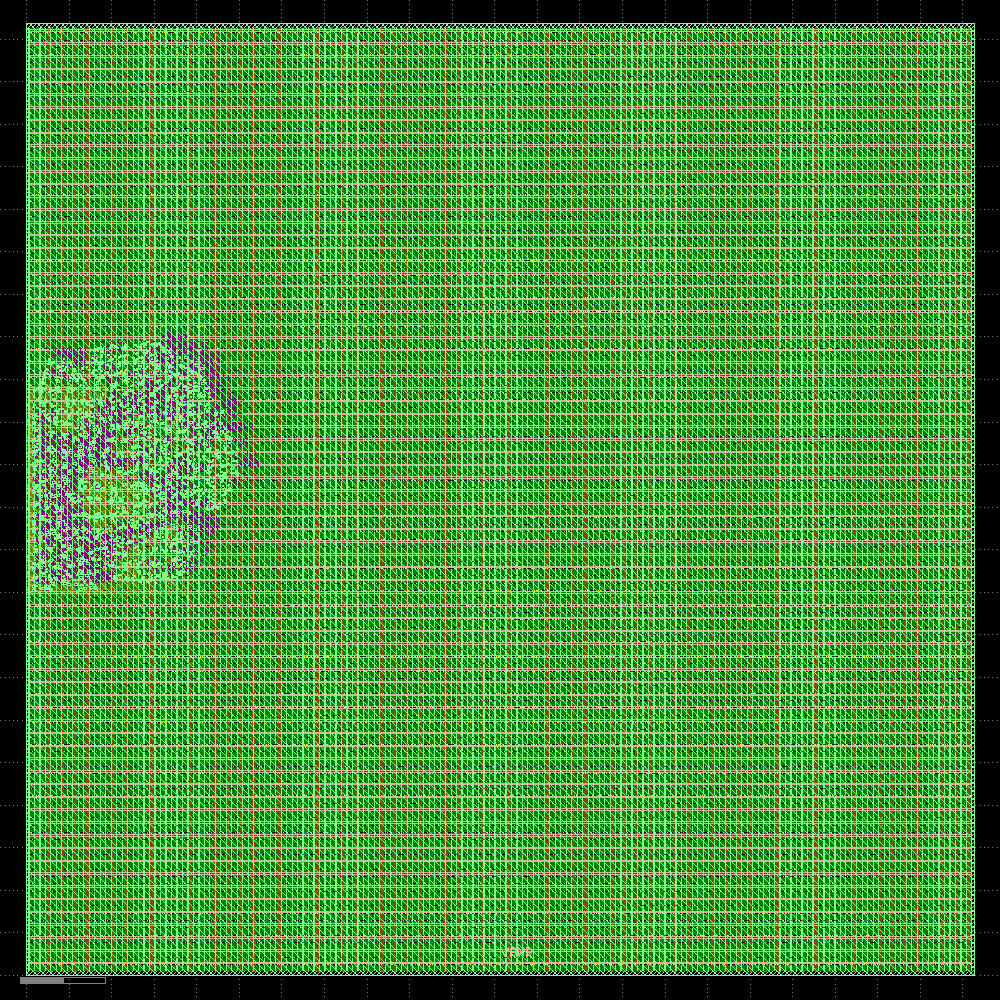

In [ ]:
display(gpl)

### Detailed Placement

This aligns the fuzzy placement from before with the grid, "legalizing" it.

In [ ]:
DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement(state_in=gpl.state_out)
dpl.start()

─────────────────────────────────────────────── Detailed Placement ────────────────────────────────────────────────

[14:30:03] VERBOSE  Running 'OpenROAD.DetailedPlacement'…                                              ]8;id=625496;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=161268;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:30:03] VERBOSE  Logging subprocess to                                                              ]8;id=639417;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=935815;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=439311;file:///content/openlane_run/7-openroad-detailedplacement/openroad-detailedplacement.log\openlane_run/]8;;\]8;id=204214;file:///content/openlane_run/7-openroad-detailedplacement/openroad-detailedplacement.log\7]8;;\]8;id=439311;file:///content/openlane_run/7-openroad-detailedplacement/openroad-detailedplacement.log\-openroad-detailedplacement/openroad-detailedplacement.log]8;;\…                      

Reading OpenROAD database at '/content/openlane_run/6-openroad-globalplacement/sparse_cnn_accelerator_single.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 3

[INFO] Setting input delay to: 3

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Placement Analysis

---------------------------------

total displacement       4514.3 u

average displacement        0.1 u

max displacement            9.5 u

original HPWL          163301.6 u

legalized HPWL         165298.2 u

delta HPWL                    1 %

[INFO DPL-0020] Mirrored 1274 instances

[INFO DPL-0021] HPWL before          165298.2 u

[INFO DPL-0022] HPWL after           162440.7 u

[INFO DPL-0023] HPWL delta               -1.7 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to                                                                                       
'/content/openlane_run/7-openroad-detailedplacement/sparse_cnn_accelerator_single.odb'…

Writing netlist to '/content/openlane_run/7-openroad-detailedplacement/sparse_cnn_accelerator_single.nl.v'…

Writing powered netlist to                                                                                         
'/content/openlane_run/7-openroad-detailedplacement/sparse_cnn_accelerator_single.pnl.v'…

Writing layout to '/content/openlane_run/7-openroad-detailedplacement/sparse_cnn_accelerator_single.def'…

Writing timing constraints to                                                                                      
'/content/openlane_run/7-openroad-detailedplacement/sparse_cnn_accelerator_single.sdc'…

{'nl': Path('/content/openlane_run/7-openroad-detailedplacement/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/7-openroad-detailedplacement/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/7-openroad-detailedplacement/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/7-openroad-detailedplacement/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/7-openroad-detailedplacement/sparse_cnn_accelerator_single.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72614, 'design__instance__area': 116746, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 144, 'design__die__area': Decimal('4.98157E+6'), 'design__core__area': Decimal('4.90498E+6'), 'design__instance__count__stdcell': 72614, 'design__instance__area__stdcell': 116746, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.0238014'), 'design__instance__utilization__stdcell': Decimal('0.0238014'), 'floorplan__design__io': 142, 'design__io__hpwl': 175227290, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('4514.32'), 'design__instance__displacement__mean': Decimal('0.06'), 'design__instance__displacement__max': Decimal('9.533'), 'route__wirelength__estimated': 165298, 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[14:30:09] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=851353;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=268472;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:30:09] VERBOSE  Logging subprocess to ]8;id=264314;file:///tmp/openlane_klayout_tmp_x5jmrzw4/klayout-render.log\..]8;;\]8;id=975556;file:///tmp/openlane_klayout_tmp_x5jmrzw4/klayout-render.log\/tmp/openlane_klayout_tmp_x5jmrzw4/]8;;\]8;id=300351;file:///tmp/openlane_klayout_tmp_x5jmrzw4/klayout-render.log\klayout-render.log]8;;\…     ]8;id=623584;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=297337;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 6.47s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
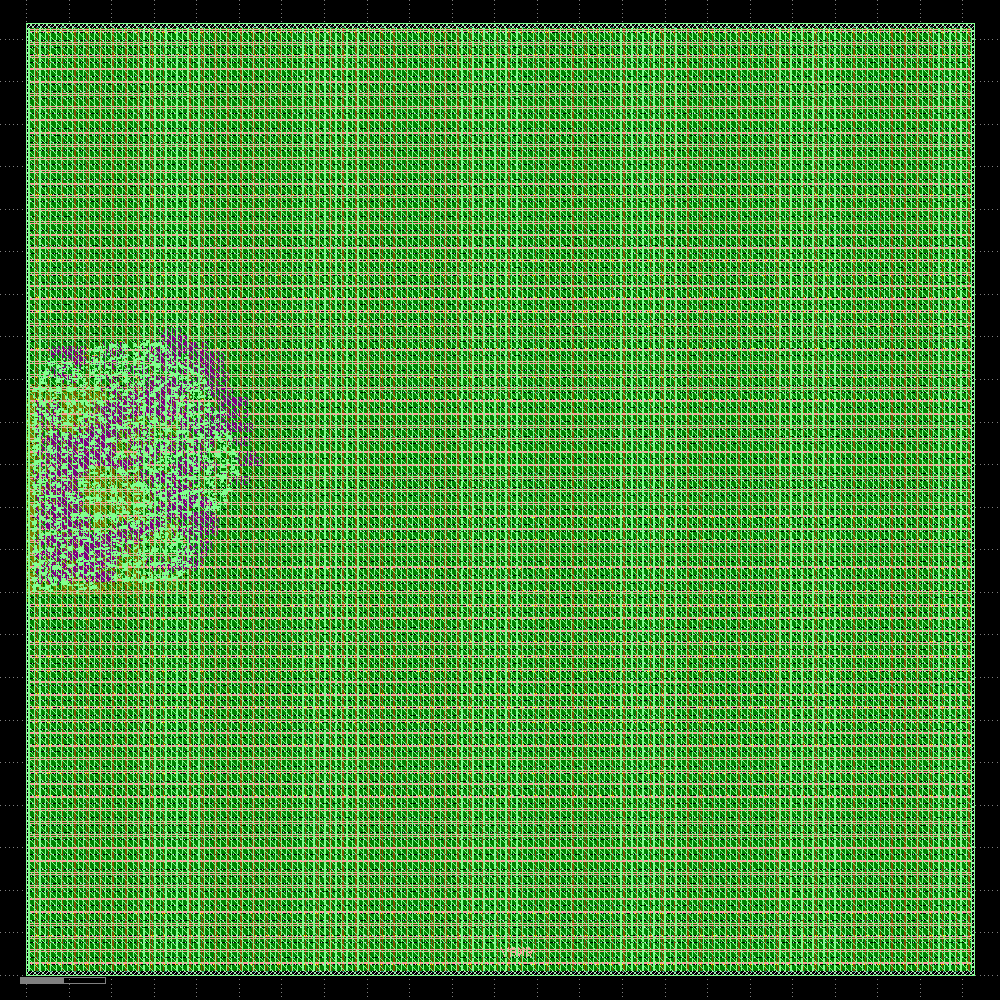

In [ ]:
display(dpl)

### Clock Tree Synthesis (CTS)

With the cells now having a final placement, we can go ahead and create what
is known as the clock tree, i.e., the hierarchical set of buffers used
for clock signal to minimize what is known as "clock skew"- variable delay
of the clock cycle from register to register because of factors such as metal
wire length, clock load (number of gates connected to the same clock buffer,)
et cetera.

The CTS step creates the cells and places the between the gaps in the detailed
placement above.

In [ ]:
CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS(state_in=dpl.state_out)
cts.start()

────────────────────────────────────────────── Clock Tree Synthesis ───────────────────────────────────────────────

[14:30:16] VERBOSE  Running 'OpenROAD.CTS'…                                                            ]8;id=805996;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=281489;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:30:16] VERBOSE  Logging subprocess to ]8;id=396107;file:///content/openlane_run/8-openroad-cts/openroad-cts.log\openlane_run/]8;;\]8;id=113709;file:///content/openlane_run/8-openroad-cts/openroad-cts.log\8]8;;\]8;id=396107;file:///content/openlane_run/8-openroad-cts/openroad-cts.log\-openroad-cts/openroad-cts.log]8;;\…                ]8;id=356404;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=519355;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading timing models for corner nom_tt_025C_1v80…

Reading timing library for the 'nom_tt_025C_1v80' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading timing models for corner nom_ff_n40C_1v95…

Reading timing library for the 'nom_ff_n40C_1v95' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib'…

Reading timing models for corner nom_ss_100C_1v60…

Reading timing library for the 'nom_ss_100C_1v60' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib'…

Reading OpenROAD database at                                                                                       
'/content/openlane_run/7-openroad-detailedplacement/sparse_cnn_accelerator_single.odb'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 3

[INFO] Setting input delay to: 3

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Configuring cts characterization…

[INFO] Performing clock tree synthesis…

[INFO] Looking for the following net(s): clk

[INFO] Running Clock Tree Synthesis…

[INFO CTS-0050] Root buffer is sky130_fd_sc_hd__clkbuf_16.

[INFO CTS-0051] Sink buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0052] The following clock buffers will be used for CTS:

sky130_fd_sc_hd__clkbuf_2

sky130_fd_sc_hd__clkbuf_4

sky130_fd_sc_hd__clkbuf_8

[INFO CTS-0049] Characterization buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0007] Net "clk" found for clock "clk".

[INFO CTS-0010]  Clock net "clk" has 239 sinks.

[INFO CTS-0010]  Clock net "blk_mac.mac0.gated_clk" has 17 sinks.

[INFO CTS-0010]  Clock net "blk_mac.mac1.gated_clk" has 17 sinks.

[INFO CTS-0010]  Clock net "blk_mac.mac2.gated_clk" has 17 sinks.

[INFO CTS-0010]  Clock net "blk_mac.mac3.gated_clk" has 17 sinks.

[INFO CTS-0008] TritonCTS found 5 clock nets.

[INFO CTS-0097] Characterization used 3 buffer(s) types.

[INFO CTS-0200] 0 placement blockages have been identified.

[INFO CTS-0201] 0 placed hard macros will be treated like blockages.

[INFO CTS-0027] Generating H-Tree topology for net clk.

[INFO CTS-0028]  Total number of sinks: 239.

[INFO CTS-0029]  Sinks will be clustered in groups of up to 25 and with maximum cluster diameter of 50.0 um.

[INFO CTS-0030]  Number of static layers: 0.

[INFO CTS-0020]  Wire segment unit: 13600  dbu (13 um).

[INFO CTS-0204] A clustering solution was found from clustering size of 25 and clustering diameter of 50.

[INFO CTS-0205] Better solution may be possible if either -sink_clustering_size, -sink_clustering_max_diameter, or 
both options are omitted to enable automatic clustering.

[INFO CTS-0019]  Total number of sinks after clustering: 53.

[INFO CTS-0024]  Normalized sink region: [(1.12831, 66.7809), (27.3151, 99.6478)].

[INFO CTS-0025]     Width:  26.1868.

[INFO CTS-0026]     Height: 32.8669.

Level 1

Direction: Vertical

Sinks per sub-region: 27

Sub-region size: 26.1868 X 16.4335

[INFO CTS-0034]     Segment length (rounded): 8.

Level 2

Direction: Horizontal

Sinks per sub-region: 14

Sub-region size: 13.0934 X 16.4335

[INFO CTS-0034]     Segment length (rounded): 6.

[INFO CTS-0032]  Stop criterion found. Max number of sinks is 15.

[INFO CTS-0035]  Number of sinks covered: 53.

[INFO CTS-0200] 0 placement blockages have been identified.

[INFO CTS-0201] 0 placed hard macros will be treated like blockages.

[INFO CTS-0027] Generating H-Tree topology for net blk_mac.mac0.gated_clk.

[INFO CTS-0028]  Total number of sinks: 17.

[INFO CTS-0029]  Sinks will be clustered in groups of up to 25 and with maximum cluster diameter of 50.0 um.

[INFO CTS-0030]  Number of static layers: 0.

[INFO CTS-0020]  Wire segment unit: 13600  dbu (13 um).

[INFO CTS-0023]  Original sink region: [(179665, 1002260), (397245, 1059500)].

[INFO CTS-0024]  Normalized sink region: [(13.2107, 73.6956), (29.2092, 77.9044)].

[INFO CTS-0025]     Width:  15.9985.

[INFO CTS-0026]     Height: 4.2088.

Level 1

Direction: Horizontal

Sinks per sub-region: 9

Sub-region size: 7.9993 X 4.2088

[INFO CTS-0034]     Segment length (rounded): 4.

[INFO CTS-0032]  Stop criterion found. Max number of sinks is 15.

[INFO CTS-0035]  Number of sinks covered: 17.

[INFO CTS-0200] 0 placement blockages have been identified.

[INFO CTS-0201] 0 placed hard macros will be treated like blockages.

[INFO CTS-0027] Generating H-Tree topology for net blk_mac.mac1.gated_clk.

[INFO CTS-0028]  Total number of sinks: 17.

[INFO CTS-0029]  Sinks will be clustered in groups of up to 25 and with maximum cluster diameter of 50.0 um.

[INFO CTS-0030]  Number of static layers: 0.

[INFO CTS-0020]  Wire segment unit: 13600  dbu (13 um).

[INFO CTS-0023]  Original sink region: [(333695, 1157420), (464335, 1323220)].

[INFO CTS-0024]  Normalized sink region: [(24.5364, 85.1044), (34.1423, 97.2956)].

[INFO CTS-0025]     Width:  9.6059.

[INFO CTS-0026]     Height: 12.1912.

Level 1

Direction: Vertical

Sinks per sub-region: 9

Sub-region size: 9.6059 X 6.0956

[INFO CTS-0034]     Segment length (rounded): 4.

[INFO CTS-0032]  Stop criterion found. Max number of sinks is 15.

[INFO CTS-0035]  Number of sinks covered: 17.

[INFO CTS-0200] 0 placement blockages have been identified.

[INFO CTS-0201] 0 placed hard macros will be treated like blockages.

[INFO CTS-0027] Generating H-Tree topology for net blk_mac.mac2.gated_clk.

[INFO CTS-0028]  Total number of sinks: 17.

[INFO CTS-0029]  Sinks will be clustered in groups of up to 25 and with maximum cluster diameter of 50.0 um.

[INFO CTS-0030]  Number of static layers: 0.

[INFO CTS-0020]  Wire segment unit: 13600  dbu (13 um).

[INFO CTS-0023]  Original sink region: [(121245, 1239020), (306625, 1437460)].

[INFO CTS-0024]  Normalized sink region: [(8.91507, 91.1044), (22.546, 105.696)].

[INFO CTS-0025]     Width:  13.6309.

[INFO CTS-0026]     Height: 14.5912.

Level 1

Direction: Vertical

Sinks per sub-region: 9

Sub-region size: 13.6309 X 7.2956

[INFO CTS-0034]     Segment length (rounded): 4.

[INFO CTS-0032]  Stop criterion found. Max number of sinks is 15.

[INFO CTS-0035]  Number of sinks covered: 17.

[INFO CTS-0200] 0 placement blockages have been identified.

[INFO CTS-0201] 0 placed hard macros will be treated like blockages.

[INFO CTS-0027] Generating H-Tree topology for net blk_mac.mac3.gated_clk.

[INFO CTS-0028]  Total number of sinks: 17.

[INFO CTS-0029]  Sinks will be clustered in groups of up to 25 and with maximum cluster diameter of 50.0 um.

[INFO CTS-0030]  Number of static layers: 0.

[INFO CTS-0020]  Wire segment unit: 13600  dbu (13 um).

[INFO CTS-0023]  Original sink region: [(173685, 1298860), (412885, 1453780)].

[INFO CTS-0024]  Normalized sink region: [(12.771, 95.5044), (30.3592, 106.896)].

[INFO CTS-0025]     Width:  17.5882.

[INFO CTS-0026]     Height: 11.3912.

Level 1

Direction: Horizontal

Sinks per sub-region: 9

Sub-region size: 8.7941 X 11.3912

[INFO CTS-0034]     Segment length (rounded): 4.

[INFO CTS-0032]  Stop criterion found. Max number of sinks is 15.

[INFO CTS-0035]  Number of sinks covered: 17.

[INFO CTS-0018]     Created 52 clock buffers.

[INFO CTS-0012]     Minimum number of buffers in the clock path: 2.

[INFO CTS-0013]     Maximum number of buffers in the clock path: 3.

[INFO CTS-0015]     Created 52 clock nets.

[INFO CTS-0016]     Fanout distribution for the current clock = 2:5, 3:5, 4:12, 5:11, 6:4, 7:4, 8:3, 9:2, 10:2,    
12:1, 16:2..

[INFO CTS-0017]     Max level of the clock tree: 2.

[INFO CTS-0018]     Created 3 clock buffers.

[INFO CTS-0012]     Minimum number of buffers in the clock path: 2.

[INFO CTS-0013]     Maximum number of buffers in the clock path: 2.

[INFO CTS-0015]     Created 3 clock nets.

[INFO CTS-0016]     Fanout distribution for the current clock = 7:1, 10:1..

[INFO CTS-0017]     Max level of the clock tree: 1.

[INFO CTS-0018]     Created 3 clock buffers.

[INFO CTS-0012]     Minimum number of buffers in the clock path: 2.

[INFO CTS-0013]     Maximum number of buffers in the clock path: 2.

[INFO CTS-0015]     Created 3 clock nets.

[INFO CTS-0016]     Fanout distribution for the current clock = 8:1, 9:1..

[INFO CTS-0017]     Max level of the clock tree: 1.

[INFO CTS-0018]     Created 3 clock buffers.

[INFO CTS-0012]     Minimum number of buffers in the clock path: 2.

[INFO CTS-0013]     Maximum number of buffers in the clock path: 2.

[INFO CTS-0015]     Created 3 clock nets.

[INFO CTS-0016]     Fanout distribution for the current clock = 7:1, 10:1..

[INFO CTS-0017]     Max level of the clock tree: 1.

[INFO CTS-0018]     Created 3 clock buffers.

[INFO CTS-0012]     Minimum number of buffers in the clock path: 2.

[INFO CTS-0013]     Maximum number of buffers in the clock path: 2.

[INFO CTS-0015]     Created 3 clock nets.

[INFO CTS-0016]     Fanout distribution for the current clock = 7:1, 10:1..

[INFO CTS-0017]     Max level of the clock tree: 1.

[INFO CTS-0098] Clock net "clk"

[INFO CTS-0099]  Sinks 283

[INFO CTS-0100]  Leaf buffers 47

[INFO CTS-0101]  Average sink wire length 705.35 um

[INFO CTS-0102]  Path depth 2 - 3

[INFO CTS-0207]  Leaf load cells 48

[INFO CTS-0098] Clock net "blk_mac.mac0.gated_clk"

[INFO CTS-0099]  Sinks 18

[INFO CTS-0100]  Leaf buffers 0

[INFO CTS-0101]  Average sink wire length 267.16 um

[INFO CTS-0102]  Path depth 2 - 2

[INFO CTS-0207]  Leaf load cells 48

[INFO CTS-0098] Clock net "blk_mac.mac1.gated_clk"

[INFO CTS-0099]  Sinks 18

[INFO CTS-0100]  Leaf buffers 0

[INFO CTS-0101]  Average sink wire length 261.17 um

[INFO CTS-0102]  Path depth 2 - 2

[INFO CTS-0207]  Leaf load cells 48

[INFO CTS-0098] Clock net "blk_mac.mac2.gated_clk"

[INFO CTS-0099]  Sinks 18

[INFO CTS-0100]  Leaf buffers 0

[INFO CTS-0101]  Average sink wire length 338.33 um

[INFO CTS-0102]  Path depth 2 - 2

[INFO CTS-0207]  Leaf load cells 48

[INFO CTS-0098] Clock net "blk_mac.mac3.gated_clk"

[INFO CTS-0099]  Sinks 18

[INFO CTS-0100]  Leaf buffers 0

[INFO CTS-0101]  Average sink wire length 283.50 um

[INFO CTS-0102]  Path depth 2 - 2

[INFO CTS-0207]  Leaf load cells 48

[INFO] Repairing long wires on clock nets…

[INFO RSZ-0058] Using max wire length 6335um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.odb'…

Writing netlist to '/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.nl.v'…

Writing powered netlist to '/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.pnl.v'…

Writing layout to '/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.def'…

Writing timing constraints to '/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.sdc'…

[INFO] Legalizing…

Placement Analysis

---------------------------------

total displacement        293.5 u

average displacement        0.0 u

max displacement            6.5 u

original HPWL          167160.0 u

legalized HPWL         170130.8 u

delta HPWL                    2 %

[INFO DPL-0020] Mirrored 1295 instances

[INFO DPL-0021] HPWL before          170130.8 u

[INFO DPL-0022] HPWL after           167084.9 u

[INFO DPL-0023] HPWL delta               -1.8 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.odb'…

Writing netlist to '/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.nl.v'…

Writing powered netlist to '/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.pnl.v'…

Writing layout to '/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.def'…

Writing timing constraints to '/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.sdc'…

{'nl': Path('/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72726, 'design__instance__area': 118410, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 33696, 'flow__errors__count': 0, 'design__io': 144, 'design__die__area': Decimal('4.98157E+6'), 'design__core__area': Decimal('4.90498E+6'), 'design__instance__count__stdcell': 72726, 'design__instance__area__stdcell': 118410, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.0241407'), 'design__instance__utilization__stdcell': Decimal('0.0241407'), 'floorplan__design__io': 142, 'design__io__hpwl': 175227290, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('293.538'), 'design__instance__displacement__mean': Decimal('0.003'), 'design__instance__displacement__max': Decimal('6.465'), 'route__wirelength__estimated': 170131, 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[14:30:40] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=210148;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=695716;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:30:40] VERBOSE  Logging subprocess to ]8;id=815695;file:///tmp/openlane_klayout_tmp_76dst9hz/klayout-render.log\..]8;;\]8;id=816684;file:///tmp/openlane_klayout_tmp_76dst9hz/klayout-render.log\/tmp/openlane_klayout_tmp_76dst9hz/]8;;\]8;id=620553;file:///tmp/openlane_klayout_tmp_76dst9hz/klayout-render.log\klayout-render.log]8;;\…     ]8;id=174353;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=290189;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 24.37s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
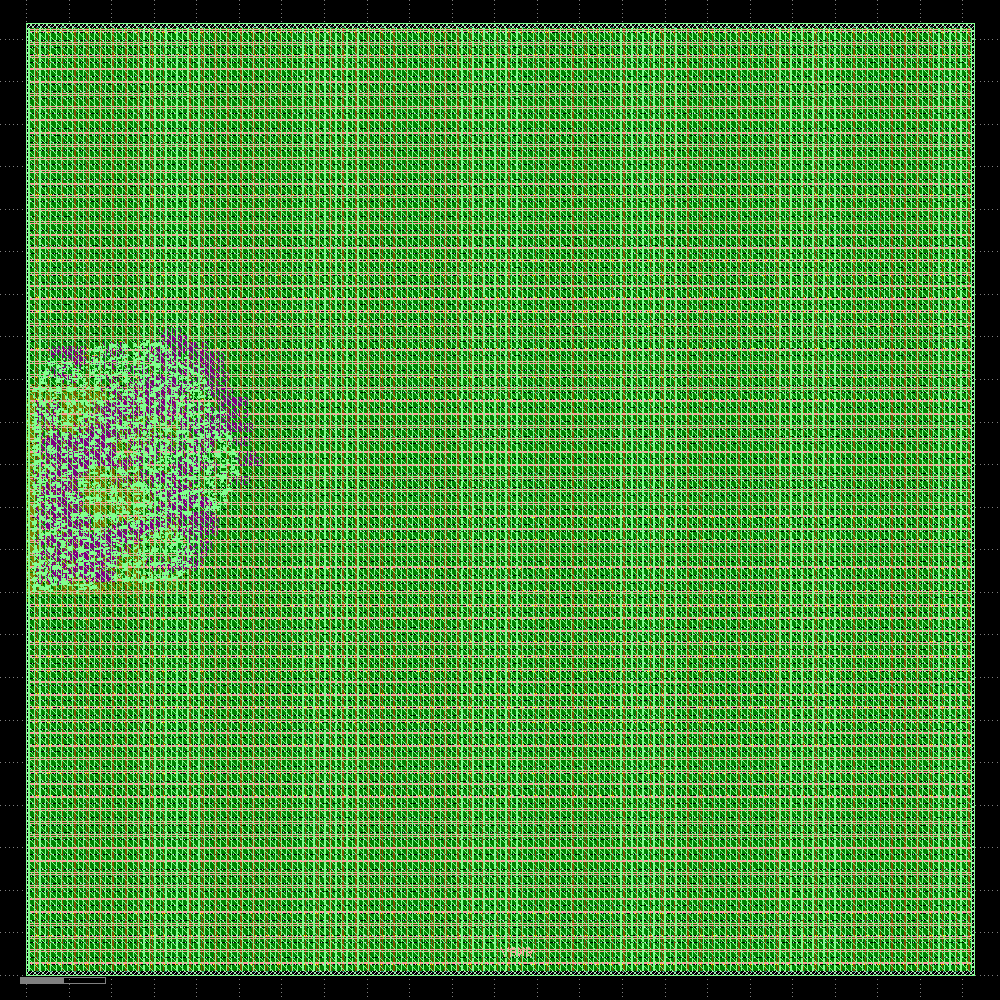

In [ ]:
display(cts)

In [ ]:
from openlane.steps import Step

ResizerTimingPostCTS = Step.factory.get("OpenROAD.ResizerTimingPostCTS")

retiming = ResizerTimingPostCTS(
    state_in=cts.state_out,  # pass previous step's output state directly
    PL_RESIZER_SETUP_SLACK_MARGIN=0.1,
    PL_RESIZER_HOLD_SLACK_MARGIN=0.1,
    PL_RESIZER_HOLD_MAX_BUFFER_PCT=75,
    PL_RESIZER_SETUP_MAX_BUFFER_PCT=75,
    # PL_RESIZER_ALLOW_SETUP_VIOS=1,  # uncomment if needed
)
retiming.start()

──────────────────────────── Resizer Timing Optimizations (Post-Clock Tree Synthesis) ─────────────────────────────

[14:30:46] VERBOSE  Running 'OpenROAD.ResizerTimingPostCTS'…                                           ]8;id=514952;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=124156;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:30:46] VERBOSE  Logging subprocess to                                                              ]8;id=602821;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=920270;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=402389;file:///content/openlane_run/9-openroad-resizertimingpostcts/openroad-resizertimingpostcts.log\openlane_run/]8;;\]8;id=675032;file:///content/openlane_run/9-openroad-resizertimingpostcts/openroad-resizertimingpostcts.log\9]8;;\]8;id=402389;file:///content/openlane_run/9-openroad-resizertimingpostcts/openroad-resizertimingpostcts.log\-openroad-resizertimingpostcts/openroad-resizertimingpostcts.log]8;;\…                

Reading timing models for corner nom_tt_025C_1v80…

Reading timing library for the 'nom_tt_025C_1v80' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading timing models for corner nom_ff_n40C_1v95…

Reading timing library for the 'nom_ff_n40C_1v95' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib'…

Reading timing models for corner nom_ss_100C_1v60…

Reading timing library for the 'nom_ss_100C_1v60' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib'…

Reading OpenROAD database at '/content/openlane_run/8-openroad-cts/sparse_cnn_accelerator_single.odb'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 3

[INFO] Setting input delay to: 3

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO RSZ-0046] Found 46 endpoints with hold violations.

[INFO RSZ-0032] Inserted 42 hold buffers.

Placement Analysis

---------------------------------

total displacement         83.6 u

average displacement        0.0 u

max displacement            4.5 u

original HPWL          167807.6 u

legalized HPWL         170884.5 u

delta HPWL                    2 %

[INFO DPL-0020] Mirrored 1319 instances

[INFO DPL-0021] HPWL before          170884.5 u

[INFO DPL-0022] HPWL after           167758.9 u

[INFO DPL-0023] HPWL delta               -1.8 %

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to                                                                                       
'/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.odb'…

Writing netlist to '/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.nl.v'…

Writing powered netlist to                                                                                         
'/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.pnl.v'…

Writing layout to '/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.def'…

Writing timing constraints to                                                                                      
'/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.sdc'…

{'nl': Path('/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72768, 'design__instance__area': 118830, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 33696, 'flow__errors__count': 0, 'design__io': 144, 'design__die__area': Decimal('4.98157E+6'), 'design__core__area': Decimal('4.90498E+6'), 'design__instance__count__stdcell': 72768, 'design__instance__area__stdcell': 118830, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.0242264'), 'design__instance__utilization__stdcell': Decimal('0.0242264'), 'floorplan__design__io': 142, 'design__io__hpwl': 175227290, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('83.56'), 'design__instance__displacement__mean': Decimal('0.001'), 'design__instance__displacement__max': Decimal('4.528'), 'route__wirelength__estimated': 170884, 'design__violations': 0, 'design__instance__count__setup_buffer': 0, 'design__instance__count__hold_buffer': 42}}

### Global Routing

Global routing "plans" the routes the wires between two gates (or gates and
I/O pins/the PDN) will take. The results of global routing (which are called
"routing guides") are stored in internal data structures and have no effect on
the actual design, so there is no `display()` statement.

In [ ]:
GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting(
    state_in=retiming.state_out,
    ROUTING_STRATEGY=0, # Corresponds to set ::env(ROUTING_STRATEGY) 0
    GRT_ALLOW_CONGESTION=True, # Corresponds to set ::env(GRT_ALLOW_CONGESTION) 1
    GRT_REPAIR_ANTENNAS=True # Corresponds to set ::env(GRT_REPAIR_ANTENNAS) 1
    # ... other global routing config
    )
grt.start()

───────────────────────────────────────────────── Global Routing ──────────────────────────────────────────────────

[14:30:59] VERBOSE  Running 'OpenROAD.GlobalRouting'…                                                  ]8;id=606910;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=436685;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:30:59] VERBOSE  Logging subprocess to                                                              ]8;id=83193;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=92697;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=989665;file:///content/openlane_run/10-openroad-globalrouting/openroad-globalrouting.log\openlane_run/]8;;\]8;id=578781;file:///content/openlane_run/10-openroad-globalrouting/openroad-globalrouting.log\10]8;;\]8;id=989665;file:///content/openlane_run/10-openroad-globalrouting/openroad-globalrouting.log\-openroad-globalrouting/openroad-globalrouting.log]8;;\…                             

Reading OpenROAD database at                                                                                       
'/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 3

[INFO] Setting input delay to: 3

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

-congestion_iterations 50 -verbose -allow_congestion

[INFO GRT-0020] Min routing layer: met1

[INFO GRT-0021] Max routing layer: met5

[INFO GRT-0022] Global adjustment: 30%

[INFO GRT-0023] Grid origin: (0, 0)

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0088] Layer li1     Track-Pitch = 0.4600  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met1    Track-Pitch = 0.3400  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met2    Track-Pitch = 0.4600  line-2-Via Pitch: 0.3500

[INFO GRT-0088] Layer met3    Track-Pitch = 0.6800  line-2-Via Pitch: 0.6150

[INFO GRT-0088] Layer met4    Track-Pitch = 0.9200  line-2-Via Pitch: 1.0400

[INFO GRT-0088] Layer met5    Track-Pitch = 3.4000  line-2-Via Pitch: 3.1100

[INFO GRT-0019] Found 69 clock nets.

[INFO GRT-0001] Minimum degree: 2

[INFO GRT-0002] Maximum degree: 64

[INFO GRT-0003] Macros: 0

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0004] Blockages: 4481

[INFO GRT-0053] Routing resources analysis:

Routing      Original      Derated      Resource

Layer     Direction    Resources     Resources    Reduction (%)

---------------------------------------------------------------

li1        Vertical            0             0          0.00%

met1       Horizontal    2088130       1027637          50.79%

met2       Vertical      1568190       1032135          34.18%

met3       Horizontal    1043904        708871          32.09%

met4       Vertical       627924        312991          50.15%

met5       Horizontal     208652         85386          59.08%

---------------------------------------------------------------

[INFO GRT-0101] Running extra iterations to remove overflow.

[INFO GRT-0197] Via related to pin nodes: 20513

[INFO GRT-0198] Via related Steiner nodes: 634

[INFO GRT-0199] Via filling finished.

[INFO GRT-0111] Final number of vias: 26821

[INFO GRT-0112] Final usage 3D: 106851

[INFO GRT-0096] Final congestion report:

Layer         Resource        Demand        Usage (%)    Max H / Max V / Total Overflow

---------------------------------------------------------------------------------------

li1                  0             0            0.00%             0 /  0 /  0

met1           1027637         11707            1.14%             0 /  0 /  0

met2           1032135         13222            1.28%             0 /  0 /  0

met3            708871          1112            0.16%             0 /  0 /  0

met4            312991           347            0.11%             0 /  0 /  0

met5             85386             0            0.00%             0 /  0 /  0

---------------------------------------------------------------------------------------

Total          3167020         26388            0.83%             0 /  0 /  0

[INFO GRT-0018] Total wirelength: 254651 um

[INFO GRT-0014] Routed nets: 3075

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/10-openroad-globalrouting/sparse_cnn_accelerator_single.odb'…

Writing layout to '/content/openlane_run/10-openroad-globalrouting/sparse_cnn_accelerator_single.def'…

{'nl': Path('/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/10-openroad-globalrouting/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/10-openroad-globalrouting/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/9-openroad-resizertimingpostcts/sparse_cnn_accelerator_single.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72768, 'design__instance__area': 118830, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 144, 'design__die__area': Decimal('4.98157E+6'), 'design__core__area': Decimal('4.90498E+6'), 'design__instance__count__stdcell': 72768, 'design__instance__area__stdcell': 118830, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.0242264'), 'design__instance__utilization__stdcell': Decimal('0.0242264'), 'floorplan__design__io': 142, 'design__io__hpwl': 175227290, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('83.56'), 'design__instance__displacement__mean': Decimal('0.001'), 'design__instance__displacement__max': Decimal('4.528'), 'route__wirelength__estimated': 170884, 'design__violations': 0, 'design__instance__count__setup_buffer': 0, 'design__instance__count__hold_buffer': 42, 'antenna__violating__nets': 55, 'antenna__violating__pins': 66}}

### Detailed Routing

Detailed routing uses the guides from Global Routing to actually create wires
on the metal layers and connect the gates, making the connections finally physical.

This is typically the longest step in the flow.

In [ ]:
DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting(
    state_in=grt.state_out,
    POSTROUTE_OPTIMIZE_HOLD=True, # Corresponds to set ::env(POSTROUTE_OPTIMIZE_HOLD) 1
    DIODE_INSERTION_STRATEGY=3 # Corresponds to set ::env(DIODE_INSERTION_STRATEGY) 3
    # ... other detailed routing config
    )
drt.start()

[14:31:22] INFO     Loading the incremental configuration has generated the following warnings:       ]8;id=723422;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=746339;file:///content/openlane_ipynb/openlane/config/config.py#292\292]8;;\

[14:31:22] WARNING  The DIODE_INSERTION_STRATEGY variable has been deprecated. See 'Migrating         ]8;id=343087;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=826375;file:///content/openlane_ipynb/openlane/config/config.py#296\296]8;;\
                    DIODE_INSERTION_STRATEGY' in the docs for more info.                                           

──────────────────────────────────────────────── Detailed Routing ─────────────────────────────────────────────────

[14:31:22] VERBOSE  Running 'OpenROAD.DetailedRouting'…                                                ]8;id=790660;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=236860;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:31:22] INFO     Running TritonRoute with 2 threads…                                            ]8;id=660831;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=211624;file:///content/openlane_ipynb/openlane/steps/openroad.py#1619\1619]8;;\

[14:31:22] VERBOSE  Logging subprocess to                                                              ]8;id=151827;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=999946;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=890511;file:///content/openlane_run/11-openroad-detailedrouting/openroad-detailedrouting.log\openlane_run/]8;;\]8;id=849126;file:///content/openlane_run/11-openroad-detailedrouting/openroad-detailedrouting.log\11]8;;\]8;id=890511;file:///content/openlane_run/11-openroad-detailedrouting/openroad-detailedrouting.log\-openroad-detailedrouting/openroad-detailedrouting.log]8;;\…                         

Reading OpenROAD database at '/content/openlane_run/10-openroad-globalrouting/sparse_cnn_accelerator_single.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 3

[INFO] Setting input delay to: 3

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO ORD-0030] Using 2 thread(s).

[INFO DRT-0149] Reading tech and libs.

[14:31:23] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=294984;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=469479;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[14:31:23] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=884705;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=482537;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[14:31:23] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=638417;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=815498;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[14:31:23] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=353069;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=523423;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[14:31:23] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=589350;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=778123;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[14:31:23] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=677397;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=346384;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[14:31:23] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=779386;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=72579;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[14:31:23] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=729001;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=661743;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[14:31:23] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=310562;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=680827;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

[14:31:23] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=290001;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=844587;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

Units:                1000

Number of layers:     13

Number of macros:     441

Number of vias:       29

Number of viarulegen: 25

[INFO DRT-0150] Reading design.

Design:                   sparse_cnn_accelerator_single

Die area:                 ( 0 0 ) ( 2226590 2237310 )

Number of track patterns: 12

Number of DEF vias:       0

Number of components:     74396

Number of terminals:      144

Number of snets:          2

Number of nets:           3075

[INFO DRT-0167] List of default vias:

Layer via

default via: M1M2_PR

Layer via2

default via: M2M3_PR

Layer via3

default via: M3M4_PR

Layer via4

default via: M4M5_PR

[INFO DRT-0162] Library cell analysis.

[INFO DRT-0163] Instance analysis.

[INFO DRT-0164] Number of unique instances = 291.

[INFO DRT-0168] Init region query.

[INFO DRT-0024]   Complete FR_MASTERSLICE.

[INFO DRT-0024]   Complete Fr_VIA.

[INFO DRT-0024]   Complete li1.

[INFO DRT-0024]   Complete mcon.

[INFO DRT-0024]   Complete met1.

[INFO DRT-0024]   Complete via.

[INFO DRT-0024]   Complete met2.

[INFO DRT-0024]   Complete via2.

[INFO DRT-0024]   Complete met3.

[INFO DRT-0024]   Complete via3.

[INFO DRT-0024]   Complete met4.

[INFO DRT-0024]   Complete via4.

[INFO DRT-0024]   Complete met5.

[INFO DRT-0033] FR_MASTERSLICE shape region query size = 0.

[INFO DRT-0033] FR_VIA shape region query size = 0.

[INFO DRT-0033] li1 shape region query size = 378523.

[INFO DRT-0033] mcon shape region query size = 0.

[INFO DRT-0033] met1 shape region query size = 212611.

[INFO DRT-0033] via shape region query size = 361860.

[INFO DRT-0033] met2 shape region query size = 120620.

[INFO DRT-0033] via2 shape region query size = 301550.

[INFO DRT-0033] met3 shape region query size = 181072.

[INFO DRT-0033] via3 shape region query size = 301550.

[INFO DRT-0033] met4 shape region query size = 71558.

[INFO DRT-0033] via4 shape region query size = 10952.

[INFO DRT-0033] met5 shape region query size = 11248.

[INFO DRT-0165] Start pin access.

[INFO DRT-0076]   Complete 1000 pins.

[INFO DRT-0078]   Complete 1205 pins.

[INFO DRT-0079]   Complete 100 unique inst patterns.

[INFO DRT-0079]   Complete 200 unique inst patterns.

[INFO DRT-0081]   Complete 285 unique inst patterns.

[INFO DRT-0084]   Complete 2482 groups.

#scanned instances     = 74396

#unique  instances     = 291

#stdCellGenAp          = 8333

#stdCellValidPlanarAp  = 38

#stdCellValidViaAp     = 6571

#stdCellPinNoAp        = 0

#stdCellPinCnt         = 11404

#instTermValidViaApCnt = 0

#macroGenAp            = 0

#macroValidPlanarAp    = 0

#macroValidViaAp       = 0

#macroNoAp             = 0

[INFO DRT-0166] Complete pin access.

[INFO DRT-0267] cpu time = 00:01:16, elapsed time = 00:00:51, memory = 322.83 (MB), peak = 326.46 (MB)

Number of guides:     29010

[INFO DRT-0169] Post process guides.

[INFO DRT-0176] GCELLGRID X 0 DO 322 STEP 6900 ;

[INFO DRT-0177] GCELLGRID Y 0 DO 324 STEP 6900 ;

[INFO DRT-0028]   Complete FR_MASTERSLICE.

[INFO DRT-0028]   Complete Fr_VIA.

[INFO DRT-0028]   Complete li1.

[INFO DRT-0028]   Complete mcon.

[INFO DRT-0028]   Complete met1.

[INFO DRT-0028]   Complete via.

[INFO DRT-0028]   Complete met2.

[INFO DRT-0028]   Complete via2.

[INFO DRT-0028]   Complete met3.

[INFO DRT-0028]   Complete via3.

[INFO DRT-0028]   Complete met4.

[INFO DRT-0028]   Complete via4.

[INFO DRT-0028]   Complete met5.

[INFO DRT-0178] Init guide query.

[INFO DRT-0035]   Complete FR_MASTERSLICE (guide).

[INFO DRT-0035]   Complete Fr_VIA (guide).

[INFO DRT-0035]   Complete li1 (guide).

[INFO DRT-0035]   Complete mcon (guide).

[INFO DRT-0035]   Complete met1 (guide).

[INFO DRT-0035]   Complete via (guide).

[INFO DRT-0035]   Complete met2 (guide).

[INFO DRT-0035]   Complete via2 (guide).

[INFO DRT-0035]   Complete met3 (guide).

[INFO DRT-0035]   Complete via3 (guide).

[INFO DRT-0035]   Complete met4 (guide).

[INFO DRT-0035]   Complete via4 (guide).

[INFO DRT-0035]   Complete met5 (guide).

[INFO DRT-0036] FR_MASTERSLICE guide region query size = 0.

[INFO DRT-0036] FR_VIA guide region query size = 0.

[INFO DRT-0036] li1 guide region query size = 9765.

[INFO DRT-0036] mcon guide region query size = 0.

[INFO DRT-0036] met1 guide region query size = 8569.

[INFO DRT-0036] via guide region query size = 0.

[INFO DRT-0036] met2 guide region query size = 4854.

[INFO DRT-0036] via2 guide region query size = 0.

[INFO DRT-0036] met3 guide region query size = 190.

[INFO DRT-0036] via3 guide region query size = 0.

[INFO DRT-0036] met4 guide region query size = 23.

[INFO DRT-0036] via4 guide region query size = 0.

[INFO DRT-0036] met5 guide region query size = 0.

[INFO DRT-0179] Init gr pin query.

[INFO DRT-0245] skipped writing guide updates to database.

[INFO DRT-0185] Post process initialize RPin region query.

[INFO DRT-0181] Start track assignment.

[INFO DRT-0184] Done with 14642 vertical wires in 7 frboxes and 8759 horizontal wires in 7 frboxes.

[INFO DRT-0186] Done with 1572 vertical wires in 7 frboxes and 2334 horizontal wires in 7 frboxes.

[INFO DRT-0182] Complete track assignment.

[INFO DRT-0267] cpu time = 00:00:17, elapsed time = 00:00:09, memory = 549.55 (MB), peak = 587.84 (MB)

[INFO DRT-0187] Start routing data preparation.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 549.55 (MB), peak = 587.84 (MB)

[INFO DRT-0194] Start detail routing.

[INFO DRT-0195] Start 0th optimization iteration.

Completing 10% with 0 violations.

elapsed time = 00:00:00, memory = 549.55 (MB).

Completing 20% with 0 violations.

elapsed time = 00:00:00, memory = 549.55 (MB).

Completing 30% with 271 violations.

elapsed time = 00:00:17, memory = 549.55 (MB).

Completing 40% with 271 violations.

elapsed time = 00:00:17, memory = 549.55 (MB).

Completing 50% with 271 violations.

elapsed time = 00:00:32, memory = 549.55 (MB).

Completing 60% with 533 violations.

elapsed time = 00:00:32, memory = 549.55 (MB).

Completing 70% with 533 violations.

elapsed time = 00:00:32, memory = 549.55 (MB).

Completing 80% with 714 violations.

elapsed time = 00:00:43, memory = 549.55 (MB).

Completing 90% with 714 violations.

elapsed time = 00:00:43, memory = 549.55 (MB).

Completing 100% with 899 violations.

elapsed time = 00:00:55, memory = 549.55 (MB).

[INFO DRT-0199]   Number of violations = 1287.

Viol/Layer         li1   mcon   met1   met2   met3

Metal Spacing       15      0    185     58      0

Min Hole             0      0      1      0      0

Recheck              2      0    296     89      1

Short                0      1    466    173      0

[INFO DRT-0267] cpu time = 00:01:33, elapsed time = 00:00:56, memory = 788.91 (MB), peak = 788.91 (MB)

Total wire length = 188880 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 84639 um.

Total wire length on LAYER met2 = 92286 um.

Total wire length on LAYER met3 = 9593 um.

Total wire length on LAYER met4 = 2360 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 24604.

Up-via summary (total 24604):

------------------------

FR_MASTERSLICE        0

li1    11381

met1    12956

met2      225

met3       42

met4        0

------------------------

24604

[INFO DRT-0195] Start 1st optimization iteration.

Completing 10% with 1287 violations.

elapsed time = 00:00:00, memory = 788.91 (MB).

Completing 20% with 1287 violations.

elapsed time = 00:00:00, memory = 788.91 (MB).

Completing 30% with 1070 violations.

elapsed time = 00:00:13, memory = 788.91 (MB).

Completing 40% with 1070 violations.

elapsed time = 00:00:13, memory = 788.91 (MB).

Completing 50% with 1070 violations.

elapsed time = 00:00:24, memory = 788.91 (MB).

Completing 60% with 820 violations.

elapsed time = 00:00:27, memory = 788.91 (MB).

Completing 70% with 820 violations.

elapsed time = 00:00:27, memory = 788.91 (MB).

Completing 80% with 626 violations.

elapsed time = 00:00:42, memory = 788.91 (MB).

Completing 90% with 626 violations.

elapsed time = 00:00:42, memory = 788.91 (MB).

Completing 100% with 501 violations.

elapsed time = 00:00:55, memory = 788.91 (MB).

[INFO DRT-0199]   Number of violations = 501.

Viol/Layer        met1   met2

Metal Spacing       75     25

Short              308     93

[INFO DRT-0267] cpu time = 00:01:30, elapsed time = 00:00:55, memory = 789.54 (MB), peak = 789.54 (MB)

Total wire length = 188127 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 84269 um.

Total wire length on LAYER met2 = 91885 um.

Total wire length on LAYER met3 = 9636 um.

Total wire length on LAYER met4 = 2336 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 24623.

Up-via summary (total 24623):

------------------------

FR_MASTERSLICE        0

li1    11379

met1    12955

met2      251

met3       38

met4        0

------------------------

24623

[INFO DRT-0195] Start 2nd optimization iteration.

Completing 10% with 501 violations.

elapsed time = 00:00:00, memory = 789.54 (MB).

Completing 20% with 501 violations.

elapsed time = 00:00:00, memory = 789.54 (MB).

Completing 30% with 492 violations.

elapsed time = 00:00:10, memory = 789.54 (MB).

Completing 40% with 492 violations.

elapsed time = 00:00:10, memory = 789.54 (MB).

Completing 50% with 492 violations.

elapsed time = 00:00:15, memory = 789.54 (MB).

Completing 60% with 372 violations.

elapsed time = 00:00:19, memory = 789.54 (MB).

Completing 70% with 372 violations.

elapsed time = 00:00:19, memory = 789.54 (MB).

Completing 80% with 314 violations.

elapsed time = 00:00:28, memory = 789.54 (MB).

Completing 90% with 314 violations.

elapsed time = 00:00:28, memory = 789.54 (MB).

Completing 100% with 309 violations.

elapsed time = 00:00:39, memory = 789.54 (MB).

[INFO DRT-0199]   Number of violations = 309.

Viol/Layer        met1   met2

Metal Spacing       34     12

Short              168     95

[INFO DRT-0267] cpu time = 00:01:02, elapsed time = 00:00:40, memory = 789.54 (MB), peak = 789.54 (MB)

Total wire length = 187983 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 84221 um.

Total wire length on LAYER met2 = 91796 um.

Total wire length on LAYER met3 = 9622 um.

Total wire length on LAYER met4 = 2342 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 24607.

Up-via summary (total 24607):

------------------------

FR_MASTERSLICE        0

li1    11379

met1    12941

met2      250

met3       37

met4        0

------------------------

24607

[INFO DRT-0195] Start 3rd optimization iteration.

Completing 10% with 309 violations.

elapsed time = 00:00:00, memory = 789.54 (MB).

Completing 20% with 309 violations.

elapsed time = 00:00:00, memory = 789.54 (MB).

Completing 30% with 200 violations.

elapsed time = 00:00:07, memory = 789.54 (MB).

Completing 40% with 200 violations.

elapsed time = 00:00:07, memory = 789.54 (MB).

Completing 50% with 200 violations.

elapsed time = 00:00:16, memory = 791.06 (MB).

Completing 60% with 97 violations.

elapsed time = 00:00:16, memory = 791.06 (MB).

Completing 70% with 97 violations.

elapsed time = 00:00:16, memory = 791.06 (MB).

Completing 80% with 45 violations.

elapsed time = 00:00:22, memory = 791.06 (MB).

Completing 90% with 45 violations.

elapsed time = 00:00:22, memory = 791.06 (MB).

Completing 100% with 15 violations.

elapsed time = 00:00:31, memory = 791.06 (MB).

[INFO DRT-0199]   Number of violations = 15.

Viol/Layer        met1   met2

Metal Spacing        5      0

Short                7      3

[INFO DRT-0267] cpu time = 00:00:41, elapsed time = 00:00:31, memory = 791.06 (MB), peak = 791.06 (MB)

Total wire length = 187988 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 83609 um.

Total wire length on LAYER met2 = 91788 um.

Total wire length on LAYER met3 = 10145 um.

Total wire length on LAYER met4 = 2444 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 24822.

Up-via summary (total 24822):

------------------------

FR_MASTERSLICE        0

li1    11379

met1    13046

met2      348

met3       49

met4        0

------------------------

24822

[INFO DRT-0195] Start 4th optimization iteration.

Completing 10% with 15 violations.

elapsed time = 00:00:00, memory = 791.06 (MB).

Completing 20% with 15 violations.

elapsed time = 00:00:00, memory = 791.06 (MB).

Completing 30% with 6 violations.

elapsed time = 00:00:00, memory = 791.06 (MB).

Completing 40% with 6 violations.

elapsed time = 00:00:00, memory = 791.06 (MB).

Completing 50% with 6 violations.

elapsed time = 00:00:00, memory = 791.06 (MB).

Completing 60% with 3 violations.

elapsed time = 00:00:01, memory = 791.06 (MB).

Completing 70% with 3 violations.

elapsed time = 00:00:01, memory = 791.06 (MB).

Completing 80% with 3 violations.

elapsed time = 00:00:01, memory = 791.06 (MB).

Completing 90% with 3 violations.

elapsed time = 00:00:01, memory = 791.06 (MB).

Completing 100% with 0 violations.

elapsed time = 00:00:01, memory = 791.06 (MB).

[INFO DRT-0199]   Number of violations = 0.

[INFO DRT-0267] cpu time = 00:00:02, elapsed time = 00:00:02, memory = 791.06 (MB), peak = 791.06 (MB)

Total wire length = 187977 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 83589 um.

Total wire length on LAYER met2 = 91794 um.

Total wire length on LAYER met3 = 10148 um.

Total wire length on LAYER met4 = 2444 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 24826.

Up-via summary (total 24826):

------------------------

FR_MASTERSLICE        0

li1    11379

met1    13049

met2      349

met3       49

met4        0

------------------------

24826

[INFO DRT-0198] Complete detail routing.

Total wire length = 187977 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 83589 um.

Total wire length on LAYER met2 = 91794 um.

Total wire length on LAYER met3 = 10148 um.

Total wire length on LAYER met4 = 2444 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 24826.

Up-via summary (total 24826):

------------------------

FR_MASTERSLICE        0

li1    11379

met1    13049

met2      349

met3       49

met4        0

------------------------

24826

[INFO DRT-0267] cpu time = 00:04:51, elapsed time = 00:03:06, memory = 791.06 (MB), peak = 791.06 (MB)

[INFO DRT-0180] Post processing.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/11-openroad-detailedrouting/sparse_cnn_accelerator_single.odb'…

Writing netlist to '/content/openlane_run/11-openroad-detailedrouting/sparse_cnn_accelerator_single.nl.v'…

Writing powered netlist to '/content/openlane_run/11-openroad-detailedrouting/sparse_cnn_accelerator_single.pnl.v'…

Writing layout to '/content/openlane_run/11-openroad-detailedrouting/sparse_cnn_accelerator_single.def'…

Writing timing constraints to                                                                                      
'/content/openlane_run/11-openroad-detailedrouting/sparse_cnn_accelerator_single.sdc'…

{'nl': Path('/content/openlane_run/11-openroad-detailedrouting/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/11-openroad-detailedrouting/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/11-openroad-detailedrouting/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/11-openroad-detailedrouting/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/11-openroad-detailedrouting/sparse_cnn_accelerator_single.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72768, 'design__instance__area': 118830, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 10, 'flow__errors__count': 0, 'design__io': 144, 'design__die__area': Decimal('4.98157E+6'), 'design__core__area': Decimal('4.90498E+6'), 'design__instance__count__stdcell': 72768, 'design__instance__area__stdcell': 118830, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.0242264'), 'design__instance__utilization__stdcell': Decimal('0.0242264'), 'floorplan__design__io': 142, 'design__io__hpwl': 175227290, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('83.56'), 'design__instance__displacement__mean': Decimal('0.001'), 'design__instance__displacement__max': Decimal('4.528'), 'route__wirelength__estimated': 170884, 'design__violations': 0, 'design__instance__count__setup_buffer': 0, 'design__instance__count__hold_buffer': 42, 'antenna__violating__nets': 55, 'antenna__violating__pins': 66, 'route__net': 3075, 'route__net__special': 2, 'route__drc_errors__iter:1': 1287, 'route__wirelength__iter:1': 188880, 'route__drc_errors__iter:2': 501, 'route__wirelength__iter:2': 188127, 'route__drc_errors__iter:3': 309, 'route__wirelength__iter:3': 187983, 'route__drc_errors__iter:4': 15, 'route__wirelength__iter:4': 187988, 'route__drc_errors__iter:5': 0, 'route__wirelength__iter:5': 187977, 'route__drc_errors': 0, 'route__wirelength': 187977, 'route__vias': 24826, 'route__vias__singlecut': 24826, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[14:35:35] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=239308;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=239364;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:35:35] VERBOSE  Logging subprocess to ]8;id=539238;file:///tmp/openlane_klayout_tmp_ljpe5hg0/klayout-render.log\..]8;;\]8;id=127315;file:///tmp/openlane_klayout_tmp_ljpe5hg0/klayout-render.log\/tmp/openlane_klayout_tmp_ljpe5hg0/]8;;\]8;id=171191;file:///tmp/openlane_klayout_tmp_ljpe5hg0/klayout-render.log\klayout-render.log]8;;\…     ]8;id=738527;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=501856;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 253.00s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
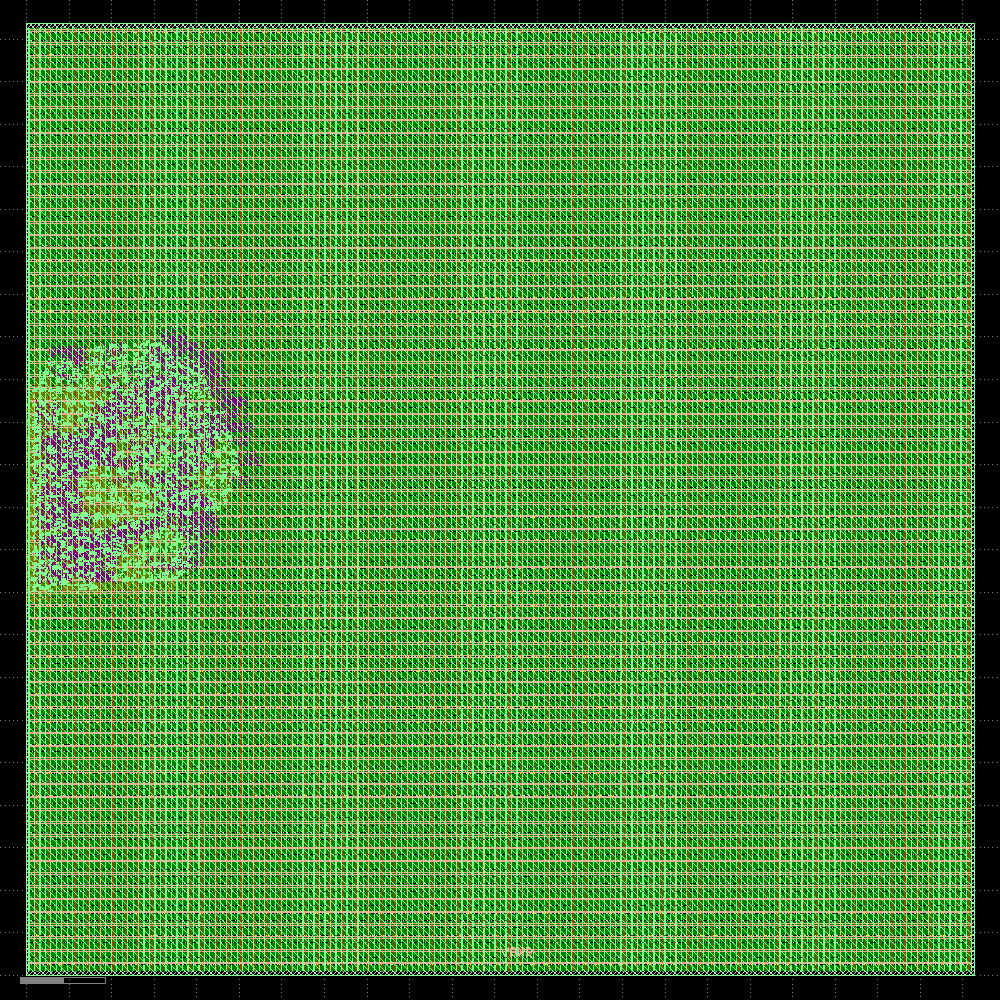

In [ ]:
display(drt)

### Fill Insertion

Finally, as we're done placing all the essential cells, the only thing left to
do is fill in the gaps.

We prioritize the use of decap (decoupling capacitor) cells, which
further supports the power distribution network, but when there aren't any
small enough cells, we just use regular fill cells.

In [ ]:
FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion(state_in=drt.state_out)
fill.start()

───────────────────────────────────────────────── Fill Insertion ──────────────────────────────────────────────────

[14:35:43] VERBOSE  Running 'OpenROAD.FillInsertion'…                                                  ]8;id=824658;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=336248;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:35:43] VERBOSE  Logging subprocess to                                                              ]8;id=20287;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=679731;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=514800;file:///content/openlane_run/12-openroad-fillinsertion/openroad-fillinsertion.log\openlane_run/]8;;\]8;id=967275;file:///content/openlane_run/12-openroad-fillinsertion/openroad-fillinsertion.log\12]8;;\]8;id=514800;file:///content/openlane_run/12-openroad-fillinsertion/openroad-fillinsertion.log\-openroad-fillinsertion/openroad-fillinsertion.log]8;;\…                             

Reading OpenROAD database at '/content/openlane_run/11-openroad-detailedrouting/sparse_cnn_accelerator_single.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 3

[INFO] Setting input delay to: 3

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

sky130_ef_sc_hd__decap_12 sky130_fd_sc_hd__decap_8 sky130_fd_sc_hd__decap_6 sky130_fd_sc_hd__decap_4               
sky130_fd_sc_hd__decap_3 sky130_fd_sc_hd__fill*

[INFO DPL-0001] Placed 417815 filler instances.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.odb'…

Writing netlist to '/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.nl.v'…

Writing powered netlist to '/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.pnl.v'…

Writing layout to '/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.def'…

Writing timing constraints to '/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.sdc'…

{'nl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72768, 'design__instance__area': 118830, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 144, 'design__die__area': Decimal('4.98157E+6'), 'design__core__area': Decimal('4.90498E+6'), 'design__instance__count__stdcell': 72768, 'design__instance__area__stdcell': 118830, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.0242264'), 'design__instance__utilization__stdcell': Decimal('0.0242264'), 'floorplan__design__io': 142, 'design__io__hpwl': 175227290, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('83.56'), 'design__instance__displacement__mean': Decimal('0.001'), 'design__instance__displacement__max': Decimal('4.528'), 'route__wirelength__estimated': 170884, 'design__violations': 0, 'design__instance__count__setup_buffer': 0, 'design__instance__count__hold_buffer': 42, 'antenna__violating__nets': 55, 'antenna__violating__pins': 66, 'route__net': 3075, 'route__net__special': 2, 'route__drc_errors__iter:1': 1287, 'route__wirelength__iter:1': 188880, 'route__drc_errors__iter:2': 501, 'route__wirelength__iter:2': 188127, 'route__drc_errors__iter:3': 309, 'route__wirelength__iter:3': 187983, 'route__drc_errors__iter:4': 15, 'route__wirelength__iter:4': 187988, 'route__drc_errors__iter:5': 0, 'route__wirelength__iter:5': 187977, 'route__drc_errors': 0, 'route__wirelength': 187977, 'route__vias': 24826, 'route__vias__singlecut': 24826, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[14:35:58] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=501273;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=349499;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:35:58] VERBOSE  Logging subprocess to ]8;id=204914;file:///tmp/openlane_klayout_tmp_zvgkc8v0/klayout-render.log\..]8;;\]8;id=770495;file:///tmp/openlane_klayout_tmp_zvgkc8v0/klayout-render.log\/tmp/openlane_klayout_tmp_zvgkc8v0/]8;;\]8;id=387105;file:///tmp/openlane_klayout_tmp_zvgkc8v0/klayout-render.log\klayout-render.log]8;;\…     ]8;id=717808;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=146344;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 15.15s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
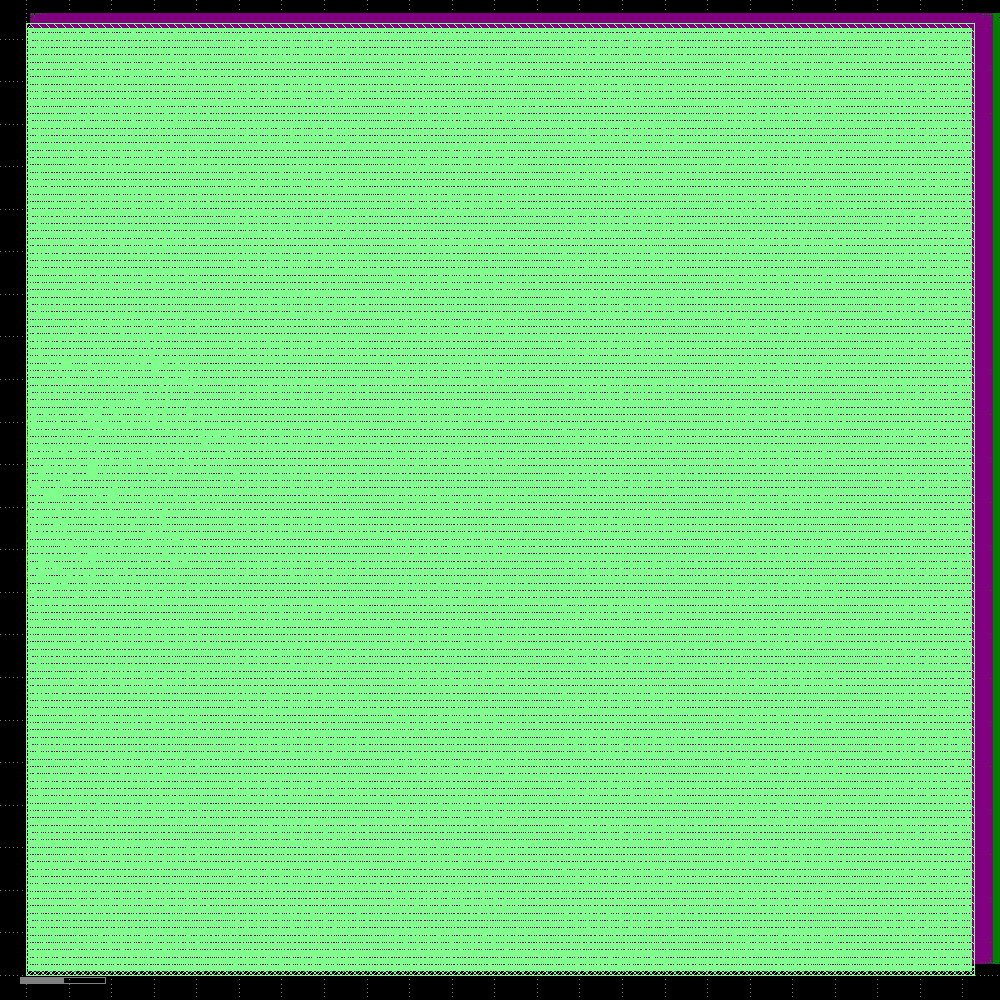

In [ ]:
display(fill)

### Parasitics Extraction a.k.a. Resistance/Capacitance Extraction (RCX)

This step does not alter the design- rather, it computes the
[Parasitic elements](https://en.wikipedia.org/wiki/Parasitic_element_(electrical_networks))
of the circuit, which have an effect of timing, as we prepare to do the final
timing analysis.

The parasitic elements are saved in the **Standard Parasitics Exchange Format**,
or SPEF. OpenLane creates a SPEF file for each interconnect corner as described in
the [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
section of the documentation.

In [ ]:
RCX = Step.factory.get("OpenROAD.RCX")

rcx = RCX(state_in=fill.state_out)
rcx.start()

─────────────────────────────────── Parasitic Resistance/Capacitance Extraction ───────────────────────────────────

[14:36:22] VERBOSE  Running 'OpenROAD.RCX'…                                                            ]8;id=131961;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=96633;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:36:22] INFO     Running RCX for corners matching nom_*                                         ]8;id=7320;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=501085;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/13-openroad-rcx/nom/rcx.log)…                                           

[14:36:22] INFO     Running RCX for corners matching min_*                                         ]8;id=766308;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=736112;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/13-openroad-rcx/min/rcx.log)…                                           

[14:36:22] VERBOSE  Logging subprocess to ]8;id=534194;file:///content/openlane_run/13-openroad-rcx/nom/rcx.log\openlane_run/]8;;\]8;id=372940;file:///content/openlane_run/13-openroad-rcx/nom/rcx.log\13]8;;\]8;id=534194;file:///content/openlane_run/13-openroad-rcx/nom/rcx.log\-openroad-rcx/nom/rcx.log]8;;\…                    ]8;id=556339;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=801073;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[14:36:22] VERBOSE  Logging subprocess to ]8;id=88757;file:///content/openlane_run/13-openroad-rcx/min/rcx.log\openlane_run/]8;;\]8;id=645938;file:///content/openlane_run/13-openroad-rcx/min/rcx.log\13]8;;\]8;id=88757;file:///content/openlane_run/13-openroad-rcx/min/rcx.log\-openroad-rcx/min/rcx.log]8;;\…                    ]8;id=872778;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=110376;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[14:36:39] INFO     Finished RCX for corners matching nom_*.                                       ]8;id=723885;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=187437;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

[14:36:39] INFO     Running RCX for corners matching max_*                                         ]8;id=227552;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=87784;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/13-openroad-rcx/max/rcx.log)…                                           

[14:36:39] VERBOSE  Logging subprocess to ]8;id=896056;file:///content/openlane_run/13-openroad-rcx/max/rcx.log\openlane_run/]8;;\]8;id=160674;file:///content/openlane_run/13-openroad-rcx/max/rcx.log\13]8;;\]8;id=896056;file:///content/openlane_run/13-openroad-rcx/max/rcx.log\-openroad-rcx/max/rcx.log]8;;\…                    ]8;id=909648;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=158097;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[14:36:39] INFO     Finished RCX for corners matching min_*.                                       ]8;id=102078;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=979708;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

[14:36:49] INFO     Finished RCX for corners matching max_*.                                       ]8;id=900447;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=374441;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

{'nl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.sdc'), 'sdf': None, 'spef': {'nom_*': Path('/content/openlane_run/13-openroad-rcx/nom/sparse_cnn_accelerator_single.nom.spef'), 'min_*': Path('/content/openlane_run/13-openroad-rcx/min/sparse_cnn_accelerator_single.min.spef'), 'max_*': Path('/content/openlane_run/13-openroad-rcx/max/sparse_cnn_accelerator_single.max.spef')}, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72768, 'design__instance__area': 118830, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 144, 'design__die__area': Decimal('4.98157E+6'), 'design__core__area': Decimal('4.90498E+6'), 'design__instance__count__stdcell': 72768, 'design__instance__area__stdcell': 118830, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.0242264'), 'design__instance__utilization__stdcell': Decimal('0.0242264'), 'floorplan__design__io': 142, 'design__io__hpwl': 175227290, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('83.56'), 'design__instance__displacement__mean': Decimal('0.001'), 'design__instance__displacement__max': Decimal('4.528'), 'route__wirelength__estimated': 170884, 'design__violations': 0, 'design__instance__count__setup_buffer': 0, 'design__instance__count__hold_buffer': 42, 'antenna__violating__nets': 55, 'antenna__violating__pins': 66, 'route__net': 3075, 'route__net__special': 2, 'route__drc_errors__iter:1': 1287, 'route__wirelength__iter:1': 188880, 'route__drc_errors__iter:2': 501, 'route__wirelength__iter:2': 188127, 'route__drc_errors__iter:3': 309, 'route__wirelength__iter:3': 187983, 'route__drc_errors__iter:4': 15, 'route__wirelength__iter:4': 187988, 'route__drc_errors__iter:5': 0, 'route__wirelength__iter:5': 187977, 'route__drc_errors': 0, 'route__wirelength': 187977, 'route__vias': 24826, 'route__vias__singlecut': 24826, 'route__vias__multicut': 0}}

In [ ]:
# Assuming 'previous_step' is the output of the step before STA
beforeSTA = Step.factory.get("OpenSTA.STA")
sta_step = beforeSTA(
    state_in=rcx.state_out,
    STA_RECALC=True # Corresponds to set ::env(STA_RECALC) 1
    # ... other STA config
)
sta_step.start()

### Static Timing Analysis (Post-PnR)

STA is a process that verifies that a chip meets certain constraints on clock
and data timings to run at its rated clock speed. See [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
in the documentation for more info.

---

This step generates two kinds of files:
* `.lib`: Liberty™-compatible Library files. Can be used to do static timing
  analysis when creating a design with this design as a sub-macro.
* `.sdf`: Standard Delay Format. Can be used with certain simulation software
  to do *dynamic* timing analysis.

Unfortunately, the `.lib` files coming out of OpenLane right now are not super
reliable for timing purposes and are only provided for completeness.
When using OpenLane-created macros withing other designs, it is best to use the
macro's final netlist and extracted parasitics instead.

In [ ]:
STAPostPNR = Step.factory.get("OpenROAD.STAPostPNR")

sta_post_pnr = STAPostPNR(state_in=rcx.state_out)
sta_post_pnr.start()

──────────────────────────────────────── Static Timing Analysis (Post-PnR) ────────────────────────────────────────

[14:36:49] VERBOSE  Running 'OpenROAD.STAPostPNR'…                                                     ]8;id=740533;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=162142;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:36:49] INFO     Starting STA for the nom_tt_025C_1v80 timing corner…                            ]8;id=949029;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=978477;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[14:36:49] INFO     Starting STA for the nom_ss_100C_1v60 timing corner…                            ]8;id=559755;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=713165;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[14:36:49] VERBOSE  Logging subprocess to                                                              ]8;id=340800;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=493046;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=456618;file:///content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=893309;file:///content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\14]8;;\]8;id=456618;file:///content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\-openroad-stapostpnr/nom_tt_025C_1v80/sta.log]8;;\…                                  

[14:36:49] VERBOSE  Logging subprocess to                                                              ]8;id=728846;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=571524;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=390715;file:///content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=414365;file:///content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\14]8;;\]8;id=390715;file:///content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\-openroad-stapostpnr/nom_ss_100C_1v60/sta.log]8;;\…                                  

[14:37:02] INFO     Finished STA for the nom_tt_025C_1v80 timing corner.                            ]8;id=413855;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=293543;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[14:37:02] VERBOSE  Logging subprocess to                                                              ]8;id=665595;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=354508;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=801885;file:///content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=987281;file:///content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\14]8;;\]8;id=801885;file:///content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[14:37:04] INFO     Finished STA for the nom_ss_100C_1v60 timing corner.                            ]8;id=88246;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=759209;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[14:37:04] VERBOSE  Logging subprocess to                                                              ]8;id=901942;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=948102;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=71;file:///content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=805412;file:///content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\14]8;;\]8;id=71;file:///content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[14:37:07] INFO     Starting STA for the nom_ff_n40C_1v95 timing corner…                            ]8;id=753015;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=659414;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[14:37:07] VERBOSE  Logging subprocess to                                                              ]8;id=495975;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=954437;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=517552;file:///content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=435102;file:///content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\14]8;;\]8;id=517552;file:///content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log]8;;\…                                  

[14:37:07] INFO     Starting STA for the min_tt_025C_1v80 timing corner…                            ]8;id=659297;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=759622;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[14:37:07] VERBOSE  Logging subprocess to                                                              ]8;id=273161;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=548949;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=647189;file:///content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=42901;file:///content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sta.log\14]8;;\]8;id=647189;file:///content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sta.log\-openroad-stapostpnr/min_tt_025C_1v80/sta.log]8;;\…                                  

[14:37:21] INFO     Finished STA for the nom_ff_n40C_1v95 timing corner.                            ]8;id=248196;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=320071;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[14:37:21] VERBOSE  Logging subprocess to                                                              ]8;id=444160;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=635413;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=529932;file:///content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=105868;file:///content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\14]8;;\]8;id=529932;file:///content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

[14:37:21] INFO     Finished STA for the min_tt_025C_1v80 timing corner.                            ]8;id=765189;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=361585;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[14:37:21] VERBOSE  Logging subprocess to                                                              ]8;id=959609;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=952821;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=369927;file:///content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=675389;file:///content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\14]8;;\]8;id=369927;file:///content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[14:37:27] INFO     Starting STA for the min_ss_100C_1v60 timing corner…                            ]8;id=218160;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=247342;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[14:37:27] VERBOSE  Logging subprocess to                                                              ]8;id=672212;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=191426;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=201608;file:///content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=453208;file:///content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sta.log\14]8;;\]8;id=201608;file:///content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sta.log\-openroad-stapostpnr/min_ss_100C_1v60/sta.log]8;;\…                                  

[14:37:27] INFO     Starting STA for the min_ff_n40C_1v95 timing corner…                            ]8;id=918443;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=528691;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[14:37:27] VERBOSE  Logging subprocess to                                                              ]8;id=284776;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=335302;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=402976;file:///content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=607480;file:///content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\14]8;;\]8;id=402976;file:///content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\-openroad-stapostpnr/min_ff_n40C_1v95/sta.log]8;;\…                                  

[14:37:41] INFO     Finished STA for the min_ss_100C_1v60 timing corner.                            ]8;id=338174;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=567048;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[14:37:41] VERBOSE  Logging subprocess to                                                              ]8;id=110864;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=862524;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=309904;file:///content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=514026;file:///content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\14]8;;\]8;id=309904;file:///content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[14:37:42] INFO     Finished STA for the min_ff_n40C_1v95 timing corner.                            ]8;id=365778;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=544724;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[14:37:42] VERBOSE  Logging subprocess to                                                              ]8;id=52743;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=703686;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=495736;file:///content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=306375;file:///content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\14]8;;\]8;id=495736;file:///content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

[14:37:44] INFO     Starting STA for the max_tt_025C_1v80 timing corner…                            ]8;id=455598;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=320270;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[14:37:45] VERBOSE  Logging subprocess to                                                              ]8;id=689195;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=92060;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=172577;file:///content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=579345;file:///content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sta.log\14]8;;\]8;id=172577;file:///content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sta.log\-openroad-stapostpnr/max_tt_025C_1v80/sta.log]8;;\…                                  

[14:37:45] INFO     Starting STA for the max_ss_100C_1v60 timing corner…                            ]8;id=186941;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=369254;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[14:37:45] VERBOSE  Logging subprocess to                                                              ]8;id=523582;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=63526;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=144176;file:///content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=534825;file:///content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sta.log\14]8;;\]8;id=144176;file:///content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sta.log\-openroad-stapostpnr/max_ss_100C_1v60/sta.log]8;;\…                                  

[14:37:59] INFO     Finished STA for the max_tt_025C_1v80 timing corner.                            ]8;id=521607;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=680849;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[14:37:59] VERBOSE  Logging subprocess to                                                              ]8;id=293083;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=240434;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=927892;file:///content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=278961;file:///content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\14]8;;\]8;id=927892;file:///content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[14:38:02] INFO     Finished STA for the max_ss_100C_1v60 timing corner.                            ]8;id=504756;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=281422;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[14:38:02] VERBOSE  Logging subprocess to                                                              ]8;id=214300;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=237256;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=691201;file:///content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=662961;file:///content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\14]8;;\]8;id=691201;file:///content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[14:38:08] INFO     Starting STA for the max_ff_n40C_1v95 timing corner…                            ]8;id=842196;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=38087;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[14:38:08] VERBOSE  Logging subprocess to                                                              ]8;id=576831;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=665697;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=921606;file:///content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=606587;file:///content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\14]8;;\]8;id=921606;file:///content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\-openroad-stapostpnr/max_ff_n40C_1v95/sta.log]8;;\…                                  

[14:38:19] INFO     Finished STA for the max_ff_n40C_1v95 timing corner.                            ]8;id=522369;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=65604;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[14:38:19] VERBOSE  Logging subprocess to                                                              ]8;id=797430;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=638952;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=398699;file:///content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=292129;file:///content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\14]8;;\]8;id=398699;file:///content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.10… │ 0.10… │ 0.0… │ 0     │ 0    │ -0.9… │ 2.8… │ -10.… │ 38   │ 0     │ 21   │ 1736  │
│ nom_tt_025C_1v80     │ 0.32… │ 0.32… │ 0.0… │ 0     │ 0    │ 5.44… │ 9.2… │ 0.00… │ 0    │ 0     │ 3    │ 491   │
│ nom_ss_100C_1v60     │ 0.89… │ 0.89… │ 0.0… │ 0     │ 0    │ -0.6… │ 2.8… │ -5.9… │ 13   │ 0     │ 16   │ 1607  │
│ nom_ff_n40C_1v95     │ 0.10… │ 0.10… │ 0.0… │ 0     │ 0    │ 8.00… │ 11.… │ 0.00… │ 0    │ 0     │ 3    │ 229   │
│ min_tt_025C_1v80     │ 0.33… │ 0.33… │ 0.0… │ 0     │ 0    │ 5.61… │ 9.5… │ 0.00… │ 0    │ 0     │ 2    │ 450   │
│ min_ss_100C_1v60     │ 0.88… │ 0.88… │ 0.0… │ 0     │ 0    │ -0.3… │ 3.1… │ -2.3… │ 9    │ 0     │ 14   │ 1469  │
│ min_ff_n40C_1v95     │ 0.10… │ 0.10… │ 0.0… │ 0     │ 0    │ 8.11… │ 11.… │ 0.00… │ 0    │ 0     │ 2    │ 174   │
│ max_tt_025C_1v80     │ 0.32… │ 0.32… │ 0.0… │ 0     │ 0    │ 5.27… │ 9.0… │ 0.00… │ 0    │ 0     │ 3    │ 546   │
│ max_ss_100C_1v60     │ 0.89… │ 0.89… │ 0.0… │ 0     │ 0    │ -0.9… │ 3.4… │ -10.… │ 16   │ 0     │ 21   │ 1736  │
│ max_ff_n40C_1v95     │ 0.11… │ 0.11… │ 0.0… │ 0     │ 0    │ 7.89… │ 11.… │ 0.00… │ 0    │ 0     │ 3    │ 240   │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.1078   │ 0.1078   │ 0.0000   │ 0        │ 0         │ -0.9699  │ 2.8997    │ -10.6742 │ 38        │ 0        │ 21        │ 1736     │
│ nom_tt_025C_1v80     │ 0.3273   │ 0.3272   │ 0.0000   │ 0        │ 0         │ 5.4466   │ 9.2910    │ 0.0000   │ 0         │ 0        │ 3         │ 491      │
│ nom_ss_100C_1v60     │ 0.8900   │ 0.8900   │ 0.0000   │ 0        │ 0         │ -0.6600  │ 2.8997    │ -5.9046  │ 13        │ 0        │ 16        │ 1607     │
│ nom_ff_n40C_1v95     │ 0.1099   │ 0.1099   │ 0.0000   │ 0        │ 0         │ 8.0035   │ 11.2816   │ 0.0000   │ 0         │ 0        │ 3         │ 229      │
│ min_tt_025C_1v80     │ 0.3302   │ 0.3302   │ 0.0000   │ 0        │ 0         │ 5.6180   │ 9.5543    │ 0.0000   │ 0         │ 0        │ 2         │ 450      │
│ min_ss_100C_1v60     │ 0.8844   │ 0.8844   │ 0.0000   │ 0        │ 0         │ -0.3300  │ 3.1599    │ -2.3851  │ 9         │ 0        │ 14        │ 1469     │
│ min_ff_n40C_1v95     │ 0.1078   │ 0.1078   │ 0.0000   │ 0        │ 0         │ 8.1190   │ 11.4430   │ 0.0000   │ 0         │ 0        │ 2         │ 174      │
│ max_tt_025C_1v80     │ 0.3253   │ 0.3253   │ 0.0000   │ 0        │ 0         │ 5.2763   │ 9.0687    │ 0.0000   │ 0         │ 0        │ 3         │ 546      │
│ max_ss_100C_1v60     │ 0.8967   │ 0.8967   │ 0.0000   │ 0        │ 0         │ -0.9699  │ 3.4816    │ -10.6742 │ 16        │ 0        │ 21        │ 1736     │
│ max_ff_n40C_1v95     │ 0.1120   │ 0.1120   │ 0.0000   │ 0        │ 0         │ 7.8903   │ 11.1513   │ 0.0000   │ 0         │ 0        │ 3         │ 240      │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

{'nl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sparse_cnn_accelerator_single__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sparse_cnn_accelerator_single__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sparse_cnn_accelerator_single__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sparse_cnn_accelerator_single__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sparse_cnn_accelerator_single__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sparse_cnn_accelerator_single__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sparse_cnn_accelerator_single__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sparse_cnn_accelerator_single__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sparse_cnn_accelerator_single__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/13-openroad-rcx/nom/sparse_cnn_accelerator_single.nom.spef'), 'min_*': Path('/content/openlane_run/13-openroad-rcx/min/sparse_cnn_accelerator_single.min.spef'), 'max_*': Path('/content/openlane_run/13-openroad-rcx/max/sparse_cnn_accelerator_single.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sparse_cnn_accelerator_single__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sparse_cnn_accelerator_single__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sparse_cnn_accelerator_single__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sparse_cnn_accelerator_single__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sparse_cnn_accelerator_single__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sparse_cnn_accelerator_single__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sparse_cnn_accelerator_single__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sparse_cnn_accelerator_single__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sparse_cnn_accelerator_single__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72768, 'design__instance__area': 118830, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 144, 'design__die__area': Decimal('4.98157E+6'), 'design__core__area': Decimal('4.90498E+6'), 'desig

### Stream-out

Stream-out is the process of converting the designs from the abstract formats
using during floorplanning, placement and routing into a concrete format called
GDSII (lit. Graphic Design System 2), which is the final file that is then sent
for fabrication.

In [ ]:
StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut(state_in=sta_post_pnr.state_out)
gds.start()

─────────────────────────────────────────── GDSII Stream Out (KLayout) ────────────────────────────────────────────

[14:38:22] VERBOSE  Running 'KLayout.StreamOut'…                                                       ]8;id=805844;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=787916;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:38:22] VERBOSE  Logging subprocess to ]8;id=692761;file:///content/openlane_run/15-klayout-streamout/klayout-streamout.log\openlane_run/]8;;\]8;id=13768;file:///content/openlane_run/15-klayout-streamout/klayout-streamout.log\15]8;;\]8;id=692761;file:///content/openlane_run/15-klayout-streamout/klayout-streamout.log\-klayout-streamout/klayout-streamout.log]8;;\…     ]8;id=582531;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=420065;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[INFO] Clearing cells…

[INFO] Merging GDS files…

[INFO] Copying top level cell 'sparse_cnn_accelerator_single'…

[INFO] Checking for missing GDS…

[INFO] All LEF cells have matching GDS cells.

[INFO] Writing out GDS '/content/openlane_run/15-klayout-streamout/sparse_cnn_accelerator_single.klayout.gds'…

[INFO] Done.

{'nl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sparse_cnn_accelerator_single__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sparse_cnn_accelerator_single__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sparse_cnn_accelerator_single__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sparse_cnn_accelerator_single__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sparse_cnn_accelerator_single__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sparse_cnn_accelerator_single__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sparse_cnn_accelerator_single__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sparse_cnn_accelerator_single__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sparse_cnn_accelerator_single__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/13-openroad-rcx/nom/sparse_cnn_accelerator_single.nom.spef'), 'min_*': Path('/content/openlane_run/13-openroad-rcx/min/sparse_cnn_accelerator_single.min.spef'), 'max_*': Path('/content/openlane_run/13-openroad-rcx/max/sparse_cnn_accelerator_single.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sparse_cnn_accelerator_single__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sparse_cnn_accelerator_single__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sparse_cnn_accelerator_single__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sparse_cnn_accelerator_single__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sparse_cnn_accelerator_single__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sparse_cnn_accelerator_single__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sparse_cnn_accelerator_single__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sparse_cnn_accelerator_single__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sparse_cnn_accelerator_single__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/15-klayout-streamout/sparse_cnn_accelerator_single.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/15-klayout-streamout/sparse_cnn_accelerator_single.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72768, 'design__instance__area': 118830, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[14:38:39] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=691105;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=670373;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:38:39] VERBOSE  Logging subprocess to ]8;id=272953;file:///tmp/openlane_klayout_tmp_eyvy5mi0/klayout-render.log\..]8;;\]8;id=629938;file:///tmp/openlane_klayout_tmp_eyvy5mi0/klayout-render.log\/tmp/openlane_klayout_tmp_eyvy5mi0/]8;;\]8;id=178470;file:///tmp/openlane_klayout_tmp_eyvy5mi0/klayout-render.log\klayout-render.log]8;;\…     ]8;id=746519;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=448497;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 16.50s
#### Views updated:
* GDSII Stream
* GDSII Stream (KLayout)
#### Preview:
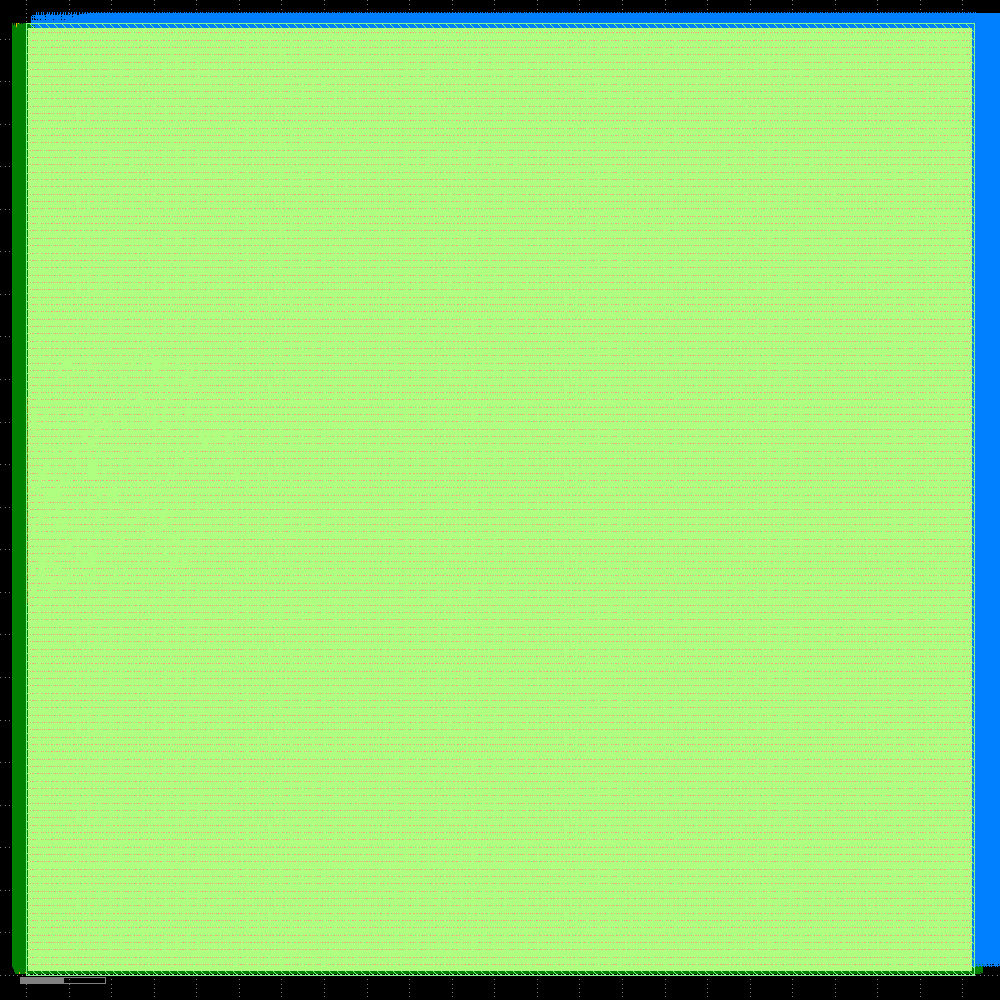

In [ ]:
display(gds)

### Design Rule Checks (DRC)

DRC determines that the final layout does not violate any of the rules set by
the foundry to ensure the design is actually manufacturable- for example,
not enough space between two wires, *too much* space between tap cells, and so
on.

A design not passing DRC will typically be rejected by the foundry, who
also run DRC on their side.

In [ ]:
DRC = Step.factory.get("Magic.DRC")

drc = DRC(state_in=gds.state_out)
drc.start()

─────────────────────────────────────────────── Design Rule Checks ────────────────────────────────────────────────

[14:39:14] VERBOSE  Running 'Magic.DRC'…                                                               ]8;id=241315;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=93774;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[14:39:14] VERBOSE  Logging subprocess to ]8;id=581576;file:///content/openlane_run/16-magic-drc/magic-drc.log\openlane_run/]8;;\]8;id=249886;file:///content/openlane_run/16-magic-drc/magic-drc.log\16]8;;\]8;id=581576;file:///content/openlane_run/16-magic-drc/magic-drc.log\-magic-drc/magic-drc.log]8;;\…                     ]8;id=945078;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=283157;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

Warning: Calma reading is not undoable!  I hope that's OK.

Library written using GDS-II Release 6.0

Library name: LIB

Reading "VIA_M3M4_PR".

Reading "VIA_M1M2_PR_MR".

Reading "VIA_M2M3_PR".

Reading "VIA_M1M2_PR".

Reading "VIA_L1M1_PR_MR".

Reading "VIA_via2_3_2000_480_1_6_320_320".

Reading "VIA_via3_4_2000_480_1_5_400_400".

Reading "VIA_via4_5_2000_480_1_5_400_400".

Reading "VIA_via5_6_2000_2000_1_1_1600_1600".

Reading "sky130_fd_sc_hd__dlygate4sd3_1".

Reading "sky130_fd_sc_hd__clkinv_1".

Reading "sky130_fd_sc_hd__clkbuf_4".

Reading "sky130_fd_sc_hd__clkinv_2".

Reading "sky130_fd_sc_hd__inv_6".

Reading "sky130_fd_sc_hd__bufinv_16".

Reading "sky130_fd_sc_hd__clkinv_4".

Reading "sky130_fd_sc_hd__clkinvlp_4".

Reading "sky130_fd_sc_hd__clkinv_8".

Reading "sky130_fd_sc_hd__inv_16".

Reading "sky130_fd_sc_hd__clkbuf_8".

Reading "sky130_fd_sc_hd__clkbuf_16".

Reading "sky130_fd_sc_hd__conb_1".

Reading "sky130_fd_sc_hd__dfstp_2".

Reading "sky130_fd_sc_hd__dfxtp_2".

Reading "sky130_fd_sc_hd__a32oi_2".

Reading "sky130_fd_sc_hd__nor4b_2".

Reading "sky130_fd_sc_hd__o311ai_2".

Reading "sky130_fd_sc_hd__a311oi_2".

Reading "sky130_fd_sc_hd__mux2_2".

Reading "sky130_fd_sc_hd__o32ai_2".

Reading "sky130_fd_sc_hd__nor4_2".

Reading "sky130_fd_sc_hd__a221oi_2".

Reading "sky130_fd_sc_hd__or2b_2".

Reading "sky130_fd_sc_hd__xor2_2".

Reading "sky130_fd_sc_hd__nand2b_2".

Reading "sky130_fd_sc_hd__a2111oi_2".

Reading "sky130_fd_sc_hd__o32a_2".

Reading "sky130_fd_sc_hd__nor2b_2".

Reading "sky130_fd_sc_hd__o221ai_2".

Reading "sky130_fd_sc_hd__a2bb2o_2".

Reading "sky130_fd_sc_hd__and2b_2".

Reading "sky130_fd_sc_hd__xnor2_2".

Reading "sky130_fd_sc_hd__and3b_2".

Reading "sky130_fd_sc_hd__nor3b_2".

Reading "sky130_fd_sc_hd__and4bb_2".

Reading "sky130_fd_sc_hd__or3b_2".

Reading "sky130_fd_sc_hd__a211oi_2".

Reading "sky130_fd_sc_hd__a41o_2".

Reading "sky130_fd_sc_hd__a2111o_2".

Reading "sky130_fd_sc_hd__and4_2".

Reading "sky130_fd_sc_hd__a32o_2".

Reading "sky130_fd_sc_hd__and3_2".

Reading "sky130_fd_sc_hd__a21bo_2".

Reading "sky130_fd_sc_hd__o311a_2".

Reading "sky130_fd_sc_hd__a21boi_2".

Reading "sky130_fd_sc_hd__nor3_2".

Reading "sky130_fd_sc_hd__a311o_2".

Reading "sky130_fd_sc_hd__or3_2".

Reading "sky130_fd_sc_hd__or2_2".

Reading "sky130_fd_sc_hd__a221o_2".

Reading "sky130_fd_sc_hd__o221a_2".

Reading "sky130_fd_sc_hd__o22a_2".

Reading "sky130_fd_sc_hd__nand4_2".

Reading "sky130_fd_sc_hd__o22ai_2".

Reading "sky130_fd_sc_hd__and4b_2".

Reading "sky130_fd_sc_hd__o2bb2a_2".

Reading "sky130_fd_sc_hd__a22oi_2".

Reading "sky130_fd_sc_hd__o2bb2ai_2".

Reading "sky130_fd_sc_hd__nand3_2".

Reading "sky130_fd_sc_hd__a41oi_2".

Reading "sky130_fd_sc_hd__o2111a_2".

Reading "sky130_fd_sc_hd__o21a_2".

Reading "sky130_fd_sc_hd__o31ai_2".

Reading "sky130_fd_sc_hd__a22o_2".

Reading "sky130_fd_sc_hd__nand4b_2".

Reading "sky130_fd_sc_hd__a211o_2".

Reading "sky130_fd_sc_hd__a21o_2".

Reading "sky130_fd_sc_hd__o211a_2".

Reading "sky130_fd_sc_hd__o2111ai_2".

Reading "sky130_fd_sc_hd__a2bb2oi_2".

Reading "sky130_fd_sc_hd__a31oi_2".

Reading "sky130_fd_sc_hd__o21ba_2".

Reading "sky130_fd_sc_hd__o211ai_2".

Reading "sky130_fd_sc_hd__o21ai_2".

Reading "sky130_fd_sc_hd__a31o_2".

Reading "sky130_fd_sc_hd__a21oi_2".

Reading "sky130_fd_sc_hd__o21bai_2".

Reading "sky130_fd_sc_hd__and2_2".

Reading "sky130_fd_sc_hd__nand3b_2".

Reading "sky130_fd_sc_hd__nand2_2".

Reading "sky130_fd_sc_hd__nor2_2".

Reading "sky130_fd_sc_hd__or4bb_2".

Reading "sky130_fd_sc_hd__o31a_2".

Reading "sky130_fd_sc_hd__or4_2".

Reading "sky130_fd_sc_hd__or4b_2".

Reading "sky130_fd_sc_hd__buf_1".

Reading "sky130_fd_sc_hd__inv_2".

Reading "sky130_fd_sc_hd__tapvpwrvgnd_1".

Reading "sky130_fd_sc_hd__fill_2".

Reading "sky130_fd_sc_hd__decap_8".

Reading "sky130_fd_sc_hd__decap_4".

Reading "sky130_fd_sc_hd__decap_6".

Reading "sky130_fd_sc_hd__fill_1".

Reading "sky130_ef_sc_hd__decap_12".

Reading "sky130_fd_sc_hd__decap_3".

Reading "sparse_cnn_accelerator_single".

5000 uses

10000 uses

15000 uses

20000 uses

25000 uses

30000 uses

35000 uses

40000 uses

45000 uses

50000 uses

55000 uses

60000 uses

65000 uses

70000 uses

75000 uses

80000 uses

85000 uses

90000 uses

95000 uses

100000 uses

105000 uses

110000 uses

115000 uses

120000 uses

125000 uses

130000 uses

135000 uses

140000 uses

145000 uses

150000 uses

155000 uses

160000 uses

165000 uses

170000 uses

175000 uses

180000 uses

185000 uses

190000 uses

195000 uses

200000 uses

205000 uses

210000 uses

215000 uses

220000 uses

225000 uses

230000 uses

235000 uses

240000 uses

245000 uses

250000 uses

255000 uses

260000 uses

265000 uses

270000 uses

275000 uses

280000 uses

285000 uses

290000 uses

295000 uses

300000 uses

305000 uses

310000 uses

315000 uses

320000 uses

325000 uses

330000 uses

335000 uses

340000 uses

345000 uses

350000 uses

355000 uses

360000 uses

365000 uses

370000 uses

375000 uses

380000 uses

385000 uses

390000 uses

395000 uses

400000 uses

405000 uses

410000 uses

415000 uses

420000 uses

425000 uses

430000 uses

435000 uses

440000 uses

445000 uses

450000 uses

455000 uses

460000 uses

465000 uses

470000 uses

475000 uses

480000 uses

485000 uses

490000 uses

495000 uses

500000 uses

505000 uses

510000 uses

515000 uses

520000 uses

525000 uses

530000 uses

535000 uses

540000 uses

545000 uses

550000 uses

555000 uses

560000 uses

565000 uses

570000 uses

575000 uses

580000 uses

585000 uses

590000 uses

595000 uses

600000 uses

605000 uses

610000 uses

615000 uses

620000 uses

625000 uses

630000 uses

635000 uses

640000 uses

645000 uses

650000 uses

655000 uses

660000 uses

665000 uses

670000 uses

675000 uses

680000 uses

685000 uses

690000 uses

695000 uses

700000 uses

705000 uses

[INFO] Loading sparse_cnn_accelerator_single

DRC style is now "drc(full)"

Loading DRC CIF style.

No errors found.

[INFO] COUNT: 0

[INFO] Should be divided by 3 or 4

[INFO] DRC Checking DONE (/content/openlane_run/16-magic-drc/reports/drc_violations.magic.rpt)

[INFO] Saving mag view with DRC errors                                                                             
(/content/openlane_run/16-magic-drc/views/sparse_cnn_accelerator_single.drc.mag)

[INFO] Saved

{'nl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sparse_cnn_accelerator_single__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sparse_cnn_accelerator_single__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sparse_cnn_accelerator_single__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sparse_cnn_accelerator_single__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sparse_cnn_accelerator_single__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sparse_cnn_accelerator_single__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sparse_cnn_accelerator_single__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sparse_cnn_accelerator_single__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sparse_cnn_accelerator_single__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/13-openroad-rcx/nom/sparse_cnn_accelerator_single.nom.spef'), 'min_*': Path('/content/openlane_run/13-openroad-rcx/min/sparse_cnn_accelerator_single.min.spef'), 'max_*': Path('/content/openlane_run/13-openroad-rcx/max/sparse_cnn_accelerator_single.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sparse_cnn_accelerator_single__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sparse_cnn_accelerator_single__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sparse_cnn_accelerator_single__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sparse_cnn_accelerator_single__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sparse_cnn_accelerator_single__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sparse_cnn_accelerator_single__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sparse_cnn_accelerator_single__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sparse_cnn_accelerator_single__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sparse_cnn_accelerator_single__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/15-klayout-streamout/sparse_cnn_accelerator_single.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/15-klayout-streamout/sparse_cnn_accelerator_single.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72768, 'design__instance__area': 118830, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 2226.59 2237.31', 'design__core__bbox': '5.52 10.88 2220.88 2224.96', 

### SPICE Extraction for Layout vs. Schematic Check

This step tries to reconstruct a SPICE netlist from the GDSII file, so it can
later be used for the **Layout vs. Schematic** (LVS) check.

In [ ]:
SpiceExtraction = Step.factory.get("Magic.SpiceExtraction")

spx = SpiceExtraction(state_in=drc.state_out)
spx.start()

───────────────────────────────────────────── SPICE Model Extraction ──────────────────────────────────────────────

[15:09:47] VERBOSE  Running 'Magic.SpiceExtraction'…                                                   ]8;id=813316;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=74306;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:09:47] VERBOSE  Logging subprocess to                                                              ]8;id=982608;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=514938;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=555295;file:///content/openlane_run/17-magic-spiceextraction/magic-spiceextraction.log\openlane_run/]8;;\]8;id=651724;file:///content/openlane_run/17-magic-spiceextraction/magic-spiceextraction.log\17]8;;\]8;id=555295;file:///content/openlane_run/17-magic-spiceextraction/magic-spiceextraction.log\-magic-spiceextraction/magic-spiceextraction.log]8;;\…                               

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef.

This action cannot be undone.

LEF read, Line 78 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 79 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 112 (Message): Unknown keyword "MINENCLOSEDAREA" in LEF file; ignoring.

LEF read, Line 114 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 115 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 121 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 122 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 123 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 156 (Message): Unknown keyword "MINENCLOSEDAREA" in LEF file; ignoring.

LEF read, Line 164 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 165 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 167 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 168 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 169 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 206 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 207 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 209 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 210 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 211 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 248 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 249 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 251 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 252 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 253 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 290 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 291 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read: Processed 797 lines.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef.

This action cannot be undone.

LEF read: Processed 56535 lines.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef.

This action cannot be undone.

LEF read: Processed 278 lines.

> def read /content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.def -noblockage -labels

Reading DEF data from file /content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.def.

This action cannot be undone.

Processed 4 vias total.

Processed 492211 subcell instances total.

Processed 144 pins total.

Processed 2 special nets total.

Processed 3075 nets total.

DEF read: Processed 799111 lines.

Moving label "_0009_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0013_" from metal2 to via2 in cell sparse_cnn_accelerator_single.

Moving label "_0020_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0027_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0037_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0042_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0046_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0047_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0052_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0077_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0093_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0094_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0123_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0156_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_0174_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0175_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0178_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0182_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0184_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0185_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0188_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0189_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0220_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0221_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0223_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0231_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0237_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0264_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0268_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0280_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0282_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0285_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0293_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0295_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0296_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0298_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0299_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0300_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0311_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0321_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_0330_" from metal2 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0343_" from metal2 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0393_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0448_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0491_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0539_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0588_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0646_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0663_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0683_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_0814_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0870_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_0984_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_1045_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_1049_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_1115_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_1174_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_1186_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_1261_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_1298_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_1408_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_1428_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_1478_" from metal2 to via2 in cell sparse_cnn_accelerator_single.

Moving label "_1606_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_1625_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_1630_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_1646_" from metal2 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_1759_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_1804_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_1843_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_1986_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_2100_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_2150_" from metal2 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_2233_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_2250_" from metal2 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_2382_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_2399_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_2400_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_2421_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_2432_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_2443_" from metal2 to via2 in cell sparse_cnn_accelerator_single.

Moving label "_2453_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_2479_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_2482_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_2489_" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_2503_" from metal2 to via2 in cell sparse_cnn_accelerator_single.

Moving label "_2514_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "_2520_" from metal2 to via1 in cell sparse_cnn_accelerator_single.

Moving label "_2531_" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "act_sel.act_reg\[1\]" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "act_sel.act_reg\[27\]" from metal2 to via2 in cell sparse_cnn_accelerator_single.

Moving label "act_sel.act_reg\[2\]" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "act_sel.act_reg\[34\]" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "act_sel.act_reg\[38\]" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "act_sel.act_reg\[45\]" from metal1 to viali in cell sparse_cnn_accelerator_single.

Moving label "act_sel.act_reg\[4\]" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "act_sel.act_reg\[53\]" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "act_sel.selected_act\[31\]" from metal2 to via1 in cell sparse_cnn_accelerator_single.

Moving label "activations[47]" from metal2 to via2 in cell sparse_cnn_accelerator_single.

Moving label "activations[50]" from metal2 to via2 in cell sparse_cnn_accelerator_single.

Moving label "activations[55]" from metal2 to via2 in cell sparse_cnn_accelerator_single.

Moving label "clknet_leaf_48_clk" from metal2 to via1 in cell sparse_cnn_accelerator_single.

Moving label "net11" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "net21" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "net24" from metal1 to via1 in cell sparse_cnn_accelerator_single.

Moving label "result[13]" from metal2 to via2 in cell sparse_cnn_accelerator_single.

Processing sparse_cnn_accelerator_single

Extracting sky130_ef_sc_hd__decap_12 into sky130_ef_sc_hd__decap_12.ext:

Extracting sky130_fd_sc_hd__decap_3 into sky130_fd_sc_hd__decap_3.ext:

Extracting sky130_fd_sc_hd__fill_1 into sky130_fd_sc_hd__fill_1.ext:

Extracting sky130_fd_sc_hd__tapvpwrvgnd_1 into sky130_fd_sc_hd__tapvpwrvgnd_1.ext:

Extracting sky130_fd_sc_hd__decap_4 into sky130_fd_sc_hd__decap_4.ext:

Extracting sky130_fd_sc_hd__decap_6 into sky130_fd_sc_hd__decap_6.ext:

Extracting sky130_fd_sc_hd__buf_1 into sky130_fd_sc_hd__buf_1.ext:

Extracting sky130_fd_sc_hd__dfxtp_2 into sky130_fd_sc_hd__dfxtp_2.ext:

Extracting sky130_fd_sc_hd__decap_8 into sky130_fd_sc_hd__decap_8.ext:

Extracting sky130_fd_sc_hd__fill_2 into sky130_fd_sc_hd__fill_2.ext:

Extracting sky130_fd_sc_hd__o211a_2 into sky130_fd_sc_hd__o211a_2.ext:

Extracting sky130_fd_sc_hd__clkbuf_8 into sky130_fd_sc_hd__clkbuf_8.ext:

Extracting sky130_fd_sc_hd__and2_2 into sky130_fd_sc_hd__and2_2.ext:

Extracting sky130_fd_sc_hd__dlygate4sd3_1 into sky130_fd_sc_hd__dlygate4sd3_1.ext:

Extracting sky130_fd_sc_hd__clkinvlp_4 into sky130_fd_sc_hd__clkinvlp_4.ext:

Extracting sky130_fd_sc_hd__or2b_2 into sky130_fd_sc_hd__or2b_2.ext:

Extracting sky130_fd_sc_hd__o22a_2 into sky130_fd_sc_hd__o22a_2.ext:

Extracting sky130_fd_sc_hd__bufinv_16 into sky130_fd_sc_hd__bufinv_16.ext:

Extracting sky130_fd_sc_hd__nor3b_2 into sky130_fd_sc_hd__nor3b_2.ext:

Extracting sky130_fd_sc_hd__nand3b_2 into sky130_fd_sc_hd__nand3b_2.ext:

Extracting sky130_fd_sc_hd__conb_1 into sky130_fd_sc_hd__conb_1.ext:

Extracting sky130_fd_sc_hd__a41o_2 into sky130_fd_sc_hd__a41o_2.ext:

Extracting sky130_fd_sc_hd__nand3_2 into sky130_fd_sc_hd__nand3_2.ext:

Extracting sky130_fd_sc_hd__nor3_2 into sky130_fd_sc_hd__nor3_2.ext:

Extracting sky130_fd_sc_hd__or3b_2 into sky130_fd_sc_hd__or3b_2.ext:

Extracting sky130_fd_sc_hd__a22oi_2 into sky130_fd_sc_hd__a22oi_2.ext:

Extracting sky130_fd_sc_hd__dfstp_2 into sky130_fd_sc_hd__dfstp_2.ext:

Extracting sky130_fd_sc_hd__inv_2 into sky130_fd_sc_hd__inv_2.ext:

Extracting sky130_fd_sc_hd__nand4_2 into sky130_fd_sc_hd__nand4_2.ext:

Extracting sky130_fd_sc_hd__a31o_2 into sky130_fd_sc_hd__a31o_2.ext:

Extracting sky130_fd_sc_hd__nand2_2 into sky130_fd_sc_hd__nand2_2.ext:

Extracting sky130_fd_sc_hd__or4_2 into sky130_fd_sc_hd__or4_2.ext:

Extracting sky130_fd_sc_hd__and3b_2 into sky130_fd_sc_hd__and3b_2.ext:

Extracting sky130_fd_sc_hd__and3_2 into sky130_fd_sc_hd__and3_2.ext:

Extracting sky130_fd_sc_hd__a22o_2 into sky130_fd_sc_hd__a22o_2.ext:

Extracting sky130_fd_sc_hd__o221a_2 into sky130_fd_sc_hd__o221a_2.ext:

Extracting sky130_fd_sc_hd__o221ai_2 into sky130_fd_sc_hd__o221ai_2.ext:

Extracting sky130_fd_sc_hd__o21a_2 into sky130_fd_sc_hd__o21a_2.ext:

Extracting sky130_fd_sc_hd__a21o_2 into sky130_fd_sc_hd__a21o_2.ext:

Extracting sky130_fd_sc_hd__o21ba_2 into sky130_fd_sc_hd__o21ba_2.ext:

Extracting sky130_fd_sc_hd__a211o_2 into sky130_fd_sc_hd__a211o_2.ext:

Extracting sky130_fd_sc_hd__a21bo_2 into sky130_fd_sc_hd__a21bo_2.ext:

Extracting sky130_fd_sc_hd__o2111ai_2 into sky130_fd_sc_hd__o2111ai_2.ext:

Extracting sky130_fd_sc_hd__a221oi_2 into sky130_fd_sc_hd__a221oi_2.ext:

Extracting sky130_fd_sc_hd__clkbuf_4 into sky130_fd_sc_hd__clkbuf_4.ext:

Extracting sky130_fd_sc_hd__o2bb2a_2 into sky130_fd_sc_hd__o2bb2a_2.ext:

Extracting sky130_fd_sc_hd__o32a_2 into sky130_fd_sc_hd__o32a_2.ext:

Extracting sky130_fd_sc_hd__o21ai_2 into sky130_fd_sc_hd__o21ai_2.ext:

Extracting sky130_fd_sc_hd__a21oi_2 into sky130_fd_sc_hd__a21oi_2.ext:

Extracting sky130_fd_sc_hd__o211ai_2 into sky130_fd_sc_hd__o211ai_2.ext:

Extracting sky130_fd_sc_hd__nor2_2 into sky130_fd_sc_hd__nor2_2.ext:

Extracting sky130_fd_sc_hd__clkinv_4 into sky130_fd_sc_hd__clkinv_4.ext:

Extracting sky130_fd_sc_hd__o32ai_2 into sky130_fd_sc_hd__o32ai_2.ext:

Extracting sky130_fd_sc_hd__a221o_2 into sky130_fd_sc_hd__a221o_2.ext:

Extracting sky130_fd_sc_hd__or2_2 into sky130_fd_sc_hd__or2_2.ext:

Extracting sky130_fd_sc_hd__nor4_2 into sky130_fd_sc_hd__nor4_2.ext:

Extracting sky130_fd_sc_hd__or3_2 into sky130_fd_sc_hd__or3_2.ext:

Extracting sky130_fd_sc_hd__o22ai_2 into sky130_fd_sc_hd__o22ai_2.ext:

Extracting sky130_fd_sc_hd__and4b_2 into sky130_fd_sc_hd__and4b_2.ext:

Extracting sky130_fd_sc_hd__or4b_2 into sky130_fd_sc_hd__or4b_2.ext:

Extracting sky130_fd_sc_hd__o31a_2 into sky130_fd_sc_hd__o31a_2.ext:

Extracting sky130_fd_sc_hd__a211oi_2 into sky130_fd_sc_hd__a211oi_2.ext:

Extracting sky130_fd_sc_hd__o2111a_2 into sky130_fd_sc_hd__o2111a_2.ext:

Extracting sky130_fd_sc_hd__xor2_2 into sky130_fd_sc_hd__xor2_2.ext:

Extracting sky130_fd_sc_hd__a2bb2o_2 into sky130_fd_sc_hd__a2bb2o_2.ext:

Extracting sky130_fd_sc_hd__or4bb_2 into sky130_fd_sc_hd__or4bb_2.ext:

Extracting sky130_fd_sc_hd__and4bb_2 into sky130_fd_sc_hd__and4bb_2.ext:

Extracting sky130_fd_sc_hd__a32o_2 into sky130_fd_sc_hd__a32o_2.ext:

Extracting sky130_fd_sc_hd__clkinv_2 into sky130_fd_sc_hd__clkinv_2.ext:

Extracting sky130_fd_sc_hd__xnor2_2 into sky130_fd_sc_hd__xnor2_2.ext:

Extracting sky130_fd_sc_hd__o21bai_2 into sky130_fd_sc_hd__o21bai_2.ext:

Extracting sky130_fd_sc_hd__a21boi_2 into sky130_fd_sc_hd__a21boi_2.ext:

Extracting sky130_fd_sc_hd__and2b_2 into sky130_fd_sc_hd__and2b_2.ext:

Extracting sky130_fd_sc_hd__inv_16 into sky130_fd_sc_hd__inv_16.ext:

Extracting sky130_fd_sc_hd__clkbuf_16 into sky130_fd_sc_hd__clkbuf_16.ext:

Extracting sky130_fd_sc_hd__and4_2 into sky130_fd_sc_hd__and4_2.ext:

Extracting sky130_fd_sc_hd__o2bb2ai_2 into sky130_fd_sc_hd__o2bb2ai_2.ext:

Extracting sky130_fd_sc_hd__a311o_2 into sky130_fd_sc_hd__a311o_2.ext:

Extracting sky130_fd_sc_hd__inv_6 into sky130_fd_sc_hd__inv_6.ext:

Extracting sky130_fd_sc_hd__a31oi_2 into sky130_fd_sc_hd__a31oi_2.ext:

Extracting sky130_fd_sc_hd__a2bb2oi_2 into sky130_fd_sc_hd__a2bb2oi_2.ext:

Extracting sky130_fd_sc_hd__nand4b_2 into sky130_fd_sc_hd__nand4b_2.ext:

Extracting sky130_fd_sc_hd__o311a_2 into sky130_fd_sc_hd__o311a_2.ext:

Extracting sky130_fd_sc_hd__a2111o_2 into sky130_fd_sc_hd__a2111o_2.ext:

Extracting sky130_fd_sc_hd__a2111oi_2 into sky130_fd_sc_hd__a2111oi_2.ext:

Extracting sky130_fd_sc_hd__o31ai_2 into sky130_fd_sc_hd__o31ai_2.ext:

Extracting sky130_fd_sc_hd__a41oi_2 into sky130_fd_sc_hd__a41oi_2.ext:

Extracting sky130_fd_sc_hd__clkinv_1 into sky130_fd_sc_hd__clkinv_1.ext:

Extracting sky130_fd_sc_hd__clkinv_8 into sky130_fd_sc_hd__clkinv_8.ext:

Extracting sky130_fd_sc_hd__a311oi_2 into sky130_fd_sc_hd__a311oi_2.ext:

Extracting sky130_fd_sc_hd__o311ai_2 into sky130_fd_sc_hd__o311ai_2.ext:

Extracting sky130_fd_sc_hd__nor4b_2 into sky130_fd_sc_hd__nor4b_2.ext:

Extracting sky130_fd_sc_hd__nor2b_2 into sky130_fd_sc_hd__nor2b_2.ext:

Extracting sky130_fd_sc_hd__nand2b_2 into sky130_fd_sc_hd__nand2b_2.ext:

Extracting sky130_fd_sc_hd__mux2_2 into sky130_fd_sc_hd__mux2_2.ext:

Extracting sky130_fd_sc_hd__a32oi_2 into sky130_fd_sc_hd__a32oi_2.ext:

Extracting sparse_cnn_accelerator_single into sparse_cnn_accelerator_single.ext:

exttospice finished.

Using technology "sky130A", version 1.0.466-0-gbdc9412

{'nl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sparse_cnn_accelerator_single__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sparse_cnn_accelerator_single__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sparse_cnn_accelerator_single__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sparse_cnn_accelerator_single__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sparse_cnn_accelerator_single__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sparse_cnn_accelerator_single__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sparse_cnn_accelerator_single__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sparse_cnn_accelerator_single__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sparse_cnn_accelerator_single__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/13-openroad-rcx/nom/sparse_cnn_accelerator_single.nom.spef'), 'min_*': Path('/content/openlane_run/13-openroad-rcx/min/sparse_cnn_accelerator_single.min.spef'), 'max_*': Path('/content/openlane_run/13-openroad-rcx/max/sparse_cnn_accelerator_single.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sparse_cnn_accelerator_single__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sparse_cnn_accelerator_single__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sparse_cnn_accelerator_single__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sparse_cnn_accelerator_single__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sparse_cnn_accelerator_single__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sparse_cnn_accelerator_single__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sparse_cnn_accelerator_single__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sparse_cnn_accelerator_single__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sparse_cnn_accelerator_single__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/17-magic-spiceextraction/sparse_cnn_accelerator_single.spice'), 'mag': None, 'gds': Path('/content/openlane_run/15-klayout-streamout/sparse_cnn_accelerator_single.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/15-klayout-streamout/sparse_cnn_accelerator_single.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72768, 'design__instance__area': 118830, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__

### Layout vs. Schematic (LVS)

A comparison between the final Verilog netlist (from PnR) and the final
SPICE netlist (extracted.)

This check effectively compares the physically implemented circuit to the final
Verilog netlist output by OpenROAD.

The idea is, if there are any disconnects, shorts or other mismatches in the
physical implementation that do not exist in the logical view of the design,
they would be caught at this step.

Common issues that result in LVS violations include:
* Lack of fill cells or tap cells in the design
* Two unrelated signals to be shorted, or a wire to be disconnected (most
  commonly seen with misconfigured PDN)

Chips with LVS errors are typically dead on arrival.

In [ ]:
LVS = Step.factory.get("Netgen.LVS")

lvs = LVS(state_in=spx.state_out)
lvs.start()

─────────────────────────────────────────────────── Netgen LVS ────────────────────────────────────────────────────

[15:14:56] VERBOSE  Running 'Netgen.LVS'…                                                              ]8;id=307383;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=5496;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:14:56] VERBOSE  Logging subprocess to ]8;id=619716;file:///content/openlane_run/18-netgen-lvs/netgen-lvs.log\openlane_run/]8;;\]8;id=974209;file:///content/openlane_run/18-netgen-lvs/netgen-lvs.log\18]8;;\]8;id=619716;file:///content/openlane_run/18-netgen-lvs/netgen-lvs.log\-netgen-lvs/netgen-lvs.log]8;;\…                   ]8;id=682025;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=621399;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Netgen 1.5.270 compiled on Sun Jun  2 19:00:27 UTC 2024

Warning: netgen command 'format' use fully-qualified name '::netgen::format'

Warning: netgen command 'global' use fully-qualified name '::netgen::global'

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Reading SPICE netlist file                                                                                         
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice'...

Call to undefined subcircuit sky130_fd_pr__pfet_01v8_hvt

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_pr__nfet_01v8

Creating placeholder cell definition.

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice'...

Call to undefined subcircuit sky130_fd_sc_hd__nand2_2

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_sc_hd__nor2_2

Creating placeholder cell definition.

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Note:  Implicit pin HI in instance _5384_ of sky130_fd_sc_hd__conb_1 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload0 of sky130_fd_sc_hd__inv_16 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload1 of sky130_fd_sc_hd__clkinv_8 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload2 of sky130_fd_sc_hd__clkinv_2 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload3 of sky130_fd_sc_hd__clkinv_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload4 of sky130_fd_sc_hd__bufinv_16 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload5 of sky130_fd_sc_hd__clkinvlp_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload6 of sky130_fd_sc_hd__clkinvlp_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload7 of sky130_fd_sc_hd__clkinv_2 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload8 of sky130_fd_sc_hd__clkinv_2 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload9 of sky130_fd_sc_hd__clkinv_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload10 of sky130_fd_sc_hd__clkinvlp_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload11 of sky130_fd_sc_hd__clkinvlp_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload12 of sky130_fd_sc_hd__clkinvlp_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload13 of sky130_fd_sc_hd__clkinvlp_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload14 of sky130_fd_sc_hd__clkinv_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload15 of sky130_fd_sc_hd__bufinv_16 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload16 of sky130_fd_sc_hd__inv_6 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload17 of sky130_fd_sc_hd__bufinv_16 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload18 of sky130_fd_sc_hd__bufinv_16 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload19 of sky130_fd_sc_hd__clkinvlp_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload20 of sky130_fd_sc_hd__clkinvlp_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload21 of sky130_fd_sc_hd__clkbuf_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload22 of sky130_fd_sc_hd__bufinv_16 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload23 of sky130_fd_sc_hd__clkbuf_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload24 of sky130_fd_sc_hd__bufinv_16 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload25 of sky130_fd_sc_hd__clkbuf_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload26 of sky130_fd_sc_hd__bufinv_16 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload27 of sky130_fd_sc_hd__bufinv_16 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload28 of sky130_fd_sc_hd__clkbuf_8 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload29 of sky130_fd_sc_hd__clkbuf_8 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload30 of sky130_fd_sc_hd__clkbuf_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload31 of sky130_fd_sc_hd__bufinv_16 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload32 of sky130_fd_sc_hd__clkinvlp_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload33 of sky130_fd_sc_hd__clkbuf_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload34 of sky130_fd_sc_hd__clkinv_2 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload35 of sky130_fd_sc_hd__clkbuf_8 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload36 of sky130_fd_sc_hd__clkbuf_8 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload37 of sky130_fd_sc_hd__clkbuf_8 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload38 of sky130_fd_sc_hd__clkinv_2 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload39 of sky130_fd_sc_hd__clkinv_2 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload40 of sky130_fd_sc_hd__clkbuf_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload41 of sky130_fd_sc_hd__clkbuf_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload42 of sky130_fd_sc_hd__clkinv_1 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload43 of sky130_fd_sc_hd__clkinv_2 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload44 of sky130_fd_sc_hd__clkinv_2 in cell sparse_cnn_accelerator_single

Note:  Implicit pin X in instance clkload45 of sky130_fd_sc_hd__clkbuf_4 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload46 of sky130_fd_sc_hd__clkinv_2 in cell sparse_cnn_accelerator_single

Note:  Implicit pin Y in instance clkload47 of sky130_fd_sc_hd__clkinv_2 in cell sparse_cnn_accelerator_single

Treating empty subcircuits as black-box cells

Generating JSON file result

Reading setup file /content/openlane_ipynb/openlane/scripts/netgen/setup.tcl

Model sky130_fd_pr__res_generic_po pin end_a == end_b

No property mult found for device sky130_fd_pr__res_generic_po

Model sky130_fd_pr__nfet_01v8 pin 1 == 3

No property mult found for device sky130_fd_pr__nfet_01v8

No property sa found for device sky130_fd_pr__nfet_01v8

No property sb found for device sky130_fd_pr__nfet_01v8

No property sd found for device sky130_fd_pr__nfet_01v8

No property nf found for device sky130_fd_pr__nfet_01v8

No property nrd found for device sky130_fd_pr__nfet_01v8

No property nrs found for device sky130_fd_pr__nfet_01v8

No property area found for device sky130_fd_pr__nfet_01v8

No property perim found for device sky130_fd_pr__nfet_01v8

No property topography found for device sky130_fd_pr__nfet_01v8

Model sky130_fd_pr__pfet_01v8_hvt pin 1 == 3

No property mult found for device sky130_fd_pr__pfet_01v8_hvt

No property sa found for device sky130_fd_pr__pfet_01v8_hvt

No property sb found for device sky130_fd_pr__pfet_01v8_hvt

No property sd found for device sky130_fd_pr__pfet_01v8_hvt

No property nf found for device sky130_fd_pr__pfet_01v8_hvt

No property nrd found for device sky130_fd_pr__pfet_01v8_hvt

No property nrs found for device sky130_fd_pr__pfet_01v8_hvt

No property area found for device sky130_fd_pr__pfet_01v8_hvt

No property perim found for device sky130_fd_pr__pfet_01v8_hvt

No property topography found for device sky130_fd_pr__pfet_01v8_hvt

No property value found for device sky130_fd_pr__diode_pw2nd_05v5

No property mult found for device sky130_fd_pr__diode_pw2nd_05v5

No property perim found for device sky130_fd_pr__diode_pw2nd_05v5

Comparison output logged to file /content/openlane_run/18-netgen-lvs/reports/lvs.netgen.rpt

Logging to file "/content/openlane_run/18-netgen-lvs/reports/lvs.netgen.rpt" enabled

Contents of circuit 1:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_ef_sc_hd__decap_12 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_6 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor3_2'

Circuit sky130_fd_sc_hd__nor3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor3_2'

Circuit sky130_fd_sc_hd__nor3_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nor3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a22o_2'

Circuit sky130_fd_sc_hd__a22o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a22o_2'

Circuit sky130_fd_sc_hd__a22o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a22o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_3 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__buf_1'

Circuit sky130_fd_sc_hd__buf_1 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__buf_1'

Circuit sky130_fd_sc_hd__buf_1 contains 4 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__buf_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a221o_2'

Circuit sky130_fd_sc_hd__a221o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a221o_2'

Circuit sky130_fd_sc_hd__a221o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a221o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o311ai_2'

Circuit sky130_fd_sc_hd__o311ai_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o311ai_2'

Circuit sky130_fd_sc_hd__o311ai_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o311ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a22oi_2'

Circuit sky130_fd_sc_hd__a22oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a22oi_2'

Circuit sky130_fd_sc_hd__a22oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a22oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and3_2'

Circuit sky130_fd_sc_hd__and3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and3_2'

Circuit sky130_fd_sc_hd__and3_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__and3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o211a_2'

Circuit sky130_fd_sc_hd__o211a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o211a_2'

Circuit sky130_fd_sc_hd__o211a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o211a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nand2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a31o_2'

Circuit sky130_fd_sc_hd__a31o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a31o_2'

Circuit sky130_fd_sc_hd__a31o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a31o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__dfxtp_2'

Circuit sky130_fd_sc_hd__dfxtp_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__dfxtp_2'

Circuit sky130_fd_sc_hd__dfxtp_2 contains 26 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  13

Class: sky130_fd_pr__pfet_01v8_hvt instances:  13

Circuit contains 18 nets.

Circuit sky130_fd_sc_hd__dfxtp_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ai_2'

Circuit sky130_fd_sc_hd__o21ai_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ai_2'

Circuit sky130_fd_sc_hd__o21ai_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__o21ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3b_2'

Circuit sky130_fd_sc_hd__or3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3b_2'

Circuit sky130_fd_sc_hd__or3b_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__or3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand3b_2'

Circuit sky130_fd_sc_hd__nand3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand3b_2'

Circuit sky130_fd_sc_hd__nand3b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__nand3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21oi_2'

Circuit sky130_fd_sc_hd__a21oi_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21oi_2'

Circuit sky130_fd_sc_hd__a21oi_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or2_2'

Circuit sky130_fd_sc_hd__or2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or2_2'

Circuit sky130_fd_sc_hd__or2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__or2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a41o_2'

Circuit sky130_fd_sc_hd__a41o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a41o_2'

Circuit sky130_fd_sc_hd__a41o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a41o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand3_2'

Circuit sky130_fd_sc_hd__nand3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand3_2'

Circuit sky130_fd_sc_hd__nand3_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nand3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__and2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor2_2'

Circuit sky130_fd_sc_hd__nor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor2_2'

Circuit sky130_fd_sc_hd__nor2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21a_2'

Circuit sky130_fd_sc_hd__o21a_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21a_2'

Circuit sky130_fd_sc_hd__o21a_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__o21a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 4 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xnor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a211o_2'

Circuit sky130_fd_sc_hd__a211o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a211o_2'

Circuit sky130_fd_sc_hd__a211o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a211o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a211oi_2'

Circuit sky130_fd_sc_hd__a211oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a211oi_2'

Circuit sky130_fd_sc_hd__a211oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a211oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3_2'

Circuit sky130_fd_sc_hd__or3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3_2'

Circuit sky130_fd_sc_hd__or3_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__or3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a2111oi_2'

Circuit sky130_fd_sc_hd__a2111oi_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a2111oi_2'

Circuit sky130_fd_sc_hd__a2111oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 16 nets.

Circuit sky130_fd_sc_hd__a2111oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o22a_2'

Circuit sky130_fd_sc_hd__o22a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o22a_2'

Circuit sky130_fd_sc_hd__o22a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o22a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21bai_2'

Circuit sky130_fd_sc_hd__o21bai_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21bai_2'

Circuit sky130_fd_sc_hd__o21bai_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__o21bai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__dlygate4sd3_1'

Circuit sky130_fd_sc_hd__dlygate4sd3_1 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__dlygate4sd3_1'

Circuit sky130_fd_sc_hd__dlygate4sd3_1 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__dlygate4sd3_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a221oi_2'

Circuit sky130_fd_sc_hd__a221oi_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a221oi_2'

Circuit sky130_fd_sc_hd__a221oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a221oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor3b_2'

Circuit sky130_fd_sc_hd__nor3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor3b_2'

Circuit sky130_fd_sc_hd__nor3b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__nor3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4b_2'

Circuit sky130_fd_sc_hd__or4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4b_2'

Circuit sky130_fd_sc_hd__or4b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__or4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21bo_2'

Circuit sky130_fd_sc_hd__a21bo_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21bo_2'

Circuit sky130_fd_sc_hd__a21bo_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a21bo_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand4_2'

Circuit sky130_fd_sc_hd__nand4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand4_2'

Circuit sky130_fd_sc_hd__nand4_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__nand4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand4b_2'

Circuit sky130_fd_sc_hd__nand4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand4b_2'

Circuit sky130_fd_sc_hd__nand4b_2 contains 18 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   9

Class: sky130_fd_pr__pfet_01v8_hvt instances:   9

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__nand4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4_2'

Circuit sky130_fd_sc_hd__and4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4_2'

Circuit sky130_fd_sc_hd__and4_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__and4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o211ai_2'

Circuit sky130_fd_sc_hd__o211ai_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o211ai_2'

Circuit sky130_fd_sc_hd__o211ai_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o211ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4b_2'

Circuit sky130_fd_sc_hd__and4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4b_2'

Circuit sky130_fd_sc_hd__and4b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__and4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2b_2'

Circuit sky130_fd_sc_hd__and2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2b_2'

Circuit sky130_fd_sc_hd__and2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__and2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or2b_2'

Circuit sky130_fd_sc_hd__or2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or2b_2'

Circuit sky130_fd_sc_hd__or2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__or2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_8'

Circuit sky130_fd_sc_hd__clkbuf_8 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_8'

Circuit sky130_fd_sc_hd__clkbuf_8 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2bb2ai_2'

Circuit sky130_fd_sc_hd__o2bb2ai_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2bb2ai_2'

Circuit sky130_fd_sc_hd__o2bb2ai_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o2bb2ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o221a_2'

Circuit sky130_fd_sc_hd__o221a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o221a_2'

Circuit sky130_fd_sc_hd__o221a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o221a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_16'

Circuit sky130_fd_sc_hd__clkbuf_16 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_16'

Circuit sky130_fd_sc_hd__clkbuf_16 contains 40 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  20

Class: sky130_fd_pr__pfet_01v8_hvt instances:  20

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_16 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o221ai_2'

Circuit sky130_fd_sc_hd__o221ai_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o221ai_2'

Circuit sky130_fd_sc_hd__o221ai_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o221ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o32a_2'

Circuit sky130_fd_sc_hd__o32a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o32a_2'

Circuit sky130_fd_sc_hd__o32a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o32a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a31oi_2'

Circuit sky130_fd_sc_hd__a31oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a31oi_2'

Circuit sky130_fd_sc_hd__a31oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a31oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o22ai_2'

Circuit sky130_fd_sc_hd__o22ai_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o22ai_2'

Circuit sky130_fd_sc_hd__o22ai_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o22ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21boi_2'

Circuit sky130_fd_sc_hd__a21boi_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21boi_2'

Circuit sky130_fd_sc_hd__a21boi_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a21boi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a32o_2'

Circuit sky130_fd_sc_hd__a32o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a32o_2'

Circuit sky130_fd_sc_hd__a32o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a32o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4_2'

Circuit sky130_fd_sc_hd__or4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4_2'

Circuit sky130_fd_sc_hd__or4_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__or4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4bb_2'

Circuit sky130_fd_sc_hd__or4bb_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4bb_2'

Circuit sky130_fd_sc_hd__or4bb_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__or4bb_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o31a_2'

Circuit sky130_fd_sc_hd__o31a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o31a_2'

Circuit sky130_fd_sc_hd__o31a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o31a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2111a_2'

Circuit sky130_fd_sc_hd__o2111a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2111a_2'

Circuit sky130_fd_sc_hd__o2111a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o2111a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_16'

Circuit sky130_fd_sc_hd__inv_16 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_16'

Circuit sky130_fd_sc_hd__inv_16 contains 32 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  16

Class: sky130_fd_pr__pfet_01v8_hvt instances:  16

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_16 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and3b_2'

Circuit sky130_fd_sc_hd__and3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and3b_2'

Circuit sky130_fd_sc_hd__and3b_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__and3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2111ai_2'

Circuit sky130_fd_sc_hd__o2111ai_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2111ai_2'

Circuit sky130_fd_sc_hd__o2111ai_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o2111ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_4'

Circuit sky130_fd_sc_hd__clkbuf_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_4'

Circuit sky130_fd_sc_hd__clkbuf_4 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinv_8'

Circuit sky130_fd_sc_hd__clkinv_8 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinv_8'

Circuit sky130_fd_sc_hd__clkinv_8 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:  12

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__clkinv_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a2111o_2'

Circuit sky130_fd_sc_hd__a2111o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a2111o_2'

Circuit sky130_fd_sc_hd__a2111o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a2111o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ba_2'

Circuit sky130_fd_sc_hd__o21ba_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ba_2'

Circuit sky130_fd_sc_hd__o21ba_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o21ba_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o311a_2'

Circuit sky130_fd_sc_hd__o311a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o311a_2'

Circuit sky130_fd_sc_hd__o311a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o311a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a2bb2oi_2'

Circuit sky130_fd_sc_hd__a2bb2oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a2bb2oi_2'

Circuit sky130_fd_sc_hd__a2bb2oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a2bb2oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinv_2'

Circuit sky130_fd_sc_hd__clkinv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinv_2'

Circuit sky130_fd_sc_hd__clkinv_2 contains 5 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__clkinv_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor4_2'

Circuit sky130_fd_sc_hd__nor4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor4_2'

Circuit sky130_fd_sc_hd__nor4_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__nor4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2bb2a_2'

Circuit sky130_fd_sc_hd__o2bb2a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2bb2a_2'

Circuit sky130_fd_sc_hd__o2bb2a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o2bb2a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a2bb2o_2'

Circuit sky130_fd_sc_hd__a2bb2o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a2bb2o_2'

Circuit sky130_fd_sc_hd__a2bb2o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a2bb2o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinvlp_4'

Circuit sky130_fd_sc_hd__clkinvlp_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinvlp_4'

Circuit sky130_fd_sc_hd__clkinvlp_4 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__clkinvlp_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__bufinv_16'

Circuit sky130_fd_sc_hd__bufinv_16 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__bufinv_16'

Circuit sky130_fd_sc_hd__bufinv_16 contains 50 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  25

Class: sky130_fd_pr__pfet_01v8_hvt instances:  25

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__bufinv_16 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinv_1'

Circuit sky130_fd_sc_hd__clkinv_1 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinv_1'

Circuit sky130_fd_sc_hd__clkinv_1 contains 3 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__clkinv_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinv_4'

Circuit sky130_fd_sc_hd__clkinv_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinv_4'

Circuit sky130_fd_sc_hd__clkinv_4 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__clkinv_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4bb_2'

Circuit sky130_fd_sc_hd__and4bb_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4bb_2'

Circuit sky130_fd_sc_hd__and4bb_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__and4bb_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a311oi_2'

Circuit sky130_fd_sc_hd__a311oi_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a311oi_2'

Circuit sky130_fd_sc_hd__a311oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a311oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a32oi_2'

Circuit sky130_fd_sc_hd__a32oi_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a32oi_2'

Circuit sky130_fd_sc_hd__a32oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a32oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a311o_2'

Circuit sky130_fd_sc_hd__a311o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a311o_2'

Circuit sky130_fd_sc_hd__a311o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a311o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor4b_2'

Circuit sky130_fd_sc_hd__nor4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor4b_2'

Circuit sky130_fd_sc_hd__nor4b_2 contains 18 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   9

Class: sky130_fd_pr__pfet_01v8_hvt instances:   9

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__nor4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__mux2_2'

Circuit sky130_fd_sc_hd__mux2_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__mux2_2'

Circuit sky130_fd_sc_hd__mux2_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__mux2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_6'

Circuit sky130_fd_sc_hd__inv_6 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_6'

Circuit sky130_fd_sc_hd__inv_6 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_6 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__conb_1'

Circuit sky130_fd_sc_hd__conb_1 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__conb_1'

Circuit sky130_fd_sc_hd__conb_1 contains 2 device instances.

Class: sky130_fd_pr__res_generic_po instances:   2

Circuit contains 4 nets, and 2 disconnected pins.

Circuit sky130_fd_sc_hd__conb_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a41oi_2'

Circuit sky130_fd_sc_hd__a41oi_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a41oi_2'

Circuit sky130_fd_sc_hd__a41oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a41oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2b_2'

Circuit sky130_fd_sc_hd__nand2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2b_2'

Circuit sky130_fd_sc_hd__nand2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__nand2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o31ai_2'

Circuit sky130_fd_sc_hd__o31ai_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o31ai_2'

Circuit sky130_fd_sc_hd__o31ai_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o31ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o32ai_2'

Circuit sky130_fd_sc_hd__o32ai_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o32ai_2'

Circuit sky130_fd_sc_hd__o32ai_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o32ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__dfstp_2'

Circuit sky130_fd_sc_hd__dfstp_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__dfstp_2'

Circuit sky130_fd_sc_hd__dfstp_2 contains 34 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  17

Class: sky130_fd_pr__pfet_01v8_hvt instances:  17

Circuit contains 24 nets.

Circuit sky130_fd_sc_hd__dfstp_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor2b_2'

Circuit sky130_fd_sc_hd__nor2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor2b_2'

Circuit sky130_fd_sc_hd__nor2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__nor2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sparse_cnn_accelerator_single'

Circuit sparse_cnn_accelerator_single contains 492211 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   9

Class: sky130_fd_sc_hd__o2111ai_2 instances:   8

Class: sky130_fd_sc_hd__a41o_2 instances:   8

Class: sky130_fd_sc_hd__a31o_2 instances:  41

Class: sky130_fd_sc_hd__a21o_2 instances: 107

Class: sky130_fd_sc_hd__a2bb2oi_2 instances:   4

Class: sky130_fd_sc_hd__o32ai_2 instances:   2

Class: sky130_fd_sc_hd__clkbuf_16 instances:  17

Class: sky130_fd_sc_hd__a32oi_2 instances:   1

Class: sky130_fd_sc_hd__dfxtp_2 instances: 301

Class: sky130_fd_sc_hd__o31ai_2 instances:   2

Class: sky130_fd_sc_hd__or4_2 instances:   7

Class: sky130_fd_sc_hd__a31oi_2 instances:  12

Class: sky130_fd_sc_hd__buf_1 instances: 175

Class: sky130_fd_sc_hd__nand4_2 instances:  28

Class: sky130_fd_sc_hd__a2bb2o_2 instances:   7

Class: sky130_fd_sc_hd__and3b_2 instances:  26

Class: sky130_fd_sc_hd__xor2_2 instances:  23

Class: sky130_fd_sc_hd__o221ai_2 instances:   5

Class: sky130_fd_sc_hd__dfstp_2 instances:   2

Class: sky130_ef_sc_hd__decap_12 instances: 277315

Class: sky130_fd_sc_hd__and4_2 instances:  10

Class: sky130_fd_sc_hd__inv_2 instances:  67

Class: sky130_fd_sc_hd__inv_6 instances:   1

Class: sky130_fd_sc_hd__clkbuf_4 instances:   8

Class: sky130_fd_sc_hd__clkbuf_8 instances:  52

Class: sky130_fd_sc_hd__or3_2 instances:  41

Class: sky130_fd_sc_hd__nand3_2 instances:  70

Class: sky130_fd_sc_hd__o21ba_2 instances:  16

Class: sky130_fd_sc_hd__conb_1 instances:   1

Class: sky130_fd_sc_hd__and2b_2 instances:  15

Class: sky130_fd_sc_hd__a21boi_2 instances:  21

Class: sky130_fd_sc_hd__nand4b_2 instances:   3

Class: sky130_fd_sc_hd__a21bo_2 instances:  21

Class: sky130_fd_sc_hd__a221oi_2 instances:  18

Class: sky130_fd_sc_hd__clkinv_1 instances:   1

Class: sky130_fd_sc_hd__clkinv_2 instances:  10

Class: sky130_fd_sc_hd__clkinv_4 instances:   3

Class: sky130_fd_sc_hd__clkinv_8 instances:   1

Class: sky130_fd_sc_hd__and3_2 instances:  88

Class: sky130_fd_sc_hd__a2111o_2 instances:   3

Class: sky130_fd_sc_hd__decap_3 instances: 2613

Class: sky130_fd_sc_hd__decap_4 instances: 1431

Class: sky130_fd_sc_hd__decap_6 instances: 67375

Class: sky130_fd_sc_hd__decap_8 instances: 1182

Class: sky130_fd_sc_hd__dlygate4sd3_1 instances:  42

Class: sky130_fd_sc_hd__or2_2 instances:  50

Class: sky130_fd_sc_hd__a2111oi_2 instances:   4

Class: sky130_fd_sc_hd__nand2_2 instances: 148

Class: sky130_fd_sc_hd__nor4b_2 instances:   1

Class: sky130_fd_sc_hd__o311ai_2 instances:   1

Class: sky130_fd_sc_hd__nand3b_2 instances:  35

Class: sky130_fd_sc_hd__mux2_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2ai_2 instances:   9

Class: sky130_fd_sc_hd__a211oi_2 instances:  12

Class: sky130_fd_sc_hd__and2_2 instances: 115

Class: sky130_fd_sc_hd__or4b_2 instances:  38

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   9

Class: sky130_fd_sc_hd__nor4_2 instances:   3

Class: sky130_fd_sc_hd__inv_16 instances:   1

Class: sky130_fd_sc_hd__o32a_2 instances:   8

Class: sky130_fd_sc_hd__o22a_2 instances:  75

Class: sky130_fd_sc_hd__xnor2_2 instances:  24

Class: sky130_fd_sc_hd__nor3b_2 instances:  42

Class: sky130_fd_sc_hd__o221a_2 instances:  15

Class: sky130_fd_sc_hd__o21bai_2 instances:  39

Class: sky130_fd_sc_hd__o211a_2 instances: 102

Class: sky130_fd_sc_hd__nand2b_2 instances:   1

Class: sky130_fd_sc_hd__a311oi_2 instances:   5

Class: sky130_fd_sc_hd__a221o_2 instances:  76

Class: sky130_fd_sc_hd__a211o_2 instances:  41

Class: sky130_fd_sc_hd__o2111a_2 instances:   7

Class: sky130_fd_sc_hd__or3b_2 instances:  37

Class: sky130_fd_sc_hd__or4bb_2 instances:   7

Class: sky130_fd_sc_hd__nor3_2 instances:  43

Class: sky130_fd_sc_hd__a32o_2 instances:  29

Class: sky130_fd_sc_hd__a22o_2 instances:  81

Class: sky130_fd_sc_hd__o31a_2 instances:  19

Class: sky130_fd_sc_hd__o2bb2a_2 instances:  17

Class: sky130_fd_sc_hd__o21a_2 instances:  69

Class: sky130_fd_sc_hd__a41oi_2 instances:   2

Class: sky130_fd_sc_hd__o311a_2 instances:   8

Class: sky130_fd_sc_hd__o22ai_2 instances:  11

Class: sky130_fd_sc_hd__nor2b_2 instances:   1

Class: sky130_fd_sc_hd__a22oi_2 instances:  68

Class: sky130_fd_sc_hd__and4b_2 instances:  18

Class: sky130_fd_sc_hd__o21ai_2 instances: 115

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances: 69768

Class: sky130_fd_sc_hd__a21oi_2 instances: 145

Class: sky130_fd_sc_hd__a311o_2 instances:   6

Class: sky130_fd_sc_hd__fill_1 instances: 68852

Class: sky130_fd_sc_hd__fill_2 instances: 675

Class: sky130_fd_sc_hd__o211ai_2 instances:  33

Class: sky130_fd_sc_hd__or2b_2 instances:  25

Class: sky130_fd_sc_hd__and4bb_2 instances:   8

Class: sky130_fd_sc_hd__nor2_2 instances: 119

Circuit contains 3126 nets.

Contents of circuit 2:  Circuit: 'sparse_cnn_accelerator_single'

Circuit sparse_cnn_accelerator_single contains 492211 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   9

Class: sky130_fd_sc_hd__o2111ai_2 instances:   8

Class: sky130_fd_sc_hd__a41o_2 instances:   8

Class: sky130_fd_sc_hd__a31o_2 instances:  41

Class: sky130_fd_sc_hd__a21o_2 instances: 107

Class: sky130_fd_sc_hd__a2bb2oi_2 instances:   4

Class: sky130_fd_sc_hd__o32ai_2 instances:   2

Class: sky130_fd_sc_hd__clkbuf_16 instances:  17

Class: sky130_fd_sc_hd__dfxtp_2 instances: 301

Class: sky130_fd_sc_hd__a32oi_2 instances:   1

Class: sky130_fd_sc_hd__o31ai_2 instances:   2

Class: sky130_fd_sc_hd__or4_2 instances:   7

Class: sky130_fd_sc_hd__a31oi_2 instances:  12

Class: sky130_fd_sc_hd__buf_1 instances: 175

Class: sky130_fd_sc_hd__nand4_2 instances:  28

Class: sky130_fd_sc_hd__a2bb2o_2 instances:   7

Class: sky130_fd_sc_hd__and3b_2 instances:  26

Class: sky130_fd_sc_hd__xor2_2 instances:  23

Class: sky130_fd_sc_hd__o221ai_2 instances:   5

Class: sky130_fd_sc_hd__dfstp_2 instances:   2

Class: sky130_ef_sc_hd__decap_12 instances: 277315

Class: sky130_fd_sc_hd__and4_2 instances:  10

Class: sky130_fd_sc_hd__inv_2 instances:  67

Class: sky130_fd_sc_hd__inv_6 instances:   1

Class: sky130_fd_sc_hd__clkbuf_4 instances:   8

Class: sky130_fd_sc_hd__clkbuf_8 instances:  52

Class: sky130_fd_sc_hd__or3_2 instances:  41

Class: sky130_fd_sc_hd__nand3_2 instances:  70

Class: sky130_fd_sc_hd__o21ba_2 instances:  16

Class: sky130_fd_sc_hd__conb_1 instances:   1

Class: sky130_fd_sc_hd__and2b_2 instances:  15

Class: sky130_fd_sc_hd__a21boi_2 instances:  21

Class: sky130_fd_sc_hd__nand4b_2 instances:   3

Class: sky130_fd_sc_hd__a21bo_2 instances:  21

Class: sky130_fd_sc_hd__a221oi_2 instances:  18

Class: sky130_fd_sc_hd__clkinv_1 instances:   1

Class: sky130_fd_sc_hd__clkinv_2 instances:  10

Class: sky130_fd_sc_hd__clkinv_4 instances:   3

Class: sky130_fd_sc_hd__clkinv_8 instances:   1

Class: sky130_fd_sc_hd__and3_2 instances:  88

Class: sky130_fd_sc_hd__a2111o_2 instances:   3

Class: sky130_fd_sc_hd__decap_3 instances: 2613

Class: sky130_fd_sc_hd__decap_4 instances: 1431

Class: sky130_fd_sc_hd__decap_6 instances: 67375

Class: sky130_fd_sc_hd__decap_8 instances: 1182

Class: sky130_fd_sc_hd__dlygate4sd3_1 instances:  42

Class: sky130_fd_sc_hd__or2_2 instances:  50

Class: sky130_fd_sc_hd__a2111oi_2 instances:   4

Class: sky130_fd_sc_hd__nand2_2 instances: 148

Class: sky130_fd_sc_hd__nor4b_2 instances:   1

Class: sky130_fd_sc_hd__o311ai_2 instances:   1

Class: sky130_fd_sc_hd__nand3b_2 instances:  35

Class: sky130_fd_sc_hd__mux2_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2ai_2 instances:   9

Class: sky130_fd_sc_hd__and2_2 instances: 115

Class: sky130_fd_sc_hd__a211oi_2 instances:  12

Class: sky130_fd_sc_hd__or4b_2 instances:  38

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   9

Class: sky130_fd_sc_hd__nor4_2 instances:   3

Class: sky130_fd_sc_hd__inv_16 instances:   1

Class: sky130_fd_sc_hd__o32a_2 instances:   8

Class: sky130_fd_sc_hd__o22a_2 instances:  75

Class: sky130_fd_sc_hd__xnor2_2 instances:  24

Class: sky130_fd_sc_hd__nor3b_2 instances:  42

Class: sky130_fd_sc_hd__o221a_2 instances:  15

Class: sky130_fd_sc_hd__o21bai_2 instances:  39

Class: sky130_fd_sc_hd__o211a_2 instances: 102

Class: sky130_fd_sc_hd__nand2b_2 instances:   1

Class: sky130_fd_sc_hd__a311oi_2 instances:   5

Class: sky130_fd_sc_hd__a221o_2 instances:  76

Class: sky130_fd_sc_hd__a211o_2 instances:  41

Class: sky130_fd_sc_hd__o2111a_2 instances:   7

Class: sky130_fd_sc_hd__or3b_2 instances:  37

Class: sky130_fd_sc_hd__or4bb_2 instances:   7

Class: sky130_fd_sc_hd__nor3_2 instances:  43

Class: sky130_fd_sc_hd__a32o_2 instances:  29

Class: sky130_fd_sc_hd__a22o_2 instances:  81

Class: sky130_fd_sc_hd__o31a_2 instances:  19

Class: sky130_fd_sc_hd__o2bb2a_2 instances:  17

Class: sky130_fd_sc_hd__o21a_2 instances:  69

Class: sky130_fd_sc_hd__a41oi_2 instances:   2

Class: sky130_fd_sc_hd__o311a_2 instances:   8

Class: sky130_fd_sc_hd__o22ai_2 instances:  11

Class: sky130_fd_sc_hd__nor2b_2 instances:   1

Class: sky130_fd_sc_hd__a22oi_2 instances:  68

Class: sky130_fd_sc_hd__and4b_2 instances:  18

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances: 69768

Class: sky130_fd_sc_hd__o21ai_2 instances: 115

Class: sky130_fd_sc_hd__a21oi_2 instances: 145

Class: sky130_fd_sc_hd__a311o_2 instances:   6

Class: sky130_fd_sc_hd__fill_1 instances: 68852

Class: sky130_fd_sc_hd__fill_2 instances: 675

Class: sky130_fd_sc_hd__o211ai_2 instances:  33

Class: sky130_fd_sc_hd__or2b_2 instances:  25

Class: sky130_fd_sc_hd__and4bb_2 instances:   8

Class: sky130_fd_sc_hd__nor2_2 instances: 119

Circuit contains 3126 nets.

Circuit was modified by parallel/series device merging.

New circuit summary:

Contents of circuit 1:  Circuit: 'sparse_cnn_accelerator_single'

Circuit sparse_cnn_accelerator_single contains 3008 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   9

Class: sky130_fd_sc_hd__o2111ai_2 instances:   8

Class: sky130_fd_sc_hd__a41o_2 instances:   8

Class: sky130_fd_sc_hd__a31o_2 instances:  41

Class: sky130_fd_sc_hd__a21o_2 instances: 107

Class: sky130_fd_sc_hd__a2bb2oi_2 instances:   4

Class: sky130_fd_sc_hd__o32ai_2 instances:   2

Class: sky130_fd_sc_hd__clkbuf_16 instances:  17

Class: sky130_fd_sc_hd__a32oi_2 instances:   1

Class: sky130_fd_sc_hd__dfxtp_2 instances: 301

Class: sky130_fd_sc_hd__o31ai_2 instances:   2

Class: sky130_fd_sc_hd__or4_2 instances:   7

Class: sky130_fd_sc_hd__a31oi_2 instances:  12

Class: sky130_fd_sc_hd__buf_1 instances: 175

Class: sky130_fd_sc_hd__nand4_2 instances:  28

Class: sky130_fd_sc_hd__a2bb2o_2 instances:   7

Class: sky130_fd_sc_hd__and3b_2 instances:  26

Class: sky130_fd_sc_hd__xor2_2 instances:  23

Class: sky130_fd_sc_hd__o221ai_2 instances:   5

Class: sky130_fd_sc_hd__dfstp_2 instances:   2

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__and4_2 instances:  10

Class: sky130_fd_sc_hd__inv_2 instances:  67

Class: sky130_fd_sc_hd__inv_6 instances:   1

Class: sky130_fd_sc_hd__clkbuf_4 instances:   8

Class: sky130_fd_sc_hd__clkbuf_8 instances:  52

Class: sky130_fd_sc_hd__or3_2 instances:  41

Class: sky130_fd_sc_hd__nand3_2 instances:  70

Class: sky130_fd_sc_hd__o21ba_2 instances:  16

Class: sky130_fd_sc_hd__conb_1 instances:   1

Class: sky130_fd_sc_hd__and2b_2 instances:  15

Class: sky130_fd_sc_hd__a21boi_2 instances:  21

Class: sky130_fd_sc_hd__nand4b_2 instances:   3

Class: sky130_fd_sc_hd__a21bo_2 instances:  21

Class: sky130_fd_sc_hd__a221oi_2 instances:  18

Class: sky130_fd_sc_hd__clkinv_1 instances:   1

Class: sky130_fd_sc_hd__clkinv_2 instances:  10

Class: sky130_fd_sc_hd__clkinv_4 instances:   3

Class: sky130_fd_sc_hd__clkinv_8 instances:   1

Class: sky130_fd_sc_hd__and3_2 instances:  88

Class: sky130_fd_sc_hd__a2111o_2 instances:   3

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__dlygate4sd3_1 instances:  42

Class: sky130_fd_sc_hd__or2_2 instances:  50

Class: sky130_fd_sc_hd__a2111oi_2 instances:   4

Class: sky130_fd_sc_hd__nand2_2 instances: 148

Class: sky130_fd_sc_hd__nor4b_2 instances:   1

Class: sky130_fd_sc_hd__o311ai_2 instances:   1

Class: sky130_fd_sc_hd__nand3b_2 instances:  35

Class: sky130_fd_sc_hd__mux2_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2ai_2 instances:   9

Class: sky130_fd_sc_hd__a211oi_2 instances:  12

Class: sky130_fd_sc_hd__and2_2 instances: 115

Class: sky130_fd_sc_hd__or4b_2 instances:  38

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   9

Class: sky130_fd_sc_hd__nor4_2 instances:   3

Class: sky130_fd_sc_hd__inv_16 instances:   1

Class: sky130_fd_sc_hd__o32a_2 instances:   8

Class: sky130_fd_sc_hd__o22a_2 instances:  75

Class: sky130_fd_sc_hd__xnor2_2 instances:  24

Class: sky130_fd_sc_hd__nor3b_2 instances:  42

Class: sky130_fd_sc_hd__o221a_2 instances:  15

Class: sky130_fd_sc_hd__o21bai_2 instances:  39

Class: sky130_fd_sc_hd__o211a_2 instances: 102

Class: sky130_fd_sc_hd__nand2b_2 instances:   1

Class: sky130_fd_sc_hd__a311oi_2 instances:   5

Class: sky130_fd_sc_hd__a221o_2 instances:  76

Class: sky130_fd_sc_hd__a211o_2 instances:  41

Class: sky130_fd_sc_hd__o2111a_2 instances:   7

Class: sky130_fd_sc_hd__or3b_2 instances:  37

Class: sky130_fd_sc_hd__or4bb_2 instances:   7

Class: sky130_fd_sc_hd__nor3_2 instances:  43

Class: sky130_fd_sc_hd__a32o_2 instances:  29

Class: sky130_fd_sc_hd__a22o_2 instances:  81

Class: sky130_fd_sc_hd__o31a_2 instances:  19

Class: sky130_fd_sc_hd__o2bb2a_2 instances:  17

Class: sky130_fd_sc_hd__o21a_2 instances:  69

Class: sky130_fd_sc_hd__a41oi_2 instances:   2

Class: sky130_fd_sc_hd__o311a_2 instances:   8

Class: sky130_fd_sc_hd__o22ai_2 instances:  11

Class: sky130_fd_sc_hd__nor2b_2 instances:   1

Class: sky130_fd_sc_hd__a22oi_2 instances:  68

Class: sky130_fd_sc_hd__and4b_2 instances:  18

Class: sky130_fd_sc_hd__o21ai_2 instances: 115

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__a21oi_2 instances: 145

Class: sky130_fd_sc_hd__a311o_2 instances:   6

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Class: sky130_fd_sc_hd__o211ai_2 instances:  33

Class: sky130_fd_sc_hd__or2b_2 instances:  25

Class: sky130_fd_sc_hd__and4bb_2 instances:   8

Class: sky130_fd_sc_hd__nor2_2 instances: 119

Circuit contains 3126 nets.

Contents of circuit 2:  Circuit: 'sparse_cnn_accelerator_single'

Circuit sparse_cnn_accelerator_single contains 3008 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   9

Class: sky130_fd_sc_hd__o2111ai_2 instances:   8

Class: sky130_fd_sc_hd__a41o_2 instances:   8

Class: sky130_fd_sc_hd__a31o_2 instances:  41

Class: sky130_fd_sc_hd__a21o_2 instances: 107

Class: sky130_fd_sc_hd__a2bb2oi_2 instances:   4

Class: sky130_fd_sc_hd__o32ai_2 instances:   2

Class: sky130_fd_sc_hd__clkbuf_16 instances:  17

Class: sky130_fd_sc_hd__dfxtp_2 instances: 301

Class: sky130_fd_sc_hd__a32oi_2 instances:   1

Class: sky130_fd_sc_hd__o31ai_2 instances:   2

Class: sky130_fd_sc_hd__or4_2 instances:   7

Class: sky130_fd_sc_hd__a31oi_2 instances:  12

Class: sky130_fd_sc_hd__buf_1 instances: 175

Class: sky130_fd_sc_hd__nand4_2 instances:  28

Class: sky130_fd_sc_hd__a2bb2o_2 instances:   7

Class: sky130_fd_sc_hd__and3b_2 instances:  26

Class: sky130_fd_sc_hd__xor2_2 instances:  23

Class: sky130_fd_sc_hd__o221ai_2 instances:   5

Class: sky130_fd_sc_hd__dfstp_2 instances:   2

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__and4_2 instances:  10

Class: sky130_fd_sc_hd__inv_2 instances:  67

Class: sky130_fd_sc_hd__inv_6 instances:   1

Class: sky130_fd_sc_hd__clkbuf_4 instances:   8

Class: sky130_fd_sc_hd__clkbuf_8 instances:  52

Class: sky130_fd_sc_hd__or3_2 instances:  41

Class: sky130_fd_sc_hd__nand3_2 instances:  70

Class: sky130_fd_sc_hd__o21ba_2 instances:  16

Class: sky130_fd_sc_hd__conb_1 instances:   1

Class: sky130_fd_sc_hd__and2b_2 instances:  15

Class: sky130_fd_sc_hd__a21boi_2 instances:  21

Class: sky130_fd_sc_hd__nand4b_2 instances:   3

Class: sky130_fd_sc_hd__a21bo_2 instances:  21

Class: sky130_fd_sc_hd__a221oi_2 instances:  18

Class: sky130_fd_sc_hd__clkinv_1 instances:   1

Class: sky130_fd_sc_hd__clkinv_2 instances:  10

Class: sky130_fd_sc_hd__clkinv_4 instances:   3

Class: sky130_fd_sc_hd__clkinv_8 instances:   1

Class: sky130_fd_sc_hd__and3_2 instances:  88

Class: sky130_fd_sc_hd__a2111o_2 instances:   3

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__dlygate4sd3_1 instances:  42

Class: sky130_fd_sc_hd__or2_2 instances:  50

Class: sky130_fd_sc_hd__a2111oi_2 instances:   4

Class: sky130_fd_sc_hd__nand2_2 instances: 148

Class: sky130_fd_sc_hd__nor4b_2 instances:   1

Class: sky130_fd_sc_hd__o311ai_2 instances:   1

Class: sky130_fd_sc_hd__nand3b_2 instances:  35

Class: sky130_fd_sc_hd__mux2_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2ai_2 instances:   9

Class: sky130_fd_sc_hd__and2_2 instances: 115

Class: sky130_fd_sc_hd__a211oi_2 instances:  12

Class: sky130_fd_sc_hd__or4b_2 instances:  38

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   9

Class: sky130_fd_sc_hd__nor4_2 instances:   3

Class: sky130_fd_sc_hd__inv_16 instances:   1

Class: sky130_fd_sc_hd__o32a_2 instances:   8

Class: sky130_fd_sc_hd__o22a_2 instances:  75

Class: sky130_fd_sc_hd__xnor2_2 instances:  24

Class: sky130_fd_sc_hd__nor3b_2 instances:  42

Class: sky130_fd_sc_hd__o221a_2 instances:  15

Class: sky130_fd_sc_hd__o21bai_2 instances:  39

Class: sky130_fd_sc_hd__o211a_2 instances: 102

Class: sky130_fd_sc_hd__nand2b_2 instances:   1

Class: sky130_fd_sc_hd__a311oi_2 instances:   5

Class: sky130_fd_sc_hd__a221o_2 instances:  76

Class: sky130_fd_sc_hd__a211o_2 instances:  41

Class: sky130_fd_sc_hd__o2111a_2 instances:   7

Class: sky130_fd_sc_hd__or3b_2 instances:  37

Class: sky130_fd_sc_hd__or4bb_2 instances:   7

Class: sky130_fd_sc_hd__nor3_2 instances:  43

Class: sky130_fd_sc_hd__a32o_2 instances:  29

Class: sky130_fd_sc_hd__a22o_2 instances:  81

Class: sky130_fd_sc_hd__o31a_2 instances:  19

Class: sky130_fd_sc_hd__o2bb2a_2 instances:  17

Class: sky130_fd_sc_hd__o21a_2 instances:  69

Class: sky130_fd_sc_hd__a41oi_2 instances:   2

Class: sky130_fd_sc_hd__o311a_2 instances:   8

Class: sky130_fd_sc_hd__o22ai_2 instances:  11

Class: sky130_fd_sc_hd__nor2b_2 instances:   1

Class: sky130_fd_sc_hd__a22oi_2 instances:  68

Class: sky130_fd_sc_hd__and4b_2 instances:  18

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__o21ai_2 instances: 115

Class: sky130_fd_sc_hd__a21oi_2 instances: 145

Class: sky130_fd_sc_hd__a311o_2 instances:   6

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Class: sky130_fd_sc_hd__o211ai_2 instances:  33

Class: sky130_fd_sc_hd__or2b_2 instances:  25

Class: sky130_fd_sc_hd__and4bb_2 instances:   8

Class: sky130_fd_sc_hd__nor2_2 instances: 119

Circuit contains 3126 nets.

Circuit 1 contains 3008 devices, Circuit 2 contains 3008 devices.

Circuit 1 contains 3126 nets,    Circuit 2 contains 3126 nets.

Final result:

Circuits match uniquely.

.

Logging to file "/content/openlane_run/18-netgen-lvs/reports/lvs.netgen.rpt" disabled

LVS Done.

{'nl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.nl.v'), 'pnl': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.odb'), 'sdc': Path('/content/openlane_run/12-openroad-fillinsertion/sparse_cnn_accelerator_single.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sparse_cnn_accelerator_single__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sparse_cnn_accelerator_single__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sparse_cnn_accelerator_single__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sparse_cnn_accelerator_single__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sparse_cnn_accelerator_single__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sparse_cnn_accelerator_single__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sparse_cnn_accelerator_single__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sparse_cnn_accelerator_single__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sparse_cnn_accelerator_single__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/13-openroad-rcx/nom/sparse_cnn_accelerator_single.nom.spef'), 'min_*': Path('/content/openlane_run/13-openroad-rcx/min/sparse_cnn_accelerator_single.min.spef'), 'max_*': Path('/content/openlane_run/13-openroad-rcx/max/sparse_cnn_accelerator_single.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/nom_tt_025C_1v80/sparse_cnn_accelerator_single__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ss_100C_1v60/sparse_cnn_accelerator_single__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/nom_ff_n40C_1v95/sparse_cnn_accelerator_single__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/min_tt_025C_1v80/sparse_cnn_accelerator_single__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/min_ss_100C_1v60/sparse_cnn_accelerator_single__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/min_ff_n40C_1v95/sparse_cnn_accelerator_single__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/14-openroad-stapostpnr/max_tt_025C_1v80/sparse_cnn_accelerator_single__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/14-openroad-stapostpnr/max_ss_100C_1v60/sparse_cnn_accelerator_single__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/14-openroad-stapostpnr/max_ff_n40C_1v95/sparse_cnn_accelerator_single__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/17-magic-spiceextraction/sparse_cnn_accelerator_single.spice'), 'mag': None, 'gds': Path('/content/openlane_run/15-klayout-streamout/sparse_cnn_accelerator_single.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/15-klayout-streamout/sparse_cnn_accelerator_single.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 72768, 'design__instance__area': 118830, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__

In [ ]:
# Access the metrics from the state_out of the DRC step
metrics = drc.state_out.metrics

# Print the extracted metrics
print("--- Design Metrics ---")
print(f"Area: {metrics.get('design__die__area', 'N/A')} um^2")
print(f"Cell Area: {metrics.get('design__instance__area__stdcell', 'N/A')} um^2")
print(f"Utilization: {metrics.get('design__instance__utilization__stdcell', 'N/A')}")
print(f"Total Power: {metrics.get('power__total', 'N/A')} W")
print(f"Leakage Power: {metrics.get('power__leakage__total', 'N/A')} W")
print(f"Internal Power: {metrics.get('power__internal__total', 'N/A')} W")
print(f"Switching Power: {metrics.get('power__switching__total', 'N/A')} W")
print("--- Timing Metrics (Worst Case) ---")
# Note: These metrics are corner-specific. Adjust the corner name as needed.
print(f"Worst Negative Setup Slack (WNS): {metrics.get('timing__setup__wns__corner:nom_ss_100C_1v60', 'N/A')} ns")
print(f"Total Negative Setup Slack (TNS): {metrics.get('timing__setup__tns__corner:nom_ss_100C_1v60', 'N/A')} ns")
print(f"Worst Hold Slack (WHS): {metrics.get('timing__hold__ws__corner:nom_ss_100C_1v60', 'N/A')} ns")
print(f"Total Hold Slack (THS): {metrics.get('timing__hold__tns__corner:nom_ss_100C_1v60', 'N/A')} ns")

# Calculate and print frequency based on WNS (if available)
wns = metrics.get('timing__setup__wns__corner:nom_ss_100C_1v60')
if wns is not None and isinstance(wns, (int, float, complex)) and wns > 0:
    # Assuming WNS is the limiting factor and target period is 1/frequency
    # The actual frequency calculation might be more complex depending on the SDC
    try:
        frequency = 1 / (10e-9 - wns*1e-9) # Example: assuming a target period of 10ns (100MHz)
        print(f"Estimated Frequency: {frequency/1e6} MHz")
    except ZeroDivisionError:
        print("Estimated Frequency: Infinite (WNS is zero or negative)")
else:
     print("Estimated Frequency: Cannot be determined from WNS (WNS is not positive)")

print("--- Violations ---")
print(f"DRC Violations: {metrics.get('route__drc_errors', 'N/A')}")
print(f"LVS Violations: {metrics.get('lvs__errors__count', 'N/A')}")
print(f"Antenna Violations: {metrics.get('antenna__violating__nets', 'N/A')} nets, {metrics.get('antenna__violating__pins', 'N/A')} pins")
print(f"Max Slew Violations: {metrics.get('design__max_slew_violation__count__corner:nom_ss_100C_1v60', 'N/A')}")
print(f"Max Fanout Violations: {metrics.get('design__max_fanout_violation__count__corner:nom_ss_100C_1v60', 'N/A')}")
print(f"Max Capacitance Violations: {metrics.get('design__max_cap_violation__count__corner:nom_ss_100C_1v60', 'N/A')}")

--- Design Metrics ---
Area: 4.98157E+6 um^2
Cell Area: 118830 um^2
Utilization: 0.0242264
Total Power: 0.012505196034908295 W
Leakage Power: 3.0922618066142604E-7 W
Internal Power: 0.00566741731017828 W
Switching Power: 0.006837469059973955 W
--- Timing Metrics (Worst Case) ---
Worst Negative Setup Slack (WNS): -0.6600391531262938 ns
Total Negative Setup Slack (TNS): -5.90464049922734 ns
Worst Hold Slack (WHS): 0.8899907729361813 ns
Total Hold Slack (THS): 0.0 ns
Estimated Frequency: Cannot be determined from WNS (WNS is not positive)
--- Violations ---
DRC Violations: 0
LVS Violations: N/A
Antenna Violations: 55 nets, 66 pins
Max Slew Violations: 1607
Max Fanout Violations: 55
Max Capacitance Violations: 16


You're asking the right question! Here's how you can include those step-specific configuration options in your OpenLane flow within this notebook.

The way to do this is by passing the configuration variables as **keyword arguments** when you instantiate the specific step they belong to.

Let's take the example of `PL_RESIZER_ENABLE`. This is a configuration variable for the placement step. Here's how you would set it:

1.  **Get the Placement step from the factory:** You'll use `Step.factory.get` to get the placement step class.
2.  **Instantiate the step with the configuration:** When you create an instance of the placement step, you'll pass `PL_RESIZER_ENABLE=True` (or your desired value) as a keyword argument.

Here's a code example to illustrate this. You would do this for each step where you want to set specific configuration options.

You would follow this pattern for all the steps where you want to apply specific configurations. For example, for routing options like `GRT_REPAIR_ANTENNAS`, you would get the `OpenROAD.GlobalRouting` step and pass that variable when you instantiate it.

This method allows you to have fine-grained control over each step of your OpenLane flow directly from the notebook.